In [ ]:
import os
import csv
import time
import random
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from itertools import product

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.nn.utils import clip_grad_norm_

import transformers
from transformers import (
    AutoProcessor, 
    AutoModelForVision2Seq,
    get_linear_schedule_with_warmup
)

import albumentations as A 
import decord # for video processing
decord.bridge.set_bridge('torch') 

import wandb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix
from PIL import Image

import multiprocessing as mp
import os

import cv2
cv2.setNumThreads(0) # Disable OpenCV multithreading because we got errors

PROCESSOR = None

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


d:\Course\Computer Science\CS5983\seethrough\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Checking CUDA availability: ", torch.cuda.is_available())
print("Number of CUDA devices: ", torch.cuda.device_count())
print("CUDA device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
print("PyTorch version: ", torch.__version__)

Checking CUDA availability:  True
Number of CUDA devices:  1
CUDA device name:  NVIDIA GeForce RTX 3060
PyTorch version:  2.7.1+cu118


In [ ]:
# Configuration class for training parameters
@dataclass
class Config:
    # Model configuration
    model_name: str = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
    num_classes: int = 2
    
    # Data configuration  
    data_root: str = "D:/GenVideo"  
    max_frames: int = 4  
    image_size: int = 128
    
    # Training configuration
    batch_size: int = 4  
    learning_rate: float = 1e-5
    weight_decay: float = 1e-4
    num_epochs: int = 10  
    gradient_accumulation_steps: int = 8  
    max_grad_norm: float = 1.0
    warmup_ratio: float = 0.1
    patience_epochs: int = 2  
    # System configuration
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# Create config instance
config = Config()
print(f"Config created with device: {config.device}")
print(f"Data root: {config.data_root}")
print(f"Model: {config.model_name}")

Config created with device: cuda
Data root: D:/GenVideo
Model: HuggingFaceTB/SmolVLM2-256M-Video-Instruct


In [ ]:
# SmolVLM2 with custom classification head
class SmolVLM2Classifier(nn.Module):
    def __init__(self, model_name: str, num_classes: int = 2):
        super().__init__()
        
        # Load base model using AutoModel for SmolVLM
        from transformers import AutoModel
        self.base_model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.float32,  
            device_map=None, 
            low_cpu_mem_usage=True
        )
        
        self.base_model = self.base_model.float()
        
        # Enable gradient checkpointing for safety
        if hasattr(self.base_model, 'gradient_checkpointing_enable'):
            self.base_model.gradient_checkpointing_enable()
        
        # Get hidden size from model config 
        if hasattr(self.base_model.config, 'text_config') and hasattr(self.base_model.config.text_config, 'hidden_size'):
            self.hidden_size = self.base_model.config.text_config.hidden_size
        elif hasattr(self.base_model.config, 'hidden_size'):
            self.hidden_size = self.base_model.config.hidden_size
        elif hasattr(self.base_model.config, 'd_model'):
            self.hidden_size = self.base_model.config.d_model
        else:
            self.hidden_size = 768
        
        # Classification head with temporal pooling for sequence-level features
        self.temporal_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size, self.hidden_size // 2),
            nn.LayerNorm(self.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_size // 2, num_classes)
        )
        
        # Xavier initialization for classifier
        self._init_classifier()
        
    def _init_classifier(self):
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, **inputs):
        # Remove labels from inputs for base model
        labels = inputs.pop('labels', None)
        label_probs = inputs.pop('label_probs', None)
        
        # Get base model outputs
        outputs = self.base_model(**inputs)
        
        # Extract hidden states
        if hasattr(outputs, 'hidden_states') and outputs.hidden_states is not None:
            hidden_states = outputs.hidden_states[-1]
        elif hasattr(outputs, 'last_hidden_state'):
            hidden_states = outputs.last_hidden_state
        else:
            if isinstance(outputs, torch.Tensor):
                hidden_states = outputs
            else:
                hidden_states = outputs[0] if hasattr(outputs, '__getitem__') else outputs.logits
        
        # Temporal pooling across sequence dimension
        pooled = hidden_states.mean(dim=1)
        
        # Classification
        logits = self.classifier(pooled)
        
        # Calculate loss 
        loss = None
        if labels is not None:
            # Label smoothing 
            loss = F.cross_entropy(logits, labels, label_smoothing=0.1)
        
        # Get probability distribution
        probs = F.softmax(logits, dim=-1)
        
        return {
            'loss': loss,
            'logits': logits,
            'probs': probs,
            'hidden_states': hidden_states
        }

In [ ]:
import time

class VideoClassificationDataset(Dataset):    
    def __init__(
        self, 
        csv_file: Path, 
        processor,
        max_frames: int = 4, 
        image_size: int = 128,  
        is_train: bool = True
    ):
        self.df = pd.read_csv(csv_file)
        self.max_frames = max_frames
        self.image_size = image_size
        self.is_train = is_train
        
        # Size reform only, Data augmentation caused speed issues
        self.transform = A.Compose([
            A.Resize(height=image_size, width=image_size)
        ])
        
    def __len__(self):
        return len(self.df)
    
    # Load video and sample frames uniformly
    def _load_video(self, video_path: str) -> torch.Tensor:
        try:
            vr = decord.VideoReader(video_path, ctx=decord.cpu(0))
            total_frames = len(vr)
            
            # Sample frames uniformly
            if total_frames <= self.max_frames:
                frame_indices = list(range(total_frames))
                # Pad with last frame if needed
                while len(frame_indices) < self.max_frames:
                    frame_indices.append(total_frames - 1)
            else:
                frame_indices = np.linspace(0, total_frames - 1, self.max_frames, dtype=int)
            
            frames = vr.get_batch(frame_indices).numpy()
            return frames
            
        except Exception as e:
            print(f"Error loading video {video_path}: {e}")
            # Return black frames as a fallback
            return np.zeros((self.max_frames, self.image_size, self.image_size, 3), dtype=np.uint8)
    
    # We load single images and treat them as 1-frame video - use only 1 frame for speed
    def _load_image(self, image_path: str) -> torch.Tensor:
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Use single frame instead of repeating for speed
            frames = np.array([img])  # Only 1 frame for images
            return frames
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return np.zeros((1, self.image_size, self.image_size, 3), dtype=np.uint8)
    
    def __getitem__(self, idx):
        # Load metadata and frames
        row = self.df.iloc[idx]
        file_path, label = row['path'], row['label']
        
        if file_path.endswith(('.mp4', '.avi', '.mov', '.webm')):
            frames = self._load_video(file_path)
        else:
            frames = self._load_image(file_path)
        
        # Process multiple frames for better temporal understanding
        processed_frames = []
        for i in range(min(len(frames), self.max_frames)):
            frame = self.transform(image=frames[i])['image']
            processed_frames.append(Image.fromarray(frame))
        
        # If we have fewer frames than max_frames, repeat the last frame
        while len(processed_frames) < self.max_frames:
            processed_frames.append(processed_frames[-1])
        
        # Prepare prompt with padding for <image> tokens
        image_tokens = "<image>" * len(processed_frames)
        if len(processed_frames) > 1:
            prompt = f"{image_tokens}Is this video real or AI-generated? Look for temporal inconsistencies, artifacts, and unnatural motion patterns across the frames."
        else:
            prompt = f"{image_tokens}Is this image real or AI-generated? Look for artifacts and inconsistencies."
        
        # Ensure processor is initialized
        global PROCESSOR
        if PROCESSOR is None:
            from transformers import AutoProcessor
            PROCESSOR = AutoProcessor.from_pretrained(config.model_name, trust_remote_code=True)
        
        # Process inputs with multiple frames
        inputs = PROCESSOR(
            text=prompt,
            images=processed_frames,  # Pass all frames
            return_tensors="pt",
            padding=True,
            truncation=False,
            max_length=None,
            do_resize=True,
            size={'height': self.image_size, 'width': self.image_size}
        )
        
        # Remove batch dimension
        inputs = {k: v.squeeze(0) if v.dim() > 1 and v.size(0) == 1 else v for k, v in inputs.items()}
        
        # Return model-ready dict
        return {
            **inputs,
            'labels': torch.tensor(label, dtype=torch.long),
            'label_probs': torch.tensor([1-label, label], dtype=torch.float32)  # [real_prob, ai_prob] so we can return probabilities in our application
        }

Training Functions

In [ ]:
def train_simple():   
    torch.cuda.empty_cache()
    
    train_csv_full = f"{config.data_root}/train.csv"
    val_csv_full = f"{config.data_root}/val.csv"
    test_csv = f"{config.data_root}/test.csv"
    
    train_df_full = pd.read_csv(train_csv_full)
    val_df_full = pd.read_csv(val_csv_full)
    test_df = pd.read_csv(test_csv)
    
    def extract_subfolder(path):
        parts = path.replace('\\', '/').split('/')
        if len(parts) >= 4:
            class_type = parts[-3]  # real or fake
            subfolder = parts[-2]   # Kinetics, Latte, etc.
            return f"{class_type}_{subfolder}"
        return "unknown"
    
    train_df_full['subfolder'] = train_df_full['path'].apply(extract_subfolder)
    val_df_full['subfolder'] = val_df_full['path'].apply(extract_subfolder)
    
    # Remove classes with too few samples
    print("Original train subfolder distribution:")
    train_subfolder_counts = train_df_full['subfolder'].value_counts()
    print(train_subfolder_counts)
    
    valid_subfolders = train_subfolder_counts[train_subfolder_counts >= 10].index
    train_df_filtered = train_df_full[train_df_full['subfolder'].isin(valid_subfolders)]
    val_df_filtered = val_df_full[val_df_full['subfolder'].isin(valid_subfolders)]
    
    print(f"Filtered train set: {len(train_df_filtered)} samples (removed {len(train_df_full) - len(train_df_filtered)} samples from rare subfolders)")
    
    # Sample 3% from filtered train set with stratification by subfolder
    train_df, _ = train_test_split(
        train_df_filtered,
        test_size=0.97,  
        stratify=train_df_filtered['subfolder'],  # Stratify by subfolder for balanced video generation models
        random_state=SEED
    )
    
    # Sample 3% from filtered val set with stratification by subfolder
    val_df, _ = train_test_split(
        val_df_filtered,
        test_size=0.97,  
        stratify=val_df_filtered['subfolder'],  # Stratify by subfolder for balanced video generation models
        random_state=SEED
    )
    
    train_df = train_df[['path', 'label']]
    val_df = val_df[['path', 'label']]
    
    # Save the 3% samples as temporary CSV files
    train_df.to_csv('temp_train_3pct.csv', index=False)
    val_df.to_csv('temp_val_3pct.csv', index=False)
    
    print(f"Train set size: {len(train_df)} (3% of {len(train_df_full)})")
    print(f"Val set size: {len(val_df)} (3% of {len(val_df_full)})")
    print(f"Test set size: {len(test_df)}")
    print(f"Train label distribution: {train_df['label'].value_counts().to_dict()}")
    print(f"Val label distribution: {val_df['label'].value_counts().to_dict()}")
    
    # Show subfolder distribution
    train_df_full['subfolder'] = train_df_full['path'].apply(extract_subfolder)
    val_df_full['subfolder'] = val_df_full['path'].apply(extract_subfolder)
    train_df_sample = pd.read_csv('temp_train_3pct.csv')
    train_df_sample['subfolder'] = train_df_sample['path'].apply(extract_subfolder)
    
    print("\nTrain subfolder distribution (3% sample):")
    print(train_df_sample['subfolder'].value_counts())
    
    # Save processor
    global PROCESSOR
    if PROCESSOR is None:
        from transformers import AutoProcessor
        PROCESSOR = AutoProcessor.from_pretrained(config.model_name, trust_remote_code=True)
    
    # Train using 3% samples
    val_accuracy = train_fold(
        config,
        'temp_train_3pct.csv',
        'temp_val_3pct.csv', 
        fold=0 # we removed cross validation for memory efficiency
    )
    
    return val_accuracy

def train_fold(config, train_csv, val_csv, fold=0, log_wandb=False):
    """Train a single fold with checkpoint resuming capability"""
    print(f"\nTraining fold {fold}")
    
    # Setup checkpoint paths
    checkpoint_dir = Path(config.save_dir) / f"fold_{fold}"
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    best_model_path = checkpoint_dir / "best_model.pth"
    checkpoint_path = checkpoint_dir / "latest_checkpoint.pth"
    
    # Initialize model
    model = SmolVLM2Classifier(config.model_name, config.num_classes)
    model = model.to(config.device)
    
    # Setup datasets
    train_dataset = VideoClassificationDataset(train_csv, PROCESSOR, config.max_frames, config.image_size, is_train=True)
    val_dataset = VideoClassificationDataset(val_csv, PROCESSOR, config.max_frames, config.image_size, is_train=False)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # Setup optimizer and scheduler, we used AdamW as opposed to Adam  for better training
    optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, eps=1e-8)
    
    total_steps = len(train_loader) * config.num_epochs // config.gradient_accumulation_steps
    warmup_steps = int(config.warmup_ratio * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    
    # Initialize checkpoint resuming variables
    start_epoch = 0
    best_val_acc = 0
    patience_counter = 0
    
    # Initialize lists to track loss history for visualization
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Resume from checkpoint if it exists
    if checkpoint_path.exists():
        print("Loading checkpoint to resume training...")
        checkpoint = torch.load(checkpoint_path, map_location=config.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_acc = checkpoint['best_val_acc']
        patience_counter = checkpoint['patience_counter']
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_accuracies = checkpoint.get('val_accuracies', [])
        print(f"Resumed from epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
    else:
        print("No checkpoint found")
    
    # Training loop
    for epoch in range(start_epoch, config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, config, epoch)
        
        val_loss, val_acc = evaluate_epoch(model, val_loader, config)
        
        # Store losses for visualization
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model save. Val Acc: {val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{config.patience_epochs}")
        
        # Save checkpoint after every epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")
        
        # Early stopping
        if patience_counter >= config.patience_epochs:
            print(f"Early stopping after {config.patience_epochs} epochs without improvement")
            break
    
    # Plot training and validation loss curves
    if len(train_losses) > 0:
        plt.figure(figsize=(15, 5))
        
        # Plot losses
        plt.subplot(1, 3, 1)
        epochs_range = range(1, len(train_losses) + 1)
        plt.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
        plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot validation accuracy
        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save the plot
        plot_path = checkpoint_dir / f"training_curves_fold_{fold}.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Training curves saved to: {plot_path}")
        
        # Print final training summary
        print(f"\nTraining Summary for Fold {fold}:")
        print(f"Total epochs: {len(train_losses)}")
        print(f"Final training loss: {train_losses[-1]:.4f}")
        print(f"Final validation loss: {val_losses[-1]:.4f}")
        print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
        print(f"Best validation accuracy: {best_val_acc:.4f}")
        
    
    # Save best model
    final_model_path = Path(config.save_dir) / f"best_model_fold_{fold}.pth"
    if best_model_path.exists():
        import shutil
        shutil.copy2(best_model_path, final_model_path)
        print(f"Best model saved to: {final_model_path}")
    
    return best_val_acc

def train_epoch(model, train_loader, optimizer, scheduler, config, epoch):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    skipped_batches = 0
    
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    

    """ Here we suffered many issues with long batch processing times causing crashes so we added timeout checks and memory management """

    for batch_idx, batch in enumerate(pbar):
        batch_start_time = time.time()
        
        try:
            # Check GPU memory periodically and clean if needed
            if batch_idx % 100 == 0:
                torch.cuda.empty_cache()
                if torch.cuda.is_available():
                    memory_used = torch.cuda.memory_allocated() / 1024**3  # GB
                    memory_cached = torch.cuda.memory_reserved() / 1024**3  # GB
                    if memory_used > 10:  # If using more than 10GB
                        torch.cuda.empty_cache()
            
            # Move to device with timeout check
            batch = {k: v.to(config.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            
            # Check if data loading took too long
            data_time = time.time() - batch_start_time
            if data_time > 60:  # 1 minute for data loading
                print(f"\nData loading for batch {batch_idx} took {data_time:.1f}s, skipping...")
                skipped_batches += 1
                continue
            
            # Forward pass with timeout protection
            forward_start = time.time()
            outputs = model(**batch)
            forward_time = time.time() - forward_start
            
            if forward_time > 240:  # 4 minutes for forward pass
                print(f"\nForward pass for batch {batch_idx} took {forward_time:.1f}s, skipping...")
                # Clear gradients and continue
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                skipped_batches += 1
                continue
            
            loss = outputs['loss'] / config.gradient_accumulation_steps
            
            # Debug: Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"\nInvalid loss detected in batch {batch_idx}: {loss.item()}")
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                skipped_batches += 1
                continue
            
            # Debug: Print loss occasionally for monitoring
            if batch_idx % 50 == 0:
                # Check gradient flow
                if batch_idx > 0:
                    total_norm = 0
                    for p in model.parameters():
                        if p.grad is not None:
                            param_norm = p.grad.data.norm(2)
                            total_norm += param_norm.item() ** 2
                    total_norm = total_norm ** (1. / 2)            
            # Backward pass with timeout protection
            backward_start = time.time()
            loss.backward()
            backward_time = time.time() - backward_start
            
            if backward_time > 60:  # 1 minute for backward pass
                print(f"\nBackward pass for batch {batch_idx} took {backward_time:.1f}s, skipping...")
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                skipped_batches += 1
                continue
            
            # Gradient accumulation
            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                grad_start = time.time()
                clip_grad_norm_(model.parameters(), config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                grad_time = time.time() - grad_start
                
                # Check if gradient step took too long
                if grad_time > 30:  # 30 seconds for gradient step
                    print(f"\n Gradient step took {grad_time:.1f}s")
            
            total_loss += loss.item() * config.gradient_accumulation_steps
            
            # Update progress bar with more detailed info
            total_batch_time = time.time() - batch_start_time
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'loss': f"{loss.item() * config.gradient_accumulation_steps:.4f}",
                'avg_loss': f"{total_loss / max(1, batch_idx + 1 - skipped_batches):.4f}",
                'lr': f"{current_lr:.2e}",
                'batch_time': f"{total_batch_time:.1f}s",
                'skipped': skipped_batches,
                'progress': f"{batch_idx+1}/{len(train_loader)}"
            })
            
            # Overall batch timeout protection (5 minutes total)
            if total_batch_time > 300:  # 5 minutes total
                print(f"\nTotal batch {batch_idx} took {total_batch_time:.1f}s (>5min), skipping...")
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                skipped_batches += 1
                continue
                
            # Force progress update every 50 batches
            if batch_idx % 50 == 0:
                pbar.refresh()
            
        except Exception as e:
            print(f"\nError in batch {batch_idx}: {e}")
            print("Clearing gradients and continuing.")
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            skipped_batches += 1
            continue
    
    print(f"\nEpoch completed. Skipped {skipped_batches} problematic batches.")
    return total_loss / max(1, len(train_loader) - skipped_batches)

def evaluate_epoch(model, val_loader, config):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            try:
                batch = {k: v.to(config.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
                outputs = model(**batch)
                
                total_loss += outputs['loss'].item()
                preds = outputs['logits'].argmax(dim=-1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
                
            except Exception as e:
                print(f"Error in validation batch: {e}")
                continue
    
    accuracy = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss, accuracy

def evaluate_on_test_set(config, model_path):
    print(f"\nEvaluating on test set.")
    
    # Load test data and sample 1% with subfolder stratification
    test_df = pd.read_csv(f"{config.data_root}/test.csv")
    
    # Extract subfolder information
    def extract_subfolder(path):
        parts = path.replace('\\', '/').split('/')
        if len(parts) >= 4:
            class_type = parts[-3]  # real or fake
            subfolder = parts[-2]   # Kinetics, Latte, etc.
            return f"{class_type}_{subfolder}"
        return "unknown"
    
    test_df['subfolder'] = test_df['path'].apply(extract_subfolder)
    
    # Check subfolder distribution and handle classes with too few samples
    test_subfolder_counts = test_df['subfolder'].value_counts()
    print("Test subfolder distribution:")
    print(test_subfolder_counts)
    
    # Try stratified sampling, fall back to regular sampling if fails
    try:
        # Keep only subfolders with at least 10 samples for reliable stratification
        valid_subfolders = test_subfolder_counts[test_subfolder_counts >= 10].index
        test_df_filtered = test_df[test_df['subfolder'].isin(valid_subfolders)]
        
        if len(test_df_filtered) > 100:  # Ensure we have enough samples
            test_subset, _ = train_test_split(
                test_df_filtered,
                test_size=0.97,  # Keep 3%
                stratify=test_df_filtered['subfolder'],  # Stratify by subfolder for balanced representation
                random_state=SEED
            )
        else:
            raise ValueError("Not enough samples for stratified sampling")
    except (ValueError, Exception) as e:
        print(f"Stratified sampling failed: {e}")
        print("Falling back to random sampling.")
        # Fall back to random sampling without stratification
        test_subset, _ = train_test_split(
            test_df,
            test_size=0.97,  # Keep 3%
            random_state=SEED
        )
    
    print(f"Using {len(test_subset)} test samples (3% of original)")
    print("Test subset label distribution:", test_subset['label'].value_counts().to_dict())
    print("Test subset subfolder distribution:")
    print(test_subset['subfolder'].value_counts())
    
    # Save test subset (without subfolder column)
    test_subset[['path', 'label']].to_csv('test_split.csv', index=False)
    
    # Load model
    model = SmolVLM2Classifier(config.model_name, config.num_classes)
    model.load_state_dict(torch.load(model_path, map_location=config.device))
    model = model.to(config.device)
    model.eval()
    
    # Create dataset and loader
    test_dataset = VideoClassificationDataset('test_split.csv', PROCESSOR, config.max_frames, config.image_size, is_train=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # Evaluate
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Evaluation"):
            try:
                batch = {k: v.to(config.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
                outputs = model(**batch)
                
                preds = outputs['logits'].argmax(dim=-1)
                probs = outputs['probs']
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
            except Exception as e:
                print(f"Error in test batch: {e}")
                continue
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    auc = None
    if len(all_probs) > 0:
        probs_array = np.array(all_probs)
        if probs_array.shape[1] == 2:  # Binary classification
            auc = roc_auc_score(all_labels, probs_array[:, 1])
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
    
    print(f"Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    
    return results

Original train subfolder distribution:
subfolder
real_Kinetics                          191936
OpenSora_train_OpenSora                 87747
Latte_train_Latte                       74209
Pika_train_pika                         48815
DynamicCrafter_train_DynamicCrafter     22928
SEINE_train_SEINE                       12270
GenVideo_real                            7978
Youku_1M_10s_0800000_0809999             7807
Youku_1M_10s_0100000_0109999             7762
Youku_1M_10s_0000000_0009999             7750
Youku_1M_10s_0410000_0419999             7661
Youku_1M_10s_0710000_0719999             7621
Youku_1M_10s_0260000_0269999             7555
Youku_1M_10s_0210000_0219999             3537
fake_Crafter                              703
fake_Lavie                                703
fake_Gen2                                 659
fake_ModelScope                           360
fake_Show_1                               356
fake_HotShot                              339
fake_MorphStudio               

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.



Training fold 0
Loading checkpoint to resume training...
Loading checkpoint to resume training...
Resumed from epoch 4, best val acc: 0.9899

Epoch 5/10
Resumed from epoch 4, best val acc: 0.9899

Epoch 5/10


Training Epoch 5:   0%|          | 11/3748 [00:53<4:35:42,  4.43s/it, loss=0.2013, avg_loss=0.2086, lr=6.67e-06, batch_time=3.1s, skipped=0, progress=11/3748]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 5:   1%|          | 38/3748 [02:48<4:38:57,  4.51s/it, loss=0.2008, avg_loss=0.2108, lr=6.66e-06, batch_time=3.2s, skipped=0, progress=38/3748]

Error loading video D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4: Error reading D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4...


Training Epoch 5:   7%|▋         | 269/3748 [18:58<3:56:18,  4.08s/it, loss=0.2023, avg_loss=0.2127, lr=6.59e-06, batch_time=3.1s, skipped=0, progress=269/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 5:   8%|▊         | 301/3748 [21:12<3:49:41,  4.00s/it, loss=0.2000, avg_loss=0.2120, lr=6.58e-06, batch_time=3.1s, skipped=0, progress=301/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4: [09:53:18] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  10%|▉         | 365/3748 [25:40<4:00:34,  4.27s/it, loss=0.2011, avg_loss=0.2108, lr=6.56e-06, batch_time=3.1s, skipped=0, progress=365/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4...


Training Epoch 5:  10%|█         | 386/3748 [27:10<4:08:14,  4.43s/it, loss=0.2052, avg_loss=0.2105, lr=6.56e-06, batch_time=3.1s, skipped=0, progress=386/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4...


Training Epoch 5:  11%|█         | 411/3748 [28:55<3:49:45,  4.13s/it, loss=0.2005, avg_loss=0.2130, lr=6.55e-06, batch_time=3.1s, skipped=0, progress=411/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4: [10:01:00] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  12%|█▏        | 441/3748 [31:02<4:00:28,  4.36s/it, loss=0.2076, avg_loss=0.2123, lr=6.54e-06, batch_time=3.0s, skipped=0, progress=441/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4: [10:03:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  12%|█▏        | 455/3748 [32:02<3:54:22,  4.27s/it, loss=0.2011, avg_loss=0.2120, lr=6.54e-06, batch_time=3.1s, skipped=0, progress=455/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4: [10:04:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  14%|█▍        | 519/3748 [36:28<3:57:38,  4.42s/it, loss=0.2002, avg_loss=0.2124, lr=6.52e-06, batch_time=3.1s, skipped=0, progress=519/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4: [10:08:33] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  15%|█▌        | 565/3748 [39:41<3:37:08,  4.09s/it, loss=0.2019, avg_loss=0.2124, lr=6.50e-06, batch_time=3.1s, skipped=0, progress=565/3748]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 5:  15%|█▌        | 576/3748 [40:28<3:41:12,  4.18s/it, loss=0.2015, avg_loss=0.2131, lr=6.50e-06, batch_time=3.1s, skipped=0, progress=576/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4...
Error loading video D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4: Error reading D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4...


Training Epoch 5:  16%|█▌        | 592/3748 [41:32<3:39:22,  4.17s/it, loss=0.2003, avg_loss=0.2134, lr=6.50e-06, batch_time=3.1s, skipped=0, progress=592/3748]

Error loading video D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4: Error reading D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4...


Training Epoch 5:  16%|█▌        | 596/3748 [41:48<3:37:19,  4.14s/it, loss=0.2021, avg_loss=0.2140, lr=6.50e-06, batch_time=3.1s, skipped=0, progress=596/3748]

Error loading video D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4: Error reading D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4...


Training Epoch 5:  16%|█▌        | 605/3748 [42:25<3:27:46,  3.97s/it, loss=0.2011, avg_loss=0.2162, lr=6.49e-06, batch_time=3.1s, skipped=0, progress=605/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4...


Training Epoch 5:  17%|█▋        | 620/3748 [43:27<3:36:39,  4.16s/it, loss=0.1986, avg_loss=0.2160, lr=6.49e-06, batch_time=3.1s, skipped=0, progress=620/3748]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 5:  17%|█▋        | 625/3748 [43:48<3:33:07,  4.09s/it, loss=0.2003, avg_loss=0.2165, lr=6.49e-06, batch_time=3.0s, skipped=0, progress=625/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4...


Training Epoch 5:  19%|█▉        | 713/3748 [49:53<3:31:38,  4.18s/it, loss=0.2006, avg_loss=0.2150, lr=6.46e-06, batch_time=3.0s, skipped=0, progress=713/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4...


Training Epoch 5:  19%|█▉        | 727/3748 [50:49<3:23:18,  4.04s/it, loss=0.1989, avg_loss=0.2148, lr=6.46e-06, batch_time=3.1s, skipped=0, progress=727/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4...


Training Epoch 5:  21%|██▏       | 804/3748 [56:07<3:33:21,  4.35s/it, loss=0.2002, avg_loss=0.2145, lr=6.43e-06, batch_time=3.1s, skipped=0, progress=804/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4...


Training Epoch 5:  22%|██▏       | 832/3748 [58:06<3:26:57,  4.26s/it, loss=0.2033, avg_loss=0.2141, lr=6.42e-06, batch_time=3.1s, skipped=0, progress=832/3748]

Error loading video D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4: Error reading D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4...


Training Epoch 5:  24%|██▎       | 888/3748 [1:01:56<3:27:42,  4.36s/it, loss=0.1990, avg_loss=0.2139, lr=6.41e-06, batch_time=3.1s, skipped=0, progress=888/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 5:  26%|██▌       | 956/3748 [1:06:39<3:15:04,  4.19s/it, loss=0.2023, avg_loss=0.2137, lr=6.39e-06, batch_time=3.1s, skipped=0, progress=956/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4...


Training Epoch 5:  26%|██▌       | 970/3748 [1:07:37<3:19:32,  4.31s/it, loss=0.2035, avg_loss=0.2140, lr=6.38e-06, batch_time=3.1s, skipped=0, progress=970/3748]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 5:  26%|██▌       | 983/3748 [1:08:32<3:11:59,  4.17s/it, loss=0.2024, avg_loss=0.2143, lr=6.38e-06, batch_time=3.1s, skipped=0, progress=983/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4...


Training Epoch 5:  26%|██▋       | 985/3748 [1:08:41<3:12:46,  4.19s/it, loss=0.2025, avg_loss=0.2144, lr=6.38e-06, batch_time=3.0s, skipped=0, progress=985/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4: [10:40:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  27%|██▋       | 997/3748 [1:09:32<3:14:36,  4.24s/it, loss=0.1998, avg_loss=0.2142, lr=6.38e-06, batch_time=3.1s, skipped=0, progress=997/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4...


Training Epoch 5:  27%|██▋       | 998/3748 [1:09:36<3:11:19,  4.17s/it, loss=0.2852, avg_loss=0.2143, lr=6.38e-06, batch_time=3.1s, skipped=0, progress=998/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4...


Training Epoch 5:  27%|██▋       | 1011/3748 [1:10:28<2:55:29,  3.85s/it, loss=0.2037, avg_loss=0.2142, lr=6.37e-06, batch_time=3.1s, skipped=0, progress=1011/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4...


Training Epoch 5:  27%|██▋       | 1012/3748 [1:10:32<2:58:43,  3.92s/it, loss=0.2628, avg_loss=0.2142, lr=6.37e-06, batch_time=3.1s, skipped=0, progress=1012/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 5:  28%|██▊       | 1057/3748 [1:13:45<3:06:45,  4.16s/it, loss=0.2002, avg_loss=0.2138, lr=6.36e-06, batch_time=3.0s, skipped=0, progress=1057/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4...


Training Epoch 5:  29%|██▉       | 1091/3748 [1:16:04<3:01:10,  4.09s/it, loss=0.2009, avg_loss=0.2135, lr=6.35e-06, batch_time=3.1s, skipped=0, progress=1091/3748]

Error loading video D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4...


Training Epoch 5:  30%|██▉       | 1106/3748 [1:17:05<3:16:19,  4.46s/it, loss=0.2015, avg_loss=0.2135, lr=6.34e-06, batch_time=3.1s, skipped=0, progress=1106/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 5:  30%|██▉       | 1116/3748 [1:17:48<3:08:23,  4.29s/it, loss=0.2026, avg_loss=0.2135, lr=6.34e-06, batch_time=3.0s, skipped=0, progress=1116/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 5:  30%|███       | 1125/3748 [1:18:26<3:05:02,  4.23s/it, loss=0.2054, avg_loss=0.2134, lr=6.34e-06, batch_time=3.1s, skipped=0, progress=1125/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 5:  30%|███       | 1133/3748 [1:19:00<3:00:21,  4.14s/it, loss=0.2016, avg_loss=0.2134, lr=6.34e-06, batch_time=3.0s, skipped=0, progress=1133/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4...


Training Epoch 5:  32%|███▏      | 1190/3748 [1:22:59<3:02:34,  4.28s/it, loss=0.2014, avg_loss=0.2130, lr=6.32e-06, batch_time=3.1s, skipped=0, progress=1190/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4: [10:55:05] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  32%|███▏      | 1202/3748 [1:23:49<3:00:30,  4.25s/it, loss=0.2010, avg_loss=0.2129, lr=6.31e-06, batch_time=3.1s, skipped=0, progress=1202/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4: [10:55:54] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  35%|███▍      | 1308/3748 [1:31:07<2:46:07,  4.08s/it, loss=0.2008, avg_loss=0.2121, lr=6.28e-06, batch_time=3.1s, skipped=0, progress=1308/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 5:  36%|███▌      | 1343/3748 [1:33:28<2:38:48,  3.96s/it, loss=0.2036, avg_loss=0.2118, lr=6.27e-06, batch_time=3.1s, skipped=0, progress=1343/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 5:  36%|███▋      | 1363/3748 [1:34:50<2:43:18,  4.11s/it, loss=0.2061, avg_loss=0.2117, lr=6.27e-06, batch_time=3.1s, skipped=0, progress=1363/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 5:  37%|███▋      | 1373/3748 [1:35:34<3:00:50,  4.57s/it, loss=0.2002, avg_loss=0.2117, lr=6.27e-06, batch_time=3.1s, skipped=0, progress=1373/3748]

Error loading video D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4: Error reading D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4...


Training Epoch 5:  37%|███▋      | 1374/3748 [1:35:38<2:54:47,  4.42s/it, loss=0.6985, avg_loss=0.2120, lr=6.27e-06, batch_time=3.1s, skipped=0, progress=1374/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4: [11:07:43] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  37%|███▋      | 1377/3748 [1:35:52<3:03:43,  4.65s/it, loss=0.2093, avg_loss=0.2120, lr=6.26e-06, batch_time=3.3s, skipped=0, progress=1377/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4...


Training Epoch 5:  37%|███▋      | 1381/3748 [1:36:08<2:52:17,  4.37s/it, loss=0.2083, avg_loss=0.2120, lr=6.26e-06, batch_time=3.2s, skipped=0, progress=1381/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4...


Training Epoch 5:  38%|███▊      | 1417/3748 [1:38:36<2:35:13,  4.00s/it, loss=0.1993, avg_loss=0.2118, lr=6.25e-06, batch_time=3.0s, skipped=0, progress=1417/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4...


Training Epoch 5:  38%|███▊      | 1426/3748 [1:39:12<2:32:37,  3.94s/it, loss=0.2058, avg_loss=0.2117, lr=6.25e-06, batch_time=3.1s, skipped=0, progress=1426/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 5:  38%|███▊      | 1436/3748 [1:39:53<2:36:43,  4.07s/it, loss=0.1990, avg_loss=0.2116, lr=6.25e-06, batch_time=3.1s, skipped=0, progress=1436/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4...


Training Epoch 5:  40%|████      | 1513/3748 [1:45:13<2:26:27,  3.93s/it, loss=0.2104, avg_loss=0.2112, lr=6.22e-06, batch_time=3.0s, skipped=0, progress=1513/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 5:  40%|████      | 1516/3748 [1:45:24<2:27:05,  3.95s/it, loss=0.2023, avg_loss=0.2112, lr=6.22e-06, batch_time=3.1s, skipped=0, progress=1516/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 5:  42%|████▏     | 1572/3748 [1:49:15<2:24:55,  4.00s/it, loss=0.1990, avg_loss=0.2114, lr=6.21e-06, batch_time=3.1s, skipped=0, progress=1572/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4: [11:21:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  42%|████▏     | 1573/3748 [1:49:19<2:21:33,  3.90s/it, loss=0.2317, avg_loss=0.2114, lr=6.21e-06, batch_time=3.1s, skipped=0, progress=1573/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4...


Training Epoch 5:  42%|████▏     | 1583/3748 [1:50:02<2:30:16,  4.16s/it, loss=0.2009, avg_loss=0.2114, lr=6.20e-06, batch_time=3.1s, skipped=0, progress=1583/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4...


Training Epoch 5:  44%|████▍     | 1654/3748 [1:54:55<2:18:28,  3.97s/it, loss=0.2014, avg_loss=0.2114, lr=6.18e-06, batch_time=3.1s, skipped=0, progress=1654/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [11:27:01] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  44%|████▍     | 1657/3748 [1:55:08<2:22:41,  4.09s/it, loss=0.2037, avg_loss=0.2114, lr=6.18e-06, batch_time=3.0s, skipped=0, progress=1657/3748]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 5:  45%|████▍     | 1676/3748 [1:56:24<2:20:18,  4.06s/it, loss=0.2040, avg_loss=0.2117, lr=6.18e-06, batch_time=3.1s, skipped=0, progress=1676/3748]

Error loading video D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4: Error reading D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4...


Training Epoch 5:  46%|████▌     | 1712/3748 [1:58:59<2:17:16,  4.05s/it, loss=0.2024, avg_loss=0.2116, lr=6.16e-06, batch_time=3.1s, skipped=0, progress=1712/3748]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 5:  46%|████▌     | 1732/3748 [2:00:21<2:16:15,  4.06s/it, loss=0.1996, avg_loss=0.2118, lr=6.16e-06, batch_time=3.1s, skipped=0, progress=1732/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4...


Training Epoch 5:  46%|████▋     | 1735/3748 [2:00:33<2:18:07,  4.12s/it, loss=0.2025, avg_loss=0.2118, lr=6.16e-06, batch_time=3.1s, skipped=0, progress=1735/3748]

Error loading video D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4: Error reading D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4...


Training Epoch 5:  47%|████▋     | 1749/3748 [2:01:34<2:24:31,  4.34s/it, loss=0.2026, avg_loss=0.2124, lr=6.15e-06, batch_time=3.1s, skipped=0, progress=1749/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4: [11:33:39] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  47%|████▋     | 1755/3748 [2:01:58<2:15:38,  4.08s/it, loss=0.1986, avg_loss=0.2124, lr=6.15e-06, batch_time=3.1s, skipped=0, progress=1755/3748]

Error loading video D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4: Error reading D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4...


Training Epoch 5:  50%|█████     | 1879/3748 [2:10:25<2:04:52,  4.01s/it, loss=0.2031, avg_loss=0.2122, lr=6.12e-06, batch_time=3.1s, skipped=0, progress=1879/3748]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 5:  50%|█████     | 1890/3748 [2:11:12<2:06:24,  4.08s/it, loss=0.2000, avg_loss=0.2123, lr=6.11e-06, batch_time=3.1s, skipped=0, progress=1890/3748]

Error loading video D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4...


Training Epoch 5:  50%|█████     | 1891/3748 [2:11:17<2:18:33,  4.48s/it, loss=0.5100, avg_loss=0.2125, lr=6.11e-06, batch_time=3.2s, skipped=0, progress=1891/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [11:43:22] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  51%|█████     | 1913/3748 [2:12:49<2:09:25,  4.23s/it, loss=0.1994, avg_loss=0.2124, lr=6.10e-06, batch_time=3.0s, skipped=0, progress=1913/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4...


Training Epoch 5:  52%|█████▏    | 1932/3748 [2:14:06<2:03:35,  4.08s/it, loss=0.2046, avg_loss=0.2123, lr=6.10e-06, batch_time=3.1s, skipped=0, progress=1932/3748]

Error loading video D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4...


Training Epoch 5:  52%|█████▏    | 1960/3748 [2:16:01<1:58:27,  3.98s/it, loss=0.2086, avg_loss=0.2122, lr=6.09e-06, batch_time=3.1s, skipped=0, progress=1960/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 5:  52%|█████▏    | 1962/3748 [2:16:08<1:56:59,  3.93s/it, loss=0.2012, avg_loss=0.2122, lr=6.09e-06, batch_time=3.1s, skipped=0, progress=1962/3748]

Error loading video D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4...


Training Epoch 5:  53%|█████▎    | 1993/3748 [2:18:14<2:00:26,  4.12s/it, loss=0.2031, avg_loss=0.2121, lr=6.08e-06, batch_time=3.0s, skipped=0, progress=1993/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 5:  53%|█████▎    | 1999/3748 [2:18:37<1:54:22,  3.92s/it, loss=0.2020, avg_loss=0.2122, lr=6.08e-06, batch_time=3.1s, skipped=0, progress=1999/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 5:  54%|█████▍    | 2025/3748 [2:20:24<1:53:42,  3.96s/it, loss=0.2013, avg_loss=0.2121, lr=6.07e-06, batch_time=3.0s, skipped=0, progress=2025/3748]

Error loading video D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4: Error reading D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4...


Training Epoch 5:  55%|█████▍    | 2052/3748 [2:22:17<1:57:23,  4.15s/it, loss=0.1996, avg_loss=0.2120, lr=6.06e-06, batch_time=3.0s, skipped=0, progress=2052/3748]

Error loading video D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4: Error reading D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4...


Training Epoch 5:  55%|█████▌    | 2071/3748 [2:23:36<1:54:02,  4.08s/it, loss=0.2013, avg_loss=0.2120, lr=6.06e-06, batch_time=3.0s, skipped=0, progress=2071/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4...


Training Epoch 5:  56%|█████▌    | 2104/3748 [2:25:51<1:45:39,  3.86s/it, loss=0.2003, avg_loss=0.2120, lr=6.05e-06, batch_time=3.1s, skipped=0, progress=2104/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4: [11:57:56] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  56%|█████▋    | 2109/3748 [2:26:11<1:53:54,  4.17s/it, loss=0.2008, avg_loss=0.2120, lr=6.05e-06, batch_time=3.2s, skipped=0, progress=2109/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 5:  56%|█████▋    | 2117/3748 [2:26:43<1:50:00,  4.05s/it, loss=0.1997, avg_loss=0.2121, lr=6.04e-06, batch_time=3.1s, skipped=0, progress=2117/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4...


Training Epoch 5:  57%|█████▋    | 2123/3748 [2:27:08<1:53:04,  4.18s/it, loss=0.2004, avg_loss=0.2121, lr=6.04e-06, batch_time=3.1s, skipped=0, progress=2123/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [11:59:13] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  57%|█████▋    | 2130/3748 [2:27:37<1:48:37,  4.03s/it, loss=0.2011, avg_loss=0.2124, lr=6.04e-06, batch_time=3.1s, skipped=0, progress=2130/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4: [11:59:42] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  57%|█████▋    | 2138/3748 [2:28:12<1:52:38,  4.20s/it, loss=0.1991, avg_loss=0.2125, lr=6.04e-06, batch_time=3.1s, skipped=0, progress=2138/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [12:00:17] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  58%|█████▊    | 2161/3748 [2:29:48<1:51:15,  4.21s/it, loss=0.2042, avg_loss=0.2124, lr=6.03e-06, batch_time=3.0s, skipped=0, progress=2161/3748]

Error loading video D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4...


Training Epoch 5:  58%|█████▊    | 2167/3748 [2:30:14<1:55:36,  4.39s/it, loss=0.2024, avg_loss=0.2125, lr=6.03e-06, batch_time=3.0s, skipped=0, progress=2167/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4...


Training Epoch 5:  59%|█████▉    | 2228/3748 [2:34:22<1:45:02,  4.15s/it, loss=0.2034, avg_loss=0.2123, lr=6.01e-06, batch_time=3.1s, skipped=0, progress=2228/3748]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 5:  60%|█████▉    | 2238/3748 [2:35:02<1:41:14,  4.02s/it, loss=0.1992, avg_loss=0.2125, lr=6.01e-06, batch_time=3.1s, skipped=0, progress=2238/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [12:07:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  60%|██████    | 2265/3748 [2:36:55<1:41:57,  4.12s/it, loss=0.1988, avg_loss=0.2123, lr=6.00e-06, batch_time=3.0s, skipped=0, progress=2265/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4: [12:09:01] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  62%|██████▏   | 2306/3748 [2:39:48<1:43:27,  4.30s/it, loss=0.2016, avg_loss=0.2122, lr=5.99e-06, batch_time=3.1s, skipped=0, progress=2306/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4...


Training Epoch 5:  62%|██████▏   | 2330/3748 [2:41:27<1:35:05,  4.02s/it, loss=0.1999, avg_loss=0.2121, lr=5.98e-06, batch_time=3.1s, skipped=0, progress=2330/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4: [12:13:33] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  62%|██████▏   | 2337/3748 [2:41:58<1:38:30,  4.19s/it, loss=0.1999, avg_loss=0.2121, lr=5.98e-06, batch_time=3.0s, skipped=0, progress=2337/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4...


Training Epoch 5:  63%|██████▎   | 2363/3748 [2:43:46<1:38:12,  4.25s/it, loss=0.2025, avg_loss=0.2120, lr=5.97e-06, batch_time=3.1s, skipped=0, progress=2363/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4...


Training Epoch 5:  64%|██████▍   | 2408/3748 [2:46:55<1:33:30,  4.19s/it, loss=0.2007, avg_loss=0.2118, lr=5.96e-06, batch_time=3.1s, skipped=0, progress=2408/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4...


Training Epoch 5:  65%|██████▍   | 2422/3748 [2:47:54<1:35:43,  4.33s/it, loss=0.2057, avg_loss=0.2118, lr=5.95e-06, batch_time=3.0s, skipped=0, progress=2422/3748]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 5:  66%|██████▌   | 2464/3748 [2:50:51<1:29:21,  4.18s/it, loss=0.2028, avg_loss=0.2117, lr=5.94e-06, batch_time=3.1s, skipped=0, progress=2464/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 5:  67%|██████▋   | 2506/3748 [2:53:43<1:29:39,  4.33s/it, loss=0.2031, avg_loss=0.2116, lr=5.93e-06, batch_time=3.0s, skipped=0, progress=2506/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [12:25:47] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  67%|██████▋   | 2524/3748 [2:54:59<1:25:39,  4.20s/it, loss=0.2026, avg_loss=0.2115, lr=5.92e-06, batch_time=3.1s, skipped=0, progress=2524/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4...


Training Epoch 5:  67%|██████▋   | 2528/3748 [2:55:15<1:20:56,  3.98s/it, loss=0.1995, avg_loss=0.2115, lr=5.92e-06, batch_time=3.1s, skipped=0, progress=2528/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4: [12:27:21] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  70%|██████▉   | 2607/3748 [3:00:42<1:16:42,  4.03s/it, loss=0.1994, avg_loss=0.2112, lr=5.90e-06, batch_time=3.0s, skipped=0, progress=2607/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4...


Training Epoch 5:  70%|██████▉   | 2618/3748 [3:01:29<1:16:01,  4.04s/it, loss=0.2040, avg_loss=0.2115, lr=5.90e-06, batch_time=3.0s, skipped=0, progress=2618/3748]

Error loading video D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4: Error reading D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4...


Training Epoch 5:  71%|███████   | 2643/3748 [3:03:15<1:17:47,  4.22s/it, loss=0.2007, avg_loss=0.2116, lr=5.89e-06, batch_time=3.0s, skipped=0, progress=2643/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 5:  72%|███████▏  | 2699/3748 [3:07:05<1:09:55,  4.00s/it, loss=0.2036, avg_loss=0.2116, lr=5.87e-06, batch_time=3.0s, skipped=0, progress=2699/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4...


Training Epoch 5:  73%|███████▎  | 2720/3748 [3:08:30<1:11:43,  4.19s/it, loss=0.2169, avg_loss=0.2116, lr=5.86e-06, batch_time=3.1s, skipped=0, progress=2720/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4...


Training Epoch 5:  73%|███████▎  | 2739/3748 [3:09:49<1:12:42,  4.32s/it, loss=0.2070, avg_loss=0.2115, lr=5.86e-06, batch_time=3.0s, skipped=0, progress=2739/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4...


Training Epoch 5:  74%|███████▎  | 2763/3748 [3:11:28<1:08:39,  4.18s/it, loss=0.1992, avg_loss=0.2115, lr=5.85e-06, batch_time=3.1s, skipped=0, progress=2763/3748]

Error loading video D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4...


Training Epoch 5:  74%|███████▍  | 2785/3748 [3:13:01<1:05:59,  4.11s/it, loss=0.2065, avg_loss=0.2120, lr=5.85e-06, batch_time=3.0s, skipped=0, progress=2785/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4: [12:45:06] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  74%|███████▍  | 2790/3748 [3:13:21<1:03:19,  3.97s/it, loss=0.2041, avg_loss=0.2120, lr=5.85e-06, batch_time=3.1s, skipped=0, progress=2790/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4: Error reading D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4...


Training Epoch 5:  75%|███████▌  | 2811/3748 [3:14:51<1:04:50,  4.15s/it, loss=0.2000, avg_loss=0.2119, lr=5.84e-06, batch_time=3.0s, skipped=0, progress=2811/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4...


Training Epoch 5:  76%|███████▌  | 2849/3748 [3:17:29<1:03:46,  4.26s/it, loss=0.2029, avg_loss=0.2119, lr=5.83e-06, batch_time=3.0s, skipped=0, progress=2849/3748]

Error loading video D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4...


Training Epoch 5:  76%|███████▌  | 2854/3748 [3:17:50<1:02:10,  4.17s/it, loss=0.2007, avg_loss=0.2120, lr=5.83e-06, batch_time=3.1s, skipped=0, progress=2854/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4...


Training Epoch 5:  78%|███████▊  | 2925/3748 [3:22:52<1:00:04,  4.38s/it, loss=0.2100, avg_loss=0.2117, lr=5.81e-06, batch_time=3.0s, skipped=0, progress=2925/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4...


Training Epoch 5:  79%|███████▉  | 2979/3748 [3:26:37<51:42,  4.03s/it, loss=0.2019, avg_loss=0.2119, lr=5.79e-06, batch_time=3.1s, skipped=0, progress=2979/3748]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4: [12:58:42] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  80%|███████▉  | 2985/3748 [3:27:02<51:18,  4.03s/it, loss=0.2013, avg_loss=0.2119, lr=5.79e-06, batch_time=3.0s, skipped=0, progress=2985/3748]

Error loading video D:/GenVideo/real/Kinetics/gSjHCbS_u0Y_000058_000068.mp4: [12:59:07] D:\a\decord\decord\src\video\video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1


Training Epoch 5:  80%|███████▉  | 2990/3748 [3:27:21<50:30,  4.00s/it, loss=0.2012, avg_loss=0.2120, lr=5.79e-06, batch_time=3.1s, skipped=0, progress=2990/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4...


Training Epoch 5:  80%|███████▉  | 2994/3748 [3:27:38<51:06,  4.07s/it, loss=0.2102, avg_loss=0.2120, lr=5.78e-06, batch_time=3.1s, skipped=0, progress=2994/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4...


Training Epoch 5:  81%|████████  | 3037/3748 [3:30:34<50:20,  4.25s/it, loss=0.1995, avg_loss=0.2121, lr=5.77e-06, batch_time=3.1s, skipped=0, progress=3037/3748]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 5:  81%|████████  | 3039/3748 [3:30:42<49:18,  4.17s/it, loss=0.2000, avg_loss=0.2122, lr=5.77e-06, batch_time=3.1s, skipped=0, progress=3039/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...


Training Epoch 5:  82%|████████▏ | 3068/3748 [3:32:43<45:46,  4.04s/it, loss=0.3472, avg_loss=0.2122, lr=5.76e-06, batch_time=3.1s, skipped=0, progress=3068/3748]

Error loading video D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4: Error reading D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4...


Training Epoch 5:  82%|████████▏ | 3076/3748 [3:33:16<45:04,  4.02s/it, loss=0.2008, avg_loss=0.2123, lr=5.76e-06, batch_time=3.1s, skipped=0, progress=3076/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 5:  82%|████████▏ | 3085/3748 [3:33:54<45:52,  4.15s/it, loss=0.2067, avg_loss=0.2123, lr=5.76e-06, batch_time=3.0s, skipped=0, progress=3085/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4: [13:05:59] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  85%|████████▍ | 3175/3748 [3:40:07<42:38,  4.47s/it, loss=0.2023, avg_loss=0.2120, lr=5.73e-06, batch_time=3.1s, skipped=0, progress=3175/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4: [13:12:13] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  86%|████████▌ | 3229/3748 [3:43:51<36:34,  4.23s/it, loss=0.2000, avg_loss=0.2122, lr=5.71e-06, batch_time=3.1s, skipped=0, progress=3229/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 5:  87%|████████▋ | 3277/3748 [3:47:13<36:47,  4.69s/it, loss=0.2028, avg_loss=0.2121, lr=5.70e-06, batch_time=3.1s, skipped=0, progress=3277/3748]

Error loading video D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4...


Training Epoch 5:  88%|████████▊ | 3280/3748 [3:47:25<32:15,  4.14s/it, loss=0.2004, avg_loss=0.2122, lr=5.70e-06, batch_time=3.1s, skipped=0, progress=3280/3748]

Error loading video D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4...


Training Epoch 5:  88%|████████▊ | 3299/3748 [3:48:42<31:01,  4.15s/it, loss=0.1991, avg_loss=0.2122, lr=5.69e-06, batch_time=3.1s, skipped=0, progress=3299/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 5:  88%|████████▊ | 3303/3748 [3:48:59<31:12,  4.21s/it, loss=0.2001, avg_loss=0.2122, lr=5.69e-06, batch_time=3.1s, skipped=0, progress=3303/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4...


Training Epoch 5:  88%|████████▊ | 3305/3748 [3:49:07<31:05,  4.21s/it, loss=0.1993, avg_loss=0.2122, lr=5.69e-06, batch_time=3.0s, skipped=0, progress=3305/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4...


Training Epoch 5:  89%|████████▊ | 3318/3748 [3:50:01<29:27,  4.11s/it, loss=0.2064, avg_loss=0.2122, lr=5.69e-06, batch_time=3.1s, skipped=0, progress=3318/3748]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 5:  91%|█████████ | 3402/3748 [3:55:47<23:11,  4.02s/it, loss=0.2032, avg_loss=0.2120, lr=5.66e-06, batch_time=3.1s, skipped=0, progress=3402/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4: [13:27:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  91%|█████████ | 3408/3748 [3:56:13<25:05,  4.43s/it, loss=0.2018, avg_loss=0.2120, lr=5.66e-06, batch_time=3.3s, skipped=0, progress=3408/3748]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 5:  91%|█████████▏| 3423/3748 [3:57:16<22:17,  4.12s/it, loss=0.1999, avg_loss=0.2120, lr=5.66e-06, batch_time=3.1s, skipped=0, progress=3423/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 5:  92%|█████████▏| 3440/3748 [3:58:27<21:13,  4.13s/it, loss=0.2008, avg_loss=0.2119, lr=5.65e-06, batch_time=3.1s, skipped=0, progress=3440/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 5:  95%|█████████▍| 3558/3748 [4:06:42<14:16,  4.51s/it, loss=0.1992, avg_loss=0.2120, lr=5.62e-06, batch_time=3.1s, skipped=0, progress=3558/3748]

Error loading video D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4: Error reading D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4...


Training Epoch 5:  95%|█████████▌| 3567/3748 [4:07:20<12:59,  4.31s/it, loss=0.1990, avg_loss=0.2120, lr=5.62e-06, batch_time=3.1s, skipped=0, progress=3567/3748]

Error loading video D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4: Error reading D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4...


Training Epoch 5:  95%|█████████▌| 3570/3748 [4:07:32<12:05,  4.08s/it, loss=0.1992, avg_loss=0.2121, lr=5.61e-06, batch_time=3.1s, skipped=0, progress=3570/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [13:39:38] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  96%|█████████▌| 3582/3748 [4:08:23<11:11,  4.04s/it, loss=0.2036, avg_loss=0.2121, lr=5.61e-06, batch_time=3.1s, skipped=0, progress=3582/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [13:40:28] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  96%|█████████▌| 3584/3748 [4:08:31<11:17,  4.13s/it, loss=0.2090, avg_loss=0.2121, lr=5.61e-06, batch_time=3.1s, skipped=0, progress=3584/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [13:40:37] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  98%|█████████▊| 3690/3748 [4:15:56<04:02,  4.18s/it, loss=0.2007, avg_loss=0.2118, lr=5.58e-06, batch_time=3.1s, skipped=0, progress=3690/3748]

Error loading video D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4: Error reading D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4...


Training Epoch 5:  99%|█████████▉| 3717/3748 [4:17:49<02:05,  4.04s/it, loss=0.2002, avg_loss=0.2118, lr=5.57e-06, batch_time=3.1s, skipped=0, progress=3717/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [13:49:54] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  99%|█████████▉| 3718/3748 [4:17:52<01:58,  3.96s/it, loss=0.2378, avg_loss=0.2118, lr=5.57e-06, batch_time=3.1s, skipped=0, progress=3718/3748]

Error loading video D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4...


Training Epoch 5: 100%|█████████▉| 3743/3748 [4:19:35<00:21,  4.39s/it, loss=0.2045, avg_loss=0.2119, lr=5.56e-06, batch_time=3.1s, skipped=0, progress=3743/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4...


Training Epoch 5: 100%|██████████| 3748/3748 [4:19:54<00:00,  4.16s/it, loss=0.1999, avg_loss=0.2119, lr=5.56e-06, batch_time=1.7s, skipped=0, progress=3748/3748]



Epoch completed. Skipped 0 problematic batches.


Validation:   0%|          | 2/469 [00:03<12:18,  1.58s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...


Validation:   2%|▏         | 9/469 [00:13<11:53,  1.55s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4...


Validation:   5%|▌         | 25/469 [00:38<11:26,  1.55s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:   9%|▉         | 43/469 [01:06<11:09,  1.57s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4...


Validation:  10%|█         | 48/469 [01:13<10:42,  1.53s/it]

Error loading video D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4: Error reading D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4...


Validation:  12%|█▏        | 57/469 [01:27<10:28,  1.52s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation:  13%|█▎        | 59/469 [01:30<10:25,  1.53s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4: [13:53:30] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  17%|█▋        | 81/469 [02:03<09:22,  1.45s/it]

Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  33%|███▎      | 154/469 [03:56<08:29,  1.62s/it]

Error loading video D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4: Error reading D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4...


Validation:  38%|███▊      | 176/469 [04:29<07:29,  1.53s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4...


Validation:  39%|███▉      | 183/469 [04:40<07:14,  1.52s/it]

Error loading video D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4: Error reading D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4...


Validation:  43%|████▎     | 202/469 [05:09<06:47,  1.53s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  45%|████▍     | 210/469 [05:22<07:02,  1.63s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [13:57:22] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  46%|████▋     | 217/469 [05:32<06:07,  1.46s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  51%|█████▏    | 241/469 [06:11<05:54,  1.56s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4...


Validation:  70%|██████▉   | 326/469 [08:21<03:38,  1.53s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [14:00:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  70%|██████▉   | 327/469 [08:23<03:42,  1.57s/it]

Error loading video D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4: Error reading D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4...


Validation:  72%|███████▏  | 338/469 [08:39<03:16,  1.50s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4: [14:00:39] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation: 100%|██████████| 469/469 [11:59<00:00,  1.53s/it]



Epoch 5: Train Loss: 0.2119, Val Loss: 0.2142, Val Acc: 0.9915
New best model save. Val Acc: 0.9915
New best model save. Val Acc: 0.9915
Checkpoint saved at epoch 5

Epoch 6/10
Checkpoint saved at epoch 5

Epoch 6/10


Training Epoch 6:   1%|          | 19/3748 [01:11<3:39:57,  3.54s/it, loss=0.2008, avg_loss=0.2010, lr=5.56e-06, batch_time=3.0s, skipped=0, progress=19/3748]

Error loading video D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4: Error reading D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4...


Training Epoch 6:   1%|          | 34/3748 [02:06<3:52:55,  3.76s/it, loss=0.2016, avg_loss=0.2128, lr=5.55e-06, batch_time=3.1s, skipped=0, progress=34/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4...


Training Epoch 6:   1%|          | 42/3748 [02:36<3:50:00,  3.72s/it, loss=0.2010, avg_loss=0.2132, lr=5.55e-06, batch_time=3.1s, skipped=0, progress=42/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4: [14:07:01] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:   2%|▏         | 59/3748 [03:37<3:40:37,  3.59s/it, loss=0.2072, avg_loss=0.2106, lr=5.54e-06, batch_time=3.1s, skipped=0, progress=59/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4...


Training Epoch 6:   2%|▏         | 81/3748 [04:58<3:46:34,  3.71s/it, loss=0.2021, avg_loss=0.2100, lr=5.54e-06, batch_time=3.0s, skipped=0, progress=81/3748]

Error loading video D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4...


Training Epoch 6:   3%|▎         | 103/3748 [06:18<3:44:21,  3.69s/it, loss=0.2002, avg_loss=0.2084, lr=5.53e-06, batch_time=3.1s, skipped=0, progress=103/3748]

Error loading video D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4: Error reading D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4...


Training Epoch 6:   3%|▎         | 118/3748 [07:11<3:36:20,  3.58s/it, loss=0.2034, avg_loss=0.2082, lr=5.53e-06, batch_time=3.1s, skipped=0, progress=118/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 6:   4%|▍         | 142/3748 [08:38<3:44:10,  3.73s/it, loss=0.2020, avg_loss=0.2083, lr=5.52e-06, batch_time=3.1s, skipped=0, progress=142/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4: [14:13:03] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:   4%|▍         | 160/3748 [09:46<4:00:15,  4.02s/it, loss=0.1996, avg_loss=0.2077, lr=5.51e-06, batch_time=3.1s, skipped=0, progress=160/3748]

Error loading video D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4: Error reading D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4...


Training Epoch 6:   5%|▌         | 199/3748 [12:06<3:28:29,  3.52s/it, loss=0.1995, avg_loss=0.2081, lr=5.50e-06, batch_time=3.1s, skipped=0, progress=199/3748]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 6:   5%|▌         | 206/3748 [12:31<3:29:18,  3.55s/it, loss=0.2017, avg_loss=0.2087, lr=5.50e-06, batch_time=3.1s, skipped=0, progress=206/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4: [14:16:57] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:   6%|▌         | 217/3748 [13:11<3:36:02,  3.67s/it, loss=0.2028, avg_loss=0.2094, lr=5.50e-06, batch_time=3.0s, skipped=0, progress=217/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4...


Training Epoch 6:   6%|▌         | 220/3748 [13:22<3:29:55,  3.57s/it, loss=0.2005, avg_loss=0.2108, lr=5.50e-06, batch_time=3.1s, skipped=0, progress=220/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4...


Training Epoch 6:   8%|▊         | 306/3748 [18:42<3:31:26,  3.69s/it, loss=0.2006, avg_loss=0.2084, lr=5.47e-06, batch_time=3.1s, skipped=0, progress=306/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4...


Training Epoch 6:   8%|▊         | 308/3748 [18:49<3:32:10,  3.70s/it, loss=0.2006, avg_loss=0.2084, lr=5.47e-06, batch_time=3.1s, skipped=0, progress=308/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 6:  10%|▉         | 357/3748 [21:53<3:53:31,  4.13s/it, loss=0.1997, avg_loss=0.2076, lr=5.46e-06, batch_time=3.1s, skipped=0, progress=357/3748]

Error loading video D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4: Error reading D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4...


Training Epoch 6:  10%|▉         | 361/3748 [22:07<3:30:41,  3.73s/it, loss=0.2003, avg_loss=0.2082, lr=5.45e-06, batch_time=3.0s, skipped=0, progress=361/3748]

Error loading video D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4: Error reading D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4...


Training Epoch 6:  10%|█         | 392/3748 [24:03<3:31:46,  3.79s/it, loss=0.2050, avg_loss=0.2085, lr=5.44e-06, batch_time=3.1s, skipped=0, progress=392/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4: [14:28:29] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  11%|█         | 394/3748 [24:12<3:50:04,  4.12s/it, loss=0.1998, avg_loss=0.2087, lr=5.44e-06, batch_time=3.1s, skipped=0, progress=394/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4...


Training Epoch 6:  11%|█         | 410/3748 [25:11<3:29:21,  3.76s/it, loss=0.2039, avg_loss=0.2084, lr=5.44e-06, batch_time=3.0s, skipped=0, progress=410/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4: [14:29:37] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  12%|█▏        | 438/3748 [26:53<3:22:10,  3.66s/it, loss=0.2102, avg_loss=0.2082, lr=5.43e-06, batch_time=3.1s, skipped=0, progress=438/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4: [14:31:18] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  12%|█▏        | 442/3748 [27:07<3:19:35,  3.62s/it, loss=0.2031, avg_loss=0.2084, lr=5.43e-06, batch_time=3.1s, skipped=0, progress=442/3748]

Error loading video D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4...


Training Epoch 6:  13%|█▎        | 469/3748 [28:48<3:32:07,  3.88s/it, loss=0.1998, avg_loss=0.2091, lr=5.42e-06, batch_time=3.1s, skipped=0, progress=469/3748]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 6:  13%|█▎        | 472/3748 [28:59<3:24:53,  3.75s/it, loss=0.1994, avg_loss=0.2099, lr=5.42e-06, batch_time=3.1s, skipped=0, progress=472/3748]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 6:  14%|█▍        | 521/3748 [31:59<3:26:26,  3.84s/it, loss=0.2007, avg_loss=0.2098, lr=5.41e-06, batch_time=3.0s, skipped=0, progress=521/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4: [14:36:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  14%|█▍        | 522/3748 [32:03<3:34:39,  3.99s/it, loss=0.3261, avg_loss=0.2100, lr=5.41e-06, batch_time=3.1s, skipped=0, progress=522/3748]

Error loading video D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4: Error reading D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4...


Training Epoch 6:  14%|█▍        | 527/3748 [32:22<3:22:04,  3.76s/it, loss=0.1991, avg_loss=0.2116, lr=5.41e-06, batch_time=3.1s, skipped=0, progress=527/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4...


Training Epoch 6:  15%|█▍        | 557/3748 [34:12<3:10:04,  3.57s/it, loss=0.1988, avg_loss=0.2111, lr=5.40e-06, batch_time=3.1s, skipped=0, progress=557/3748]

Error loading video D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4: Error reading D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4...


Training Epoch 6:  15%|█▍        | 561/3748 [34:27<3:19:12,  3.75s/it, loss=0.1990, avg_loss=0.2114, lr=5.39e-06, batch_time=3.0s, skipped=0, progress=561/3748]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 6:  16%|█▌        | 584/3748 [35:54<3:17:35,  3.75s/it, loss=0.2025, avg_loss=0.2113, lr=5.39e-06, batch_time=3.1s, skipped=0, progress=584/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4...


Training Epoch 6:  16%|█▌        | 586/3748 [36:02<3:18:31,  3.77s/it, loss=0.2016, avg_loss=0.2114, lr=5.39e-06, batch_time=3.1s, skipped=0, progress=586/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4...


Training Epoch 6:  17%|█▋        | 620/3748 [38:08<3:12:16,  3.69s/it, loss=0.2018, avg_loss=0.2110, lr=5.38e-06, batch_time=3.1s, skipped=0, progress=620/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...


Training Epoch 6:  17%|█▋        | 637/3748 [39:11<3:16:53,  3.80s/it, loss=0.2016, avg_loss=0.2108, lr=5.37e-06, batch_time=3.1s, skipped=0, progress=637/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4...


Training Epoch 6:  18%|█▊        | 683/3748 [42:00<3:10:12,  3.72s/it, loss=0.3706, avg_loss=0.2106, lr=5.36e-06, batch_time=3.1s, skipped=0, progress=683/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4: [14:46:25] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  19%|█▉        | 711/3748 [43:42<3:04:32,  3.65s/it, loss=0.1996, avg_loss=0.2113, lr=5.35e-06, batch_time=3.1s, skipped=0, progress=711/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 6:  20%|█▉        | 738/3748 [45:22<3:08:22,  3.75s/it, loss=0.2011, avg_loss=0.2119, lr=5.34e-06, batch_time=3.1s, skipped=0, progress=738/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4: [14:49:47] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  20%|█▉        | 743/3748 [45:40<3:00:23,  3.60s/it, loss=0.2013, avg_loss=0.2119, lr=5.34e-06, batch_time=3.1s, skipped=0, progress=743/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4: [14:50:05] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  20%|█▉        | 744/3748 [45:44<2:59:50,  3.59s/it, loss=0.2433, avg_loss=0.2119, lr=5.34e-06, batch_time=3.1s, skipped=0, progress=744/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 6:  20%|█▉        | 745/3748 [45:47<3:00:57,  3.62s/it, loss=0.2490, avg_loss=0.2120, lr=5.34e-06, batch_time=3.0s, skipped=0, progress=745/3748]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 6:  20%|██        | 752/3748 [46:12<3:00:08,  3.61s/it, loss=0.2016, avg_loss=0.2125, lr=5.34e-06, batch_time=3.1s, skipped=0, progress=752/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4: [14:50:37] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  20%|██        | 753/3748 [46:16<3:01:23,  3.63s/it, loss=0.3330, avg_loss=0.2127, lr=5.34e-06, batch_time=3.0s, skipped=0, progress=753/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4...


Training Epoch 6:  21%|██▏       | 798/3748 [49:02<3:06:55,  3.80s/it, loss=0.2004, avg_loss=0.2121, lr=5.33e-06, batch_time=3.1s, skipped=0, progress=798/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [14:53:28] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  22%|██▏       | 828/3748 [50:51<2:56:45,  3.63s/it, loss=0.1993, avg_loss=0.2118, lr=5.32e-06, batch_time=3.1s, skipped=0, progress=828/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4...


Training Epoch 6:  24%|██▍       | 906/3748 [55:47<3:05:00,  3.91s/it, loss=0.2031, avg_loss=0.2110, lr=5.29e-06, batch_time=3.1s, skipped=0, progress=906/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [15:00:13] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  24%|██▍       | 918/3748 [56:31<2:54:11,  3.69s/it, loss=0.2018, avg_loss=0.2109, lr=5.29e-06, batch_time=3.1s, skipped=0, progress=918/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4: [15:00:56] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  26%|██▌       | 980/3748 [1:00:25<2:55:32,  3.80s/it, loss=0.2023, avg_loss=0.2105, lr=5.27e-06, batch_time=3.1s, skipped=0, progress=980/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4...


Training Epoch 6:  28%|██▊       | 1045/3748 [1:04:24<2:46:48,  3.70s/it, loss=0.2017, avg_loss=0.2099, lr=5.25e-06, batch_time=3.1s, skipped=0, progress=1045/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4...


Training Epoch 6:  28%|██▊       | 1049/3748 [1:04:39<2:43:24,  3.63s/it, loss=0.1989, avg_loss=0.2099, lr=5.25e-06, batch_time=3.0s, skipped=0, progress=1049/3748]

Error loading video D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4: Error reading D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4...


Training Epoch 6:  28%|██▊       | 1063/3748 [1:05:31<2:43:41,  3.66s/it, loss=0.1990, avg_loss=0.2104, lr=5.25e-06, batch_time=3.1s, skipped=0, progress=1063/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4...


Training Epoch 6:  29%|██▊       | 1070/3748 [1:05:57<2:44:41,  3.69s/it, loss=0.2061, avg_loss=0.2104, lr=5.25e-06, batch_time=3.1s, skipped=0, progress=1070/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [15:10:22] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  29%|██▉       | 1095/3748 [1:07:32<2:47:57,  3.80s/it, loss=0.2033, avg_loss=0.2102, lr=5.24e-06, batch_time=3.1s, skipped=0, progress=1095/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4...


Training Epoch 6:  31%|███       | 1171/3748 [1:12:09<2:37:38,  3.67s/it, loss=0.1992, avg_loss=0.2096, lr=5.21e-06, batch_time=3.1s, skipped=0, progress=1171/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 6:  33%|███▎      | 1236/3748 [1:16:08<2:33:46,  3.67s/it, loss=0.2044, avg_loss=0.2092, lr=5.20e-06, batch_time=3.1s, skipped=0, progress=1236/3748]

Error loading video D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4...


Training Epoch 6:  34%|███▍      | 1291/3748 [1:19:28<2:39:44,  3.90s/it, loss=0.2001, avg_loss=0.2092, lr=5.18e-06, batch_time=3.1s, skipped=0, progress=1291/3748]

Error loading video D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4: Error reading D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4...


Training Epoch 6:  35%|███▍      | 1308/3748 [1:20:30<2:27:39,  3.63s/it, loss=0.2011, avg_loss=0.2093, lr=5.17e-06, batch_time=3.1s, skipped=0, progress=1308/3748]

Error loading video D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4: Error reading D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4...


Training Epoch 6:  36%|███▌      | 1340/3748 [1:22:27<2:23:50,  3.58s/it, loss=0.1992, avg_loss=0.2094, lr=5.16e-06, batch_time=3.1s, skipped=0, progress=1340/3748]

Error loading video D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4: Error reading D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4...


Training Epoch 6:  37%|███▋      | 1400/3748 [1:26:11<2:31:07,  3.86s/it, loss=0.2000, avg_loss=0.2092, lr=5.15e-06, batch_time=3.1s, skipped=0, progress=1400/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4...


Training Epoch 6:  40%|███▉      | 1489/3748 [1:31:39<2:14:25,  3.57s/it, loss=0.1995, avg_loss=0.2089, lr=5.12e-06, batch_time=3.0s, skipped=0, progress=1489/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4: [15:36:04] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  40%|████      | 1512/3748 [1:33:03<2:18:12,  3.71s/it, loss=0.2036, avg_loss=0.2088, lr=5.11e-06, batch_time=3.1s, skipped=0, progress=1512/3748]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 6:  41%|████      | 1535/3748 [1:34:28<2:24:43,  3.92s/it, loss=0.2027, avg_loss=0.2089, lr=5.11e-06, batch_time=3.1s, skipped=0, progress=1535/3748]

Error loading video D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4...


Training Epoch 6:  41%|████      | 1546/3748 [1:35:09<2:16:36,  3.72s/it, loss=0.2067, avg_loss=0.2089, lr=5.10e-06, batch_time=3.1s, skipped=0, progress=1546/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4: [15:39:35] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  42%|████▏     | 1573/3748 [1:36:52<2:19:31,  3.85s/it, loss=0.2025, avg_loss=0.2090, lr=5.10e-06, batch_time=3.1s, skipped=0, progress=1573/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 6:  43%|████▎     | 1598/3748 [1:38:26<2:08:46,  3.59s/it, loss=0.1992, avg_loss=0.2089, lr=5.09e-06, batch_time=3.1s, skipped=0, progress=1598/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4...


Training Epoch 6:  44%|████▍     | 1641/3748 [1:41:03<2:04:18,  3.54s/it, loss=0.1999, avg_loss=0.2088, lr=5.07e-06, batch_time=3.0s, skipped=0, progress=1641/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4...


Training Epoch 6:  46%|████▌     | 1707/3748 [1:45:06<2:00:18,  3.54s/it, loss=0.1992, avg_loss=0.2090, lr=5.06e-06, batch_time=3.1s, skipped=0, progress=1707/3748]

Error loading video D:/GenVideo/real/Kinetics/gSjHCbS_u0Y_000058_000068.mp4: [15:49:31] D:\a\decord\decord\src\video\video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1


Training Epoch 6:  47%|████▋     | 1761/3748 [1:48:31<2:15:12,  4.08s/it, loss=0.2017, avg_loss=0.2092, lr=5.04e-06, batch_time=3.0s, skipped=0, progress=1761/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 6:  47%|████▋     | 1767/3748 [1:48:54<2:10:38,  3.96s/it, loss=0.1991, avg_loss=0.2092, lr=5.04e-06, batch_time=3.1s, skipped=0, progress=1767/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4: [15:53:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  49%|████▉     | 1837/3748 [1:53:34<2:09:08,  4.05s/it, loss=0.2064, avg_loss=0.2093, lr=5.02e-06, batch_time=3.1s, skipped=0, progress=1837/3748]

Error loading video D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4: Error reading D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4...


Training Epoch 6:  49%|████▉     | 1840/3748 [1:53:46<2:09:26,  4.07s/it, loss=0.2037, avg_loss=0.2094, lr=5.02e-06, batch_time=3.1s, skipped=0, progress=1840/3748]

Error loading video D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4...


Training Epoch 6:  50%|████▉     | 1864/3748 [1:55:21<2:05:22,  3.99s/it, loss=0.2026, avg_loss=0.2094, lr=5.01e-06, batch_time=3.1s, skipped=0, progress=1864/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4...


Training Epoch 6:  51%|█████     | 1900/3748 [1:57:45<2:00:28,  3.91s/it, loss=0.2010, avg_loss=0.2093, lr=5.00e-06, batch_time=3.1s, skipped=0, progress=1900/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 6:  51%|█████     | 1919/3748 [1:58:59<1:56:46,  3.83s/it, loss=0.2048, avg_loss=0.2093, lr=4.99e-06, batch_time=3.1s, skipped=0, progress=1919/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4: [16:03:25] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  52%|█████▏    | 1938/3748 [2:00:16<2:05:37,  4.16s/it, loss=0.2009, avg_loss=0.2093, lr=4.99e-06, batch_time=3.1s, skipped=0, progress=1938/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4...


Training Epoch 6:  53%|█████▎    | 1973/3748 [2:02:37<1:58:50,  4.02s/it, loss=0.2032, avg_loss=0.2093, lr=4.98e-06, batch_time=3.0s, skipped=0, progress=1973/3748]

Error loading video D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4: Error reading D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4...


Training Epoch 6:  53%|█████▎    | 1986/3748 [2:03:30<2:00:21,  4.10s/it, loss=0.1986, avg_loss=0.2094, lr=4.97e-06, batch_time=3.1s, skipped=0, progress=1986/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4...


Training Epoch 6:  53%|█████▎    | 1988/3748 [2:03:38<2:03:32,  4.21s/it, loss=0.2000, avg_loss=0.2094, lr=4.97e-06, batch_time=3.1s, skipped=0, progress=1988/3748]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 6:  53%|█████▎    | 2000/3748 [2:04:27<2:00:26,  4.13s/it, loss=0.1996, avg_loss=0.2094, lr=4.97e-06, batch_time=3.1s, skipped=0, progress=2000/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4: [16:08:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  54%|█████▍    | 2036/3748 [2:06:52<1:53:38,  3.98s/it, loss=0.2008, avg_loss=0.2093, lr=4.96e-06, batch_time=3.1s, skipped=0, progress=2036/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [16:11:18] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  55%|█████▍    | 2046/3748 [2:07:32<1:51:59,  3.95s/it, loss=0.2014, avg_loss=0.2093, lr=4.96e-06, batch_time=3.1s, skipped=0, progress=2046/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 6:  55%|█████▌    | 2065/3748 [2:08:47<1:54:36,  4.09s/it, loss=0.2057, avg_loss=0.2093, lr=4.95e-06, batch_time=3.0s, skipped=0, progress=2065/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4...


Training Epoch 6:  55%|█████▌    | 2075/3748 [2:09:27<1:55:57,  4.16s/it, loss=0.2010, avg_loss=0.2092, lr=4.95e-06, batch_time=3.2s, skipped=0, progress=2075/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4...


Training Epoch 6:  56%|█████▌    | 2105/3748 [2:11:28<1:46:47,  3.90s/it, loss=0.1998, avg_loss=0.2092, lr=4.94e-06, batch_time=3.0s, skipped=0, progress=2105/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [16:15:54] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  58%|█████▊    | 2172/3748 [2:15:55<1:47:24,  4.09s/it, loss=0.2028, avg_loss=0.2089, lr=4.92e-06, batch_time=3.1s, skipped=0, progress=2172/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 6:  59%|█████▊    | 2200/3748 [2:17:46<1:50:50,  4.30s/it, loss=0.2011, avg_loss=0.2089, lr=4.91e-06, batch_time=3.2s, skipped=0, progress=2200/3748]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 6:  60%|█████▉    | 2234/3748 [2:20:04<1:46:05,  4.20s/it, loss=0.1997, avg_loss=0.2090, lr=4.90e-06, batch_time=3.0s, skipped=0, progress=2234/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 6:  61%|██████    | 2269/3748 [2:22:25<1:38:24,  3.99s/it, loss=0.2029, avg_loss=0.2089, lr=4.89e-06, batch_time=3.1s, skipped=0, progress=2269/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 6:  61%|██████▏   | 2304/3748 [2:24:48<1:35:51,  3.98s/it, loss=0.2032, avg_loss=0.2088, lr=4.88e-06, batch_time=3.1s, skipped=0, progress=2304/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 6:  64%|██████▍   | 2401/3748 [2:31:13<1:30:00,  4.01s/it, loss=0.2017, avg_loss=0.2085, lr=4.85e-06, batch_time=3.1s, skipped=0, progress=2401/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 6:  64%|██████▍   | 2404/3748 [2:31:26<1:33:40,  4.18s/it, loss=0.2032, avg_loss=0.2085, lr=4.85e-06, batch_time=3.0s, skipped=0, progress=2404/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4: [16:35:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  64%|██████▍   | 2416/3748 [2:32:14<1:27:47,  3.95s/it, loss=0.2006, avg_loss=0.2085, lr=4.84e-06, batch_time=3.1s, skipped=0, progress=2416/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 6:  65%|██████▌   | 2439/3748 [2:33:46<1:34:09,  4.32s/it, loss=0.2021, avg_loss=0.2084, lr=4.84e-06, batch_time=3.1s, skipped=0, progress=2439/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 6:  67%|██████▋   | 2522/3748 [2:39:26<1:25:33,  4.19s/it, loss=0.2005, avg_loss=0.2082, lr=4.81e-06, batch_time=3.1s, skipped=0, progress=2522/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 6:  68%|██████▊   | 2536/3748 [2:40:23<1:24:52,  4.20s/it, loss=0.1996, avg_loss=0.2082, lr=4.81e-06, batch_time=3.1s, skipped=0, progress=2536/3748]

Error loading video D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4...


Training Epoch 6:  68%|██████▊   | 2539/3748 [2:40:34<1:19:30,  3.95s/it, loss=0.1997, avg_loss=0.2083, lr=4.81e-06, batch_time=3.1s, skipped=0, progress=2539/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4...


Training Epoch 6:  68%|██████▊   | 2556/3748 [2:41:43<1:16:43,  3.86s/it, loss=0.2071, avg_loss=0.2083, lr=4.80e-06, batch_time=3.1s, skipped=0, progress=2556/3748]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 6:  69%|██████▉   | 2582/3748 [2:43:26<1:15:58,  3.91s/it, loss=0.2037, avg_loss=0.2084, lr=4.80e-06, batch_time=3.1s, skipped=0, progress=2582/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4...


Training Epoch 6:  70%|██████▉   | 2613/3748 [2:45:32<1:22:29,  4.36s/it, loss=0.2028, avg_loss=0.2084, lr=4.79e-06, batch_time=3.2s, skipped=0, progress=2613/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 6:  71%|███████   | 2660/3748 [2:48:40<1:11:56,  3.97s/it, loss=0.2011, avg_loss=0.2083, lr=4.77e-06, batch_time=3.1s, skipped=0, progress=2660/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4...


Training Epoch 6:  71%|███████▏  | 2672/3748 [2:49:26<1:07:55,  3.79s/it, loss=0.2015, avg_loss=0.2082, lr=4.77e-06, batch_time=3.1s, skipped=0, progress=2672/3748]

Error loading video D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4: Error reading D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4...


Training Epoch 6:  72%|███████▏  | 2707/3748 [2:51:45<1:06:56,  3.86s/it, loss=0.1989, avg_loss=0.2082, lr=4.76e-06, batch_time=3.1s, skipped=0, progress=2707/3748]

Error loading video D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4...


Training Epoch 6:  72%|███████▏  | 2709/3748 [2:51:53<1:07:47,  3.91s/it, loss=0.2019, avg_loss=0.2083, lr=4.76e-06, batch_time=3.1s, skipped=0, progress=2709/3748]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 6:  73%|███████▎  | 2721/3748 [2:52:41<1:10:54,  4.14s/it, loss=0.1995, avg_loss=0.2083, lr=4.75e-06, batch_time=3.0s, skipped=0, progress=2721/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4...


Training Epoch 6:  73%|███████▎  | 2746/3748 [2:54:20<1:08:17,  4.09s/it, loss=0.2004, avg_loss=0.2083, lr=4.75e-06, batch_time=3.1s, skipped=0, progress=2746/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4...


Training Epoch 6:  74%|███████▍  | 2784/3748 [2:56:53<1:02:39,  3.90s/it, loss=0.1993, avg_loss=0.2082, lr=4.74e-06, batch_time=3.1s, skipped=0, progress=2784/3748]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 6:  75%|███████▌  | 2813/3748 [2:58:55<1:07:31,  4.33s/it, loss=0.1999, avg_loss=0.2083, lr=4.73e-06, batch_time=3.1s, skipped=0, progress=2813/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4: [17:03:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  77%|███████▋  | 2871/3748 [3:02:51<1:00:53,  4.17s/it, loss=0.2023, avg_loss=0.2081, lr=4.71e-06, batch_time=3.1s, skipped=0, progress=2871/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4...


Training Epoch 6:  78%|███████▊  | 2926/3748 [3:06:33<56:21,  4.11s/it, loss=0.1997, avg_loss=0.2080, lr=4.70e-06, batch_time=3.1s, skipped=0, progress=2926/3748]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4: Error reading D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4...


Training Epoch 6:  80%|███████▉  | 2988/3748 [3:10:41<48:43,  3.85s/it, loss=0.2012, avg_loss=0.2079, lr=4.68e-06, batch_time=3.1s, skipped=0, progress=2988/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4...


Training Epoch 6:  80%|███████▉  | 2994/3748 [3:11:05<51:03,  4.06s/it, loss=0.1999, avg_loss=0.2079, lr=4.67e-06, batch_time=3.1s, skipped=0, progress=2994/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4...


Training Epoch 6:  82%|████████▏ | 3056/3748 [3:15:19<46:37,  4.04s/it, loss=0.5447, avg_loss=0.2079, lr=4.65e-06, batch_time=3.1s, skipped=0, progress=3056/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 6:  82%|████████▏ | 3063/3748 [3:15:48<46:23,  4.06s/it, loss=0.2027, avg_loss=0.2079, lr=4.65e-06, batch_time=3.1s, skipped=0, progress=3063/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 6:  82%|████████▏ | 3073/3748 [3:16:29<47:25,  4.22s/it, loss=0.1991, avg_loss=0.2079, lr=4.65e-06, batch_time=3.0s, skipped=0, progress=3073/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4: [17:20:54] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  83%|████████▎ | 3106/3748 [3:18:42<42:54,  4.01s/it, loss=0.2088, avg_loss=0.2078, lr=4.64e-06, batch_time=3.1s, skipped=0, progress=3106/3748]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 6:  83%|████████▎ | 3120/3748 [3:19:40<44:27,  4.25s/it, loss=0.1997, avg_loss=0.2079, lr=4.64e-06, batch_time=3.1s, skipped=0, progress=3120/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4...


Training Epoch 6:  83%|████████▎ | 3129/3748 [3:20:16<41:48,  4.05s/it, loss=0.2063, avg_loss=0.2079, lr=4.63e-06, batch_time=3.0s, skipped=0, progress=3129/3748]

Error loading video D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4...


Training Epoch 6:  84%|████████▍ | 3151/3748 [3:21:46<40:07,  4.03s/it, loss=0.2013, avg_loss=0.2082, lr=4.63e-06, batch_time=3.1s, skipped=0, progress=3151/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 6:  84%|████████▍ | 3161/3748 [3:22:27<40:37,  4.15s/it, loss=0.1999, avg_loss=0.2082, lr=4.62e-06, batch_time=3.0s, skipped=0, progress=3161/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 6:  86%|████████▌ | 3206/3748 [3:25:29<35:09,  3.89s/it, loss=0.2008, avg_loss=0.2082, lr=4.61e-06, batch_time=3.1s, skipped=0, progress=3206/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4: [17:29:55] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  87%|████████▋ | 3267/3748 [3:29:32<31:44,  3.96s/it, loss=0.2030, avg_loss=0.2082, lr=4.59e-06, batch_time=3.1s, skipped=0, progress=3267/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [17:33:58] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  88%|████████▊ | 3290/3748 [3:31:05<30:55,  4.05s/it, loss=0.1993, avg_loss=0.2082, lr=4.59e-06, batch_time=3.1s, skipped=0, progress=3290/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4...


Training Epoch 6:  88%|████████▊ | 3291/3748 [3:31:09<30:08,  3.96s/it, loss=0.2215, avg_loss=0.2082, lr=4.59e-06, batch_time=3.1s, skipped=0, progress=3291/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [17:35:34] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  88%|████████▊ | 3315/3748 [3:32:44<28:34,  3.96s/it, loss=0.1990, avg_loss=0.2081, lr=4.58e-06, batch_time=3.1s, skipped=0, progress=3315/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4...


Training Epoch 6:  89%|████████▊ | 3319/3748 [3:33:03<32:17,  4.52s/it, loss=0.2024, avg_loss=0.2081, lr=4.58e-06, batch_time=3.1s, skipped=0, progress=3319/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4...


Training Epoch 6:  89%|████████▉ | 3330/3748 [3:33:48<28:49,  4.14s/it, loss=0.2015, avg_loss=0.2081, lr=4.57e-06, batch_time=3.1s, skipped=0, progress=3330/3748]

Error loading video D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4...


Training Epoch 6:  89%|████████▉ | 3340/3748 [3:34:28<28:06,  4.13s/it, loss=0.2018, avg_loss=0.2082, lr=4.57e-06, batch_time=3.1s, skipped=0, progress=3340/3748]

Error loading video D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4: Error reading D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4...


Training Epoch 6:  90%|████████▉ | 3358/3748 [3:35:43<25:41,  3.95s/it, loss=0.1993, avg_loss=0.2084, lr=4.57e-06, batch_time=3.1s, skipped=0, progress=3358/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [17:40:08] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  91%|█████████ | 3410/3748 [3:39:17<22:34,  4.01s/it, loss=0.2028, avg_loss=0.2083, lr=4.55e-06, batch_time=3.1s, skipped=0, progress=3410/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4...


Training Epoch 6:  91%|█████████▏| 3426/3748 [3:40:19<20:28,  3.82s/it, loss=0.1996, avg_loss=0.2083, lr=4.55e-06, batch_time=3.1s, skipped=0, progress=3426/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4...


Training Epoch 6:  93%|█████████▎| 3489/3748 [3:44:35<17:56,  4.16s/it, loss=0.1988, avg_loss=0.2082, lr=4.53e-06, batch_time=3.0s, skipped=0, progress=3489/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4...


Training Epoch 6:  95%|█████████▍| 3549/3748 [3:48:39<13:16,  4.00s/it, loss=0.2009, avg_loss=0.2081, lr=4.51e-06, batch_time=3.0s, skipped=0, progress=3549/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 6:  95%|█████████▍| 3550/3748 [3:48:43<13:13,  4.01s/it, loss=0.2354, avg_loss=0.2081, lr=4.51e-06, batch_time=3.1s, skipped=0, progress=3550/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4...


Training Epoch 6:  95%|█████████▌| 3575/3748 [3:50:25<11:37,  4.03s/it, loss=0.1999, avg_loss=0.2080, lr=4.50e-06, batch_time=3.1s, skipped=0, progress=3575/3748]

Error loading video D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4: Error reading D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4...


Training Epoch 6:  96%|█████████▌| 3588/3748 [3:51:15<10:36,  3.98s/it, loss=0.1999, avg_loss=0.2081, lr=4.50e-06, batch_time=3.1s, skipped=0, progress=3588/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [17:55:41] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  96%|█████████▌| 3594/3748 [3:51:40<10:33,  4.11s/it, loss=0.1988, avg_loss=0.2081, lr=4.50e-06, batch_time=3.1s, skipped=0, progress=3594/3748]

Error loading video D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4...


Training Epoch 6:  98%|█████████▊| 3678/3748 [3:57:25<05:18,  4.55s/it, loss=0.2023, avg_loss=0.2081, lr=4.47e-06, batch_time=3.3s, skipped=0, progress=3678/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4...


Training Epoch 6:  98%|█████████▊| 3682/3748 [3:57:41<04:27,  4.05s/it, loss=0.1986, avg_loss=0.2081, lr=4.47e-06, batch_time=3.1s, skipped=0, progress=3682/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4...


Training Epoch 6:  99%|█████████▉| 3703/3748 [3:59:06<02:56,  3.93s/it, loss=0.2011, avg_loss=0.2081, lr=4.47e-06, batch_time=3.1s, skipped=0, progress=3703/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [18:03:31] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6: 100%|█████████▉| 3731/3748 [4:00:59<01:07,  3.97s/it, loss=0.2009, avg_loss=0.2080, lr=4.46e-06, batch_time=3.1s, skipped=0, progress=3731/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4...


Training Epoch 6: 100%|██████████| 3748/3748 [4:02:05<00:00,  3.88s/it, loss=0.2030, avg_loss=0.2080, lr=4.45e-06, batch_time=1.5s, skipped=0, progress=3748/3748]



Epoch completed. Skipped 0 problematic batches.


Validation:   0%|          | 2/469 [00:02<11:08,  1.43s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...


Validation:   2%|▏         | 9/469 [00:12<10:33,  1.38s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4...


Validation:   5%|▌         | 25/469 [00:34<10:25,  1.41s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:   9%|▉         | 43/469 [00:59<09:42,  1.37s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4...


Validation:  10%|█         | 48/469 [01:06<09:41,  1.38s/it]

Error loading video D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4: Error reading D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4...


Validation:  12%|█▏        | 57/469 [01:18<09:20,  1.36s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation:  13%|█▎        | 59/469 [01:20<09:26,  1.38s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4: [18:07:51] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  17%|█▋        | 81/469 [01:50<08:27,  1.31s/it]

Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  33%|███▎      | 154/469 [03:31<07:31,  1.43s/it]

Error loading video D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4: Error reading D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4...


Validation:  38%|███▊      | 176/469 [04:01<06:45,  1.38s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4...


Validation:  39%|███▉      | 183/469 [04:10<06:25,  1.35s/it]

Error loading video D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4: Error reading D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4...


Validation:  43%|████▎     | 202/469 [04:37<05:58,  1.34s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  45%|████▍     | 210/469 [04:48<06:14,  1.45s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [18:11:19] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  46%|████▋     | 217/469 [04:57<05:27,  1.30s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  51%|█████▏    | 241/469 [05:31<05:13,  1.38s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4...


Validation:  70%|██████▉   | 326/469 [07:27<03:10,  1.33s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [18:13:58] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  70%|██████▉   | 327/469 [07:29<03:19,  1.40s/it]

Error loading video D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4: Error reading D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4...


Validation:  72%|███████▏  | 338/469 [07:43<02:55,  1.34s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4: [18:14:14] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation: 100%|██████████| 469/469 [10:41<00:00,  1.37s/it]



Epoch 6: Train Loss: 0.2080, Val Loss: 0.2133, Val Acc: 0.9925
New best model save. Val Acc: 0.9925
New best model save. Val Acc: 0.9925
Checkpoint saved at epoch 6

Epoch 7/10
Checkpoint saved at epoch 6

Epoch 7/10


Training Epoch 7:   0%|          | 15/3748 [00:56<3:46:59,  3.65s/it, loss=0.1993, avg_loss=0.2009, lr=4.45e-06, batch_time=3.0s, skipped=0, progress=15/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4...


Training Epoch 7:   2%|▏         | 71/3748 [04:28<3:53:13,  3.81s/it, loss=0.1999, avg_loss=0.2023, lr=4.43e-06, batch_time=3.1s, skipped=0, progress=71/3748]

Error loading video D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4: Error reading D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4...


Training Epoch 7:   3%|▎         | 95/3748 [05:59<3:52:02,  3.81s/it, loss=0.1997, avg_loss=0.2053, lr=4.42e-06, batch_time=3.1s, skipped=0, progress=95/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4...


Training Epoch 7:   3%|▎         | 127/3748 [08:00<3:35:54,  3.58s/it, loss=0.2038, avg_loss=0.2054, lr=4.42e-06, batch_time=3.1s, skipped=0, progress=127/3748]

Error loading video D:/GenVideo/real/Kinetics/gSjHCbS_u0Y_000058_000068.mp4: [18:25:54] D:\a\decord\decord\src\video\video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1


Training Epoch 7:   4%|▍         | 141/3748 [08:54<3:48:42,  3.80s/it, loss=0.1992, avg_loss=0.2063, lr=4.41e-06, batch_time=3.1s, skipped=0, progress=141/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4...


Training Epoch 7:   4%|▍         | 157/3748 [09:57<3:55:04,  3.93s/it, loss=0.1999, avg_loss=0.2058, lr=4.41e-06, batch_time=3.1s, skipped=0, progress=157/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 7:   5%|▌         | 199/3748 [12:40<3:36:50,  3.67s/it, loss=0.2012, avg_loss=0.2055, lr=4.39e-06, batch_time=3.1s, skipped=0, progress=199/3748]

Error loading video D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4...


Training Epoch 7:   5%|▌         | 205/3748 [13:05<4:15:09,  4.32s/it, loss=0.1997, avg_loss=0.2062, lr=4.39e-06, batch_time=3.1s, skipped=0, progress=205/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4: [18:30:59] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:   6%|▌         | 208/3748 [13:16<3:47:50,  3.86s/it, loss=0.2005, avg_loss=0.2064, lr=4.39e-06, batch_time=3.1s, skipped=0, progress=208/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4...


Training Epoch 7:   6%|▌         | 212/3748 [13:31<3:38:29,  3.71s/it, loss=0.2033, avg_loss=0.2066, lr=4.39e-06, batch_time=3.1s, skipped=0, progress=212/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 7:   8%|▊         | 290/3748 [18:27<3:37:01,  3.77s/it, loss=0.2004, avg_loss=0.2065, lr=4.37e-06, batch_time=3.1s, skipped=0, progress=290/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [18:36:21] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:   8%|▊         | 292/3748 [18:35<3:55:06,  4.08s/it, loss=0.1987, avg_loss=0.2066, lr=4.37e-06, batch_time=3.2s, skipped=0, progress=292/3748]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 7:   9%|▊         | 321/3748 [20:24<3:26:15,  3.61s/it, loss=0.1994, avg_loss=0.2071, lr=4.36e-06, batch_time=3.0s, skipped=0, progress=321/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 7:   9%|▉         | 329/3748 [20:57<4:07:11,  4.34s/it, loss=0.2007, avg_loss=0.2070, lr=4.35e-06, batch_time=3.0s, skipped=0, progress=329/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4: [18:38:51] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  10%|▉         | 360/3748 [22:53<3:35:10,  3.81s/it, loss=0.2016, avg_loss=0.2069, lr=4.34e-06, batch_time=3.1s, skipped=0, progress=360/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 7:  11%|█         | 401/3748 [25:30<3:30:27,  3.77s/it, loss=0.1992, avg_loss=0.2064, lr=4.33e-06, batch_time=3.1s, skipped=0, progress=401/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...


Training Epoch 7:  11%|█         | 421/3748 [26:47<3:25:15,  3.70s/it, loss=0.2008, avg_loss=0.2063, lr=4.33e-06, batch_time=3.1s, skipped=0, progress=421/3748]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 7:  17%|█▋        | 643/3748 [40:41<3:30:20,  4.06s/it, loss=0.2014, avg_loss=0.2051, lr=4.26e-06, batch_time=3.1s, skipped=0, progress=643/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4...


Training Epoch 7:  17%|█▋        | 653/3748 [41:18<3:06:22,  3.61s/it, loss=0.1991, avg_loss=0.2051, lr=4.26e-06, batch_time=3.1s, skipped=0, progress=653/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4: [18:59:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  18%|█▊        | 673/3748 [42:32<3:11:37,  3.74s/it, loss=0.2013, avg_loss=0.2052, lr=4.25e-06, batch_time=3.0s, skipped=0, progress=673/3748]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 7:  19%|█▉        | 729/3748 [46:05<3:13:24,  3.84s/it, loss=0.2048, avg_loss=0.2053, lr=4.24e-06, batch_time=3.0s, skipped=0, progress=729/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 7:  20%|██        | 755/3748 [47:42<3:00:33,  3.62s/it, loss=0.2011, avg_loss=0.2052, lr=4.23e-06, batch_time=3.1s, skipped=0, progress=755/3748]

Error loading video D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4: Error reading D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4...


Training Epoch 7:  20%|██        | 764/3748 [48:16<3:04:19,  3.71s/it, loss=0.1993, avg_loss=0.2056, lr=4.23e-06, batch_time=3.1s, skipped=0, progress=764/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4: [19:06:10] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  20%|██        | 766/3748 [48:23<2:59:45,  3.62s/it, loss=0.1996, avg_loss=0.2056, lr=4.23e-06, batch_time=3.1s, skipped=0, progress=766/3748]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 7:  24%|██▍       | 898/3748 [56:38<2:49:49,  3.58s/it, loss=0.2034, avg_loss=0.2053, lr=4.19e-06, batch_time=3.1s, skipped=0, progress=898/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4: [19:14:32] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  24%|██▍       | 907/3748 [57:11<2:57:47,  3.75s/it, loss=0.1988, avg_loss=0.2054, lr=4.18e-06, batch_time=3.1s, skipped=0, progress=907/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4...


Training Epoch 7:  25%|██▍       | 929/3748 [58:36<2:55:28,  3.73s/it, loss=0.2084, avg_loss=0.2053, lr=4.18e-06, batch_time=3.0s, skipped=0, progress=929/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4...


Training Epoch 7:  25%|██▍       | 932/3748 [58:47<2:55:06,  3.73s/it, loss=0.2001, avg_loss=0.2054, lr=4.18e-06, batch_time=3.1s, skipped=0, progress=932/3748]

Error loading video D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4: Error reading D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4...


Training Epoch 7:  25%|██▍       | 933/3748 [58:50<2:52:59,  3.69s/it, loss=0.4430, avg_loss=0.2056, lr=4.18e-06, batch_time=3.1s, skipped=0, progress=933/3748]

Error loading video D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4...


Training Epoch 7:  25%|██▌       | 954/3748 [1:00:10<2:55:59,  3.78s/it, loss=0.1994, avg_loss=0.2056, lr=4.17e-06, batch_time=3.1s, skipped=0, progress=954/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [19:18:03] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  27%|██▋       | 1020/3748 [1:04:15<2:48:06,  3.70s/it, loss=0.1996, avg_loss=0.2055, lr=4.15e-06, batch_time=3.1s, skipped=0, progress=1020/3748]

Error loading video D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4: Error reading D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4...


Training Epoch 7:  28%|██▊       | 1068/3748 [1:07:17<2:54:07,  3.90s/it, loss=0.2009, avg_loss=0.2054, lr=4.14e-06, batch_time=3.1s, skipped=0, progress=1068/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 7:  30%|██▉       | 1119/3748 [1:10:30<2:41:56,  3.70s/it, loss=0.2020, avg_loss=0.2053, lr=4.12e-06, batch_time=3.1s, skipped=0, progress=1119/3748]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 7:  30%|██▉       | 1121/3748 [1:10:37<2:41:24,  3.69s/it, loss=0.2027, avg_loss=0.2055, lr=4.12e-06, batch_time=3.0s, skipped=0, progress=1121/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4...


Training Epoch 7:  31%|███▏      | 1176/3748 [1:14:06<2:41:16,  3.76s/it, loss=0.2029, avg_loss=0.2058, lr=4.10e-06, batch_time=3.1s, skipped=0, progress=1176/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4: [19:32:00] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  32%|███▏      | 1211/3748 [1:16:20<2:48:12,  3.98s/it, loss=0.2000, avg_loss=0.2057, lr=4.09e-06, batch_time=3.1s, skipped=0, progress=1211/3748]

Error loading video D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4: Error reading D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4...


Training Epoch 7:  32%|███▏      | 1213/3748 [1:16:27<2:38:07,  3.74s/it, loss=0.1995, avg_loss=0.2059, lr=4.09e-06, batch_time=3.1s, skipped=0, progress=1213/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4...


Training Epoch 7:  33%|███▎      | 1220/3748 [1:16:54<2:39:22,  3.78s/it, loss=0.1994, avg_loss=0.2059, lr=4.09e-06, batch_time=3.1s, skipped=0, progress=1220/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 7:  33%|███▎      | 1254/3748 [1:19:02<2:32:17,  3.66s/it, loss=0.2028, avg_loss=0.2058, lr=4.08e-06, batch_time=3.1s, skipped=0, progress=1254/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4...


Training Epoch 7:  33%|███▎      | 1255/3748 [1:19:05<2:30:13,  3.62s/it, loss=0.2672, avg_loss=0.2059, lr=4.08e-06, batch_time=3.1s, skipped=0, progress=1255/3748]

Error loading video D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4: Error reading D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4...


Training Epoch 7:  34%|███▍      | 1266/3748 [1:19:46<2:35:10,  3.75s/it, loss=0.1987, avg_loss=0.2060, lr=4.08e-06, batch_time=3.1s, skipped=0, progress=1266/3748]

Error loading video D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4: Error reading D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4...


Training Epoch 7:  34%|███▍      | 1282/3748 [1:20:45<2:29:17,  3.63s/it, loss=0.1988, avg_loss=0.2061, lr=4.07e-06, batch_time=3.1s, skipped=0, progress=1282/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4...


Training Epoch 7:  35%|███▍      | 1299/3748 [1:21:48<2:27:38,  3.62s/it, loss=0.1990, avg_loss=0.2061, lr=4.07e-06, batch_time=3.1s, skipped=0, progress=1299/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4: [19:39:42] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  35%|███▌      | 1327/3748 [1:23:33<2:27:14,  3.65s/it, loss=0.2019, avg_loss=0.2061, lr=4.06e-06, batch_time=3.1s, skipped=0, progress=1327/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4: [19:41:27] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  36%|███▌      | 1338/3748 [1:24:13<2:31:13,  3.76s/it, loss=0.1996, avg_loss=0.2062, lr=4.06e-06, batch_time=3.1s, skipped=0, progress=1338/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4: [19:42:08] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  37%|███▋      | 1377/3748 [1:26:45<2:42:13,  4.11s/it, loss=0.2052, avg_loss=0.2060, lr=4.04e-06, batch_time=3.0s, skipped=0, progress=1377/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4...


Training Epoch 7:  38%|███▊      | 1409/3748 [1:28:48<2:32:34,  3.91s/it, loss=0.1997, avg_loss=0.2060, lr=4.03e-06, batch_time=3.0s, skipped=0, progress=1409/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4...


Training Epoch 7:  40%|███▉      | 1486/3748 [1:33:36<2:17:30,  3.65s/it, loss=0.2018, avg_loss=0.2057, lr=4.01e-06, batch_time=3.1s, skipped=0, progress=1486/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4...


Training Epoch 7:  40%|████      | 1505/3748 [1:34:49<2:16:35,  3.65s/it, loss=0.2001, avg_loss=0.2057, lr=4.01e-06, batch_time=3.0s, skipped=0, progress=1505/3748]

Error loading video D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4: Error reading D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4...


Training Epoch 7:  40%|████      | 1508/3748 [1:35:00<2:16:33,  3.66s/it, loss=0.1997, avg_loss=0.2059, lr=4.01e-06, batch_time=3.1s, skipped=0, progress=1508/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4...


Training Epoch 7:  42%|████▏     | 1571/3748 [1:38:59<2:12:31,  3.65s/it, loss=0.2005, avg_loss=0.2057, lr=3.99e-06, batch_time=3.1s, skipped=0, progress=1571/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4: [19:56:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  42%|████▏     | 1581/3748 [1:39:39<2:26:50,  4.07s/it, loss=0.1999, avg_loss=0.2057, lr=3.98e-06, batch_time=3.1s, skipped=0, progress=1581/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4: [19:57:32] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  46%|████▌     | 1709/3748 [1:47:44<2:04:02,  3.65s/it, loss=0.2006, avg_loss=0.2054, lr=3.95e-06, batch_time=3.1s, skipped=0, progress=1709/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4...


Training Epoch 7:  46%|████▋     | 1737/3748 [1:49:27<2:13:14,  3.98s/it, loss=0.2013, avg_loss=0.2053, lr=3.94e-06, batch_time=3.0s, skipped=0, progress=1737/3748]

Error loading video D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4...


Training Epoch 7:  47%|████▋     | 1761/3748 [1:50:59<2:09:00,  3.90s/it, loss=0.2060, avg_loss=0.2055, lr=3.93e-06, batch_time=3.0s, skipped=0, progress=1761/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4...


Training Epoch 7:  47%|████▋     | 1776/3748 [1:51:57<2:04:42,  3.79s/it, loss=0.2035, avg_loss=0.2055, lr=3.92e-06, batch_time=3.1s, skipped=0, progress=1776/3748]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 7:  48%|████▊     | 1783/3748 [1:52:22<1:59:26,  3.65s/it, loss=0.2001, avg_loss=0.2056, lr=3.92e-06, batch_time=3.1s, skipped=0, progress=1783/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4...


Training Epoch 7:  48%|████▊     | 1805/3748 [1:53:45<2:06:16,  3.90s/it, loss=0.1995, avg_loss=0.2056, lr=3.92e-06, batch_time=3.1s, skipped=0, progress=1805/3748]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 7:  49%|████▉     | 1828/3748 [1:55:12<2:03:36,  3.86s/it, loss=0.1992, avg_loss=0.2057, lr=3.91e-06, batch_time=3.1s, skipped=0, progress=1828/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4...


Training Epoch 7:  49%|████▉     | 1850/3748 [1:56:34<1:59:55,  3.79s/it, loss=0.2034, avg_loss=0.2060, lr=3.90e-06, batch_time=3.1s, skipped=0, progress=1850/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4...


Training Epoch 7:  50%|████▉     | 1869/3748 [1:57:45<2:00:27,  3.85s/it, loss=0.2009, avg_loss=0.2059, lr=3.90e-06, batch_time=3.1s, skipped=0, progress=1869/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4...


Training Epoch 7:  50%|████▉     | 1873/3748 [1:58:00<1:54:43,  3.67s/it, loss=0.2064, avg_loss=0.2059, lr=3.90e-06, batch_time=3.0s, skipped=0, progress=1873/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4...


Training Epoch 7:  50%|█████     | 1877/3748 [1:58:14<1:54:19,  3.67s/it, loss=0.2015, avg_loss=0.2059, lr=3.90e-06, batch_time=3.1s, skipped=0, progress=1877/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4...


Training Epoch 7:  51%|█████     | 1900/3748 [1:59:40<1:52:31,  3.65s/it, loss=0.2000, avg_loss=0.2059, lr=3.89e-06, batch_time=3.1s, skipped=0, progress=1900/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 7:  53%|█████▎    | 1969/3748 [2:04:01<1:52:01,  3.78s/it, loss=0.2010, avg_loss=0.2057, lr=3.87e-06, batch_time=3.0s, skipped=0, progress=1969/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [20:21:54] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  53%|█████▎    | 1994/3748 [2:05:34<1:51:27,  3.81s/it, loss=0.1998, avg_loss=0.2057, lr=3.86e-06, batch_time=3.1s, skipped=0, progress=1994/3748]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 7:  54%|█████▎    | 2012/3748 [2:06:40<1:46:38,  3.69s/it, loss=0.2007, avg_loss=0.2057, lr=3.86e-06, batch_time=3.1s, skipped=0, progress=2012/3748]

Error loading video D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4...


Training Epoch 7:  55%|█████▌    | 2065/3748 [2:09:57<1:50:02,  3.92s/it, loss=0.1988, avg_loss=0.2057, lr=3.84e-06, batch_time=3.0s, skipped=0, progress=2065/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4...


Training Epoch 7:  56%|█████▌    | 2104/3748 [2:12:24<1:43:39,  3.78s/it, loss=0.1997, avg_loss=0.2057, lr=3.83e-06, batch_time=3.1s, skipped=0, progress=2104/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4: [20:30:18] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  57%|█████▋    | 2151/3748 [2:15:20<1:40:35,  3.78s/it, loss=0.2012, avg_loss=0.2056, lr=3.82e-06, batch_time=3.1s, skipped=0, progress=2151/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4: [20:33:14] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  58%|█████▊    | 2190/3748 [2:17:47<1:38:32,  3.79s/it, loss=0.1993, avg_loss=0.2056, lr=3.80e-06, batch_time=3.1s, skipped=0, progress=2190/3748]

Error loading video D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4: Error reading D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4...


Training Epoch 7:  59%|█████▊    | 2194/3748 [2:18:02<1:36:10,  3.71s/it, loss=0.2003, avg_loss=0.2057, lr=3.80e-06, batch_time=3.1s, skipped=0, progress=2194/3748]

Error loading video D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4: Error reading D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4...


Training Epoch 7:  59%|█████▊    | 2196/3748 [2:18:09<1:35:59,  3.71s/it, loss=0.2009, avg_loss=0.2057, lr=3.80e-06, batch_time=3.1s, skipped=0, progress=2196/3748]

Error loading video D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4: Error reading D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4...


Training Epoch 7:  61%|██████▏   | 2298/3748 [2:24:55<1:47:16,  4.44s/it, loss=0.2014, avg_loss=0.2057, lr=3.77e-06, batch_time=3.1s, skipped=0, progress=2298/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4...


Training Epoch 7:  61%|██████▏   | 2299/3748 [2:25:00<1:45:58,  4.39s/it, loss=0.2768, avg_loss=0.2057, lr=3.77e-06, batch_time=3.2s, skipped=0, progress=2299/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [20:42:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  62%|██████▏   | 2324/3748 [2:26:40<1:44:04,  4.39s/it, loss=0.1993, avg_loss=0.2058, lr=3.76e-06, batch_time=3.1s, skipped=0, progress=2324/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4...


Training Epoch 7:  63%|██████▎   | 2343/3748 [2:27:56<1:34:36,  4.04s/it, loss=0.2001, avg_loss=0.2058, lr=3.76e-06, batch_time=3.1s, skipped=0, progress=2343/3748]

Error loading video D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4: Error reading D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4...


Training Epoch 7:  63%|██████▎   | 2347/3748 [2:28:13<1:35:35,  4.09s/it, loss=0.2024, avg_loss=0.2059, lr=3.76e-06, batch_time=3.1s, skipped=0, progress=2347/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [20:46:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  64%|██████▎   | 2382/3748 [2:30:37<1:33:58,  4.13s/it, loss=0.1990, avg_loss=0.2059, lr=3.75e-06, batch_time=3.1s, skipped=0, progress=2382/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4: [20:48:31] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  64%|██████▎   | 2385/3748 [2:30:49<1:29:57,  3.96s/it, loss=0.2016, avg_loss=0.2059, lr=3.74e-06, batch_time=3.1s, skipped=0, progress=2385/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 7:  64%|██████▍   | 2402/3748 [2:31:55<1:31:41,  4.09s/it, loss=0.1999, avg_loss=0.2059, lr=3.74e-06, batch_time=3.1s, skipped=0, progress=2402/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4...


Training Epoch 7:  64%|██████▍   | 2417/3748 [2:32:55<1:28:26,  3.99s/it, loss=0.2006, avg_loss=0.2059, lr=3.73e-06, batch_time=3.1s, skipped=0, progress=2417/3748]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 7:  66%|██████▌   | 2469/3748 [2:36:22<1:20:06,  3.76s/it, loss=0.2003, avg_loss=0.2060, lr=3.72e-06, batch_time=3.1s, skipped=0, progress=2469/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4: [20:54:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  66%|██████▋   | 2484/3748 [2:37:22<1:23:01,  3.94s/it, loss=0.2005, avg_loss=0.2059, lr=3.72e-06, batch_time=3.1s, skipped=0, progress=2484/3748]

Error loading video D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4...


Training Epoch 7:  67%|██████▋   | 2515/3748 [2:39:30<1:22:43,  4.03s/it, loss=0.1998, avg_loss=0.2060, lr=3.71e-06, batch_time=3.1s, skipped=0, progress=2515/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [20:57:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  67%|██████▋   | 2525/3748 [2:40:11<1:29:13,  4.38s/it, loss=0.2028, avg_loss=0.2060, lr=3.70e-06, batch_time=3.1s, skipped=0, progress=2525/3748]

Error loading video D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4: Error reading D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4...


Training Epoch 7:  68%|██████▊   | 2536/3748 [2:40:57<1:20:59,  4.01s/it, loss=0.2018, avg_loss=0.2061, lr=3.70e-06, batch_time=3.1s, skipped=0, progress=2536/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 7:  68%|██████▊   | 2539/3748 [2:41:09<1:25:06,  4.22s/it, loss=0.2011, avg_loss=0.2061, lr=3.70e-06, batch_time=3.2s, skipped=0, progress=2539/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 7:  68%|██████▊   | 2541/3748 [2:41:18<1:25:00,  4.23s/it, loss=0.2028, avg_loss=0.2061, lr=3.70e-06, batch_time=3.1s, skipped=0, progress=2541/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 7:  68%|██████▊   | 2548/3748 [2:41:47<1:20:31,  4.03s/it, loss=0.2035, avg_loss=0.2061, lr=3.70e-06, batch_time=3.1s, skipped=0, progress=2548/3748]

Error loading video D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4: Error reading D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4...


Training Epoch 7:  70%|██████▉   | 2608/3748 [2:45:46<1:15:55,  4.00s/it, loss=0.2011, avg_loss=0.2061, lr=3.68e-06, batch_time=3.2s, skipped=0, progress=2608/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4: Error reading D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4...


Training Epoch 7:  70%|██████▉   | 2618/3748 [2:46:26<1:16:48,  4.08s/it, loss=0.1993, avg_loss=0.2061, lr=3.68e-06, batch_time=3.1s, skipped=0, progress=2618/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 7:  70%|██████▉   | 2622/3748 [2:46:43<1:16:45,  4.09s/it, loss=0.2000, avg_loss=0.2061, lr=3.68e-06, batch_time=3.1s, skipped=0, progress=2622/3748]

Error loading video D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4...


Training Epoch 7:  71%|███████▏  | 2673/3748 [2:50:12<1:10:40,  3.94s/it, loss=0.2049, avg_loss=0.2061, lr=3.66e-06, batch_time=3.1s, skipped=0, progress=2673/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4: [21:08:05] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  72%|███████▏  | 2716/3748 [2:53:06<1:12:41,  4.23s/it, loss=0.2001, avg_loss=0.2060, lr=3.65e-06, batch_time=3.1s, skipped=0, progress=2716/3748]

Error loading video D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4: Error reading D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4...


Training Epoch 7:  73%|███████▎  | 2743/3748 [2:54:55<1:07:23,  4.02s/it, loss=0.2039, avg_loss=0.2061, lr=3.64e-06, batch_time=3.1s, skipped=0, progress=2743/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 7:  73%|███████▎  | 2752/3748 [2:55:31<1:07:08,  4.04s/it, loss=0.2042, avg_loss=0.2061, lr=3.64e-06, batch_time=3.2s, skipped=0, progress=2752/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4...


Training Epoch 7:  74%|███████▎  | 2760/3748 [2:56:04<1:08:44,  4.17s/it, loss=0.1995, avg_loss=0.2062, lr=3.63e-06, batch_time=3.2s, skipped=0, progress=2760/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4...


Training Epoch 7:  74%|███████▎  | 2764/3748 [2:56:20<1:07:54,  4.14s/it, loss=0.2008, avg_loss=0.2062, lr=3.63e-06, batch_time=3.1s, skipped=0, progress=2764/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4...


Training Epoch 7:  74%|███████▍  | 2772/3748 [2:56:52<1:02:55,  3.87s/it, loss=0.1988, avg_loss=0.2062, lr=3.63e-06, batch_time=3.1s, skipped=0, progress=2772/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4: [21:14:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  75%|███████▌  | 2829/3748 [3:00:41<1:00:01,  3.92s/it, loss=0.2013, avg_loss=0.2061, lr=3.61e-06, batch_time=3.1s, skipped=0, progress=2829/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4: [21:18:35] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  77%|███████▋  | 2880/3748 [3:04:09<59:15,  4.10s/it, loss=0.1997, avg_loss=0.2060, lr=3.60e-06, batch_time=3.1s, skipped=0, progress=2880/3748]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [21:22:03] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  78%|███████▊  | 2923/3748 [3:07:04<58:40,  4.27s/it, loss=0.1993, avg_loss=0.2060, lr=3.59e-06, batch_time=3.1s, skipped=0, progress=2923/3748]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4...


Training Epoch 7:  79%|███████▉  | 2961/3748 [3:09:39<52:08,  3.98s/it, loss=0.2010, avg_loss=0.2059, lr=3.57e-06, batch_time=3.1s, skipped=0, progress=2961/3748]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4: [21:27:33] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  81%|████████  | 3034/3748 [3:14:31<45:39,  3.84s/it, loss=0.2017, avg_loss=0.2058, lr=3.55e-06, batch_time=3.0s, skipped=0, progress=3034/3748]

Error loading video D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4...


Training Epoch 7:  81%|████████  | 3036/3748 [3:14:39<47:53,  4.04s/it, loss=0.2001, avg_loss=0.2059, lr=3.55e-06, batch_time=3.1s, skipped=0, progress=3036/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4...


Training Epoch 7:  81%|████████▏ | 3049/3748 [3:15:29<45:27,  3.90s/it, loss=0.2009, avg_loss=0.2059, lr=3.55e-06, batch_time=3.0s, skipped=0, progress=3049/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4...


Training Epoch 7:  82%|████████▏ | 3061/3748 [3:16:16<43:41,  3.82s/it, loss=0.2000, avg_loss=0.2059, lr=3.55e-06, batch_time=3.1s, skipped=0, progress=3061/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 7:  82%|████████▏ | 3072/3748 [3:17:01<43:28,  3.86s/it, loss=0.2231, avg_loss=0.2059, lr=3.54e-06, batch_time=3.1s, skipped=0, progress=3072/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [21:34:55] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  84%|████████▎ | 3133/3748 [3:21:10<42:25,  4.14s/it, loss=0.2007, avg_loss=0.2058, lr=3.52e-06, batch_time=3.1s, skipped=0, progress=3133/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 7:  85%|████████▍ | 3177/3748 [3:24:07<36:56,  3.88s/it, loss=0.1997, avg_loss=0.2057, lr=3.51e-06, batch_time=3.0s, skipped=0, progress=3177/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4: [21:42:02] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  86%|████████▌ | 3231/3748 [3:27:47<34:38,  4.02s/it, loss=0.2017, avg_loss=0.2057, lr=3.50e-06, batch_time=3.1s, skipped=0, progress=3231/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4...


Training Epoch 7:  87%|████████▋ | 3246/3748 [3:28:48<31:39,  3.78s/it, loss=0.2013, avg_loss=0.2056, lr=3.49e-06, batch_time=3.1s, skipped=0, progress=3246/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 7:  87%|████████▋ | 3254/3748 [3:29:19<33:10,  4.03s/it, loss=0.1997, avg_loss=0.2056, lr=3.49e-06, batch_time=3.1s, skipped=0, progress=3254/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4...


Training Epoch 7:  88%|████████▊ | 3280/3748 [3:31:04<30:21,  3.89s/it, loss=0.2022, avg_loss=0.2056, lr=3.48e-06, batch_time=3.1s, skipped=0, progress=3280/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4...


Training Epoch 7:  88%|████████▊ | 3288/3748 [3:31:37<30:48,  4.02s/it, loss=0.2003, avg_loss=0.2056, lr=3.48e-06, batch_time=3.1s, skipped=0, progress=3288/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 7:  88%|████████▊ | 3302/3748 [3:32:35<33:07,  4.46s/it, loss=0.2031, avg_loss=0.2056, lr=3.47e-06, batch_time=3.1s, skipped=0, progress=3302/3748]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 7:  88%|████████▊ | 3304/3748 [3:32:43<31:21,  4.24s/it, loss=0.2009, avg_loss=0.2057, lr=3.47e-06, batch_time=3.1s, skipped=0, progress=3304/3748]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 7:  89%|████████▊ | 3321/3748 [3:33:51<27:32,  3.87s/it, loss=0.1987, avg_loss=0.2059, lr=3.47e-06, batch_time=3.0s, skipped=0, progress=3321/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4...


Training Epoch 7:  89%|████████▉ | 3353/3748 [3:36:01<26:04,  3.96s/it, loss=0.1999, avg_loss=0.2059, lr=3.46e-06, batch_time=3.0s, skipped=0, progress=3353/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 7:  90%|████████▉ | 3360/3748 [3:36:31<27:59,  4.33s/it, loss=0.2014, avg_loss=0.2059, lr=3.46e-06, batch_time=3.1s, skipped=0, progress=3360/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4...


Training Epoch 7:  90%|█████████ | 3375/3748 [3:37:32<26:48,  4.31s/it, loss=0.2013, avg_loss=0.2059, lr=3.45e-06, batch_time=3.1s, skipped=0, progress=3375/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4...


Training Epoch 7:  90%|█████████ | 3384/3748 [3:38:09<25:36,  4.22s/it, loss=0.2024, avg_loss=0.2058, lr=3.45e-06, batch_time=3.1s, skipped=0, progress=3384/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 7:  90%|█████████ | 3391/3748 [3:38:37<24:52,  4.18s/it, loss=0.1989, avg_loss=0.2058, lr=3.45e-06, batch_time=3.0s, skipped=0, progress=3391/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4...


Training Epoch 7:  91%|█████████ | 3397/3748 [3:39:02<23:12,  3.97s/it, loss=0.1998, avg_loss=0.2058, lr=3.45e-06, batch_time=3.1s, skipped=0, progress=3397/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [21:56:55] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  91%|█████████▏| 3429/3748 [3:41:12<21:17,  4.01s/it, loss=0.2008, avg_loss=0.2058, lr=3.44e-06, batch_time=3.1s, skipped=0, progress=3429/3748]

Error loading video D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4...


Training Epoch 7:  92%|█████████▏| 3434/3748 [3:41:31<19:53,  3.80s/it, loss=0.1994, avg_loss=0.2059, lr=3.43e-06, batch_time=3.1s, skipped=0, progress=3434/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [21:59:26] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  92%|█████████▏| 3447/3748 [3:42:23<19:25,  3.87s/it, loss=0.1989, avg_loss=0.2059, lr=3.43e-06, batch_time=3.1s, skipped=0, progress=3447/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 7:  93%|█████████▎| 3472/3748 [3:44:04<18:47,  4.09s/it, loss=0.2003, avg_loss=0.2058, lr=3.42e-06, batch_time=3.1s, skipped=0, progress=3472/3748]

Error loading video D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4...


Training Epoch 7:  93%|█████████▎| 3484/3748 [3:44:57<20:47,  4.72s/it, loss=0.1996, avg_loss=0.2059, lr=3.42e-06, batch_time=3.0s, skipped=0, progress=3484/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4...


Training Epoch 7:  93%|█████████▎| 3491/3748 [3:45:24<16:49,  3.93s/it, loss=0.2010, avg_loss=0.2059, lr=3.42e-06, batch_time=3.1s, skipped=0, progress=3491/3748]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 7:  95%|█████████▍| 3554/3748 [3:49:39<12:41,  3.92s/it, loss=0.2007, avg_loss=0.2060, lr=3.40e-06, batch_time=3.1s, skipped=0, progress=3554/3748]

Error loading video D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4: Error reading D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4...


Training Epoch 7:  95%|█████████▌| 3577/3748 [3:51:09<10:57,  3.85s/it, loss=0.1986, avg_loss=0.2060, lr=3.39e-06, batch_time=3.0s, skipped=0, progress=3577/3748]

Error loading video D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4...


Training Epoch 7:  96%|█████████▌| 3583/3748 [3:51:32<10:35,  3.85s/it, loss=0.2015, avg_loss=0.2061, lr=3.39e-06, batch_time=3.1s, skipped=0, progress=3583/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4...


Training Epoch 7:  96%|█████████▌| 3605/3748 [3:53:04<09:48,  4.12s/it, loss=0.2003, avg_loss=0.2060, lr=3.38e-06, batch_time=3.1s, skipped=0, progress=3605/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4: [22:10:58] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  98%|█████████▊| 3675/3748 [3:57:43<04:46,  3.92s/it, loss=0.2001, avg_loss=0.2060, lr=3.36e-06, batch_time=3.1s, skipped=0, progress=3675/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 7:  99%|█████████▊| 3694/3748 [3:58:59<03:37,  4.02s/it, loss=0.2052, avg_loss=0.2060, lr=3.36e-06, batch_time=3.1s, skipped=0, progress=3694/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 7: 100%|█████████▉| 3735/3748 [4:01:45<00:52,  4.02s/it, loss=0.2020, avg_loss=0.2060, lr=3.35e-06, batch_time=3.1s, skipped=0, progress=3735/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4...


Training Epoch 7: 100%|██████████| 3748/3748 [4:02:37<00:00,  3.88s/it, loss=0.1993, avg_loss=0.2059, lr=3.34e-06, batch_time=1.5s, skipped=0, progress=3748/3748]



Epoch completed. Skipped 0 problematic batches.


Validation:   0%|          | 2/469 [00:02<11:21,  1.46s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...


Validation:   2%|▏         | 9/469 [00:12<10:54,  1.42s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4...


Validation:   5%|▌         | 25/469 [00:35<10:41,  1.44s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:   9%|▉         | 43/469 [01:01<09:58,  1.41s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4...


Validation:  10%|█         | 48/469 [01:08<10:00,  1.43s/it]

Error loading video D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4: Error reading D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4...


Validation:  12%|█▏        | 57/469 [01:20<09:40,  1.41s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation:  13%|█▎        | 59/469 [01:23<10:13,  1.50s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4: [22:21:55] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  17%|█▋        | 81/469 [01:54<08:51,  1.37s/it]

Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  33%|███▎      | 154/469 [03:38<07:44,  1.47s/it]

Error loading video D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4: Error reading D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4...


Validation:  38%|███▊      | 176/469 [04:10<07:07,  1.46s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4...


Validation:  39%|███▉      | 183/469 [04:20<06:40,  1.40s/it]

Error loading video D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4: Error reading D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4...


Validation:  43%|████▎     | 202/469 [04:47<06:14,  1.40s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  45%|████▍     | 210/469 [04:59<06:33,  1.52s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [22:25:30] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  46%|████▋     | 217/469 [05:08<05:42,  1.36s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  51%|█████▏    | 241/469 [05:43<05:23,  1.42s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4...


Validation:  70%|██████▉   | 326/469 [07:45<03:21,  1.41s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [22:28:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  70%|██████▉   | 327/469 [07:47<03:26,  1.45s/it]

Error loading video D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4: Error reading D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4...


Validation:  72%|███████▏  | 338/469 [08:02<03:06,  1.42s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4: [22:28:33] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation: 100%|██████████| 469/469 [11:06<00:00,  1.42s/it]



Epoch 7: Train Loss: 0.2059, Val Loss: 0.2124, Val Acc: 0.9925
No improvement. Patience: 1/2
Checkpoint saved at epoch 7

Epoch 8/10
Checkpoint saved at epoch 7

Epoch 8/10


Training Epoch 8:   0%|          | 2/3748 [00:08<4:34:41,  4.40s/it, loss=0.1989, avg_loss=0.1990, lr=3.34e-06, batch_time=3.0s, skipped=0, progress=2/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4...


Training Epoch 8:   1%|          | 23/3748 [01:30<3:55:49,  3.80s/it, loss=0.2014, avg_loss=0.2014, lr=3.34e-06, batch_time=3.1s, skipped=0, progress=23/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4...


Training Epoch 8:   1%|          | 25/3748 [01:38<4:02:07,  3.90s/it, loss=0.2020, avg_loss=0.2040, lr=3.33e-06, batch_time=3.0s, skipped=0, progress=25/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 8:   1%|          | 40/3748 [02:38<4:08:14,  4.02s/it, loss=0.2010, avg_loss=0.2033, lr=3.33e-06, batch_time=3.1s, skipped=0, progress=40/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4...


Training Epoch 8:   2%|▏         | 61/3748 [04:01<4:04:48,  3.98s/it, loss=0.1997, avg_loss=0.2036, lr=3.32e-06, batch_time=3.1s, skipped=0, progress=61/3748]

Error loading video D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4: Error reading D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4...


Training Epoch 8:   2%|▏         | 65/3748 [04:16<3:52:51,  3.79s/it, loss=0.1994, avg_loss=0.2069, lr=3.32e-06, batch_time=3.0s, skipped=0, progress=65/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4...


Training Epoch 8:   2%|▏         | 87/3748 [05:43<3:59:32,  3.93s/it, loss=0.2018, avg_loss=0.2058, lr=3.32e-06, batch_time=3.1s, skipped=0, progress=87/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4...


Training Epoch 8:   3%|▎         | 96/3748 [06:19<4:05:59,  4.04s/it, loss=0.2009, avg_loss=0.2054, lr=3.31e-06, batch_time=3.1s, skipped=0, progress=96/3748]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 8:   3%|▎         | 107/3748 [07:02<4:14:32,  4.19s/it, loss=0.1994, avg_loss=0.2064, lr=3.31e-06, batch_time=3.2s, skipped=0, progress=107/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4: [22:38:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:   4%|▍         | 142/3748 [09:19<3:45:28,  3.75s/it, loss=0.1990, avg_loss=0.2055, lr=3.30e-06, batch_time=3.1s, skipped=0, progress=142/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [22:41:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:   5%|▍         | 173/3748 [11:18<3:52:01,  3.89s/it, loss=0.2009, avg_loss=0.2051, lr=3.29e-06, batch_time=3.1s, skipped=0, progress=173/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 8:   6%|▌         | 224/3748 [14:35<3:58:07,  4.05s/it, loss=0.2003, avg_loss=0.2043, lr=3.27e-06, batch_time=3.1s, skipped=0, progress=224/3748]

Error loading video D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4: Error reading D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4...


Training Epoch 8:   7%|▋         | 256/3748 [16:37<3:35:08,  3.70s/it, loss=0.1992, avg_loss=0.2049, lr=3.27e-06, batch_time=3.1s, skipped=0, progress=256/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 8:   7%|▋         | 261/3748 [16:56<3:42:06,  3.82s/it, loss=0.1998, avg_loss=0.2049, lr=3.27e-06, batch_time=3.1s, skipped=0, progress=261/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 8:   8%|▊         | 287/3748 [18:37<3:44:20,  3.89s/it, loss=0.2003, avg_loss=0.2048, lr=3.26e-06, batch_time=3.1s, skipped=0, progress=287/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [22:50:27] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:   8%|▊         | 290/3748 [18:50<3:51:42,  4.02s/it, loss=0.1998, avg_loss=0.2050, lr=3.26e-06, batch_time=3.1s, skipped=0, progress=290/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 8:   8%|▊         | 312/3748 [20:16<3:41:45,  3.87s/it, loss=0.2012, avg_loss=0.2047, lr=3.25e-06, batch_time=3.1s, skipped=0, progress=312/3748]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 8:   8%|▊         | 317/3748 [20:35<3:40:33,  3.86s/it, loss=0.2005, avg_loss=0.2053, lr=3.25e-06, batch_time=3.1s, skipped=0, progress=317/3748]

Error loading video D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4: Error reading D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4...


Training Epoch 8:   9%|▉         | 344/3748 [22:21<3:36:40,  3.82s/it, loss=0.2001, avg_loss=0.2063, lr=3.24e-06, batch_time=3.1s, skipped=0, progress=344/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4: [22:54:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  10%|█         | 382/3748 [24:49<3:34:49,  3.83s/it, loss=0.2018, avg_loss=0.2058, lr=3.23e-06, batch_time=3.1s, skipped=0, progress=382/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 8:  11%|█         | 394/3748 [25:36<3:43:54,  4.01s/it, loss=0.2015, avg_loss=0.2058, lr=3.23e-06, batch_time=3.1s, skipped=0, progress=394/3748]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 8:  11%|█         | 408/3748 [26:29<3:37:21,  3.90s/it, loss=0.2047, avg_loss=0.2064, lr=3.22e-06, batch_time=3.1s, skipped=0, progress=408/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 8:  12%|█▏        | 446/3748 [29:00<3:44:57,  4.09s/it, loss=0.2001, avg_loss=0.2059, lr=3.21e-06, batch_time=3.1s, skipped=0, progress=446/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4...


Training Epoch 8:  13%|█▎        | 491/3748 [31:55<3:27:59,  3.83s/it, loss=0.2015, avg_loss=0.2056, lr=3.20e-06, batch_time=3.1s, skipped=0, progress=491/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4...


Training Epoch 8:  14%|█▎        | 509/3748 [33:04<3:22:30,  3.75s/it, loss=0.1991, avg_loss=0.2055, lr=3.19e-06, batch_time=3.1s, skipped=0, progress=509/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 8:  14%|█▍        | 533/3748 [34:37<3:22:16,  3.78s/it, loss=0.2006, avg_loss=0.2054, lr=3.18e-06, batch_time=3.1s, skipped=0, progress=533/3748]

Error loading video D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4...


Training Epoch 8:  15%|█▍        | 548/3748 [35:36<3:22:52,  3.80s/it, loss=0.2021, avg_loss=0.2061, lr=3.18e-06, batch_time=3.1s, skipped=0, progress=548/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4: [23:07:27] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  15%|█▌        | 567/3748 [36:51<3:29:48,  3.96s/it, loss=0.2003, avg_loss=0.2061, lr=3.18e-06, batch_time=3.1s, skipped=0, progress=567/3748]

Error loading video D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4: Error reading D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4...


Training Epoch 8:  16%|█▌        | 591/3748 [38:23<3:18:47,  3.78s/it, loss=0.2012, avg_loss=0.2063, lr=3.17e-06, batch_time=3.1s, skipped=0, progress=591/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 8:  17%|█▋        | 630/3748 [40:57<3:30:49,  4.06s/it, loss=0.1999, avg_loss=0.2060, lr=3.16e-06, batch_time=3.1s, skipped=0, progress=630/3748]

Error loading video D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4: Error reading D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4...


Training Epoch 8:  18%|█▊        | 661/3748 [42:56<3:17:40,  3.84s/it, loss=0.1992, avg_loss=0.2065, lr=3.15e-06, batch_time=3.1s, skipped=0, progress=661/3748]

Error loading video D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4...


Training Epoch 8:  18%|█▊        | 666/3748 [43:15<3:17:38,  3.85s/it, loss=0.2000, avg_loss=0.2068, lr=3.14e-06, batch_time=3.1s, skipped=0, progress=666/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4...


Training Epoch 8:  19%|█▉        | 704/3748 [45:41<3:14:48,  3.84s/it, loss=0.2013, avg_loss=0.2065, lr=3.13e-06, batch_time=3.1s, skipped=0, progress=704/3748]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 8:  19%|█▉        | 709/3748 [46:00<3:09:25,  3.74s/it, loss=0.2016, avg_loss=0.2066, lr=3.13e-06, batch_time=3.1s, skipped=0, progress=709/3748]

Error loading video D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4: Error reading D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4...


Training Epoch 8:  19%|█▉        | 724/3748 [46:59<3:15:11,  3.87s/it, loss=0.2021, avg_loss=0.2068, lr=3.13e-06, batch_time=3.1s, skipped=0, progress=724/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4...


Training Epoch 8:  20%|█▉        | 736/3748 [47:47<3:18:57,  3.96s/it, loss=0.1991, avg_loss=0.2069, lr=3.12e-06, batch_time=3.1s, skipped=0, progress=736/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4...


Training Epoch 8:  20%|██        | 757/3748 [49:07<3:08:23,  3.78s/it, loss=0.1995, avg_loss=0.2068, lr=3.12e-06, batch_time=3.1s, skipped=0, progress=757/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4...


Training Epoch 8:  20%|██        | 761/3748 [49:22<3:05:26,  3.72s/it, loss=0.1991, avg_loss=0.2068, lr=3.12e-06, batch_time=3.0s, skipped=0, progress=761/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4: Error reading D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4...


Training Epoch 8:  20%|██        | 764/3748 [49:34<3:06:13,  3.74s/it, loss=0.2043, avg_loss=0.2069, lr=3.12e-06, batch_time=3.1s, skipped=0, progress=764/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4...


Training Epoch 8:  24%|██▍       | 892/3748 [57:48<3:00:57,  3.80s/it, loss=0.2033, avg_loss=0.2061, lr=3.08e-06, batch_time=3.1s, skipped=0, progress=892/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [23:29:38] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  24%|██▍       | 909/3748 [58:54<2:59:06,  3.79s/it, loss=0.2012, avg_loss=0.2061, lr=3.07e-06, batch_time=3.1s, skipped=0, progress=909/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4...


Training Epoch 8:  25%|██▍       | 931/3748 [1:00:21<3:02:13,  3.88s/it, loss=0.1991, avg_loss=0.2061, lr=3.07e-06, batch_time=3.1s, skipped=0, progress=931/3748]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 8:  25%|██▌       | 950/3748 [1:01:36<3:02:42,  3.92s/it, loss=0.2012, avg_loss=0.2062, lr=3.06e-06, batch_time=3.1s, skipped=0, progress=950/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4...


Training Epoch 8:  26%|██▌       | 966/3748 [1:02:38<3:06:10,  4.02s/it, loss=0.2018, avg_loss=0.2062, lr=3.06e-06, batch_time=3.1s, skipped=0, progress=966/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4: [23:34:29] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  26%|██▌       | 983/3748 [1:03:45<3:02:32,  3.96s/it, loss=0.2024, avg_loss=0.2061, lr=3.05e-06, batch_time=3.1s, skipped=0, progress=983/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4...


Training Epoch 8:  27%|██▋       | 1017/3748 [1:06:02<3:04:02,  4.04s/it, loss=0.2022, avg_loss=0.2060, lr=3.04e-06, batch_time=3.0s, skipped=0, progress=1017/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4: [23:37:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  27%|██▋       | 1025/3748 [1:06:33<3:03:14,  4.04s/it, loss=0.2001, avg_loss=0.2060, lr=3.04e-06, batch_time=3.0s, skipped=0, progress=1025/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4: [23:38:25] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  28%|██▊       | 1053/3748 [1:08:23<2:52:03,  3.83s/it, loss=0.2010, avg_loss=0.2059, lr=3.03e-06, batch_time=3.1s, skipped=0, progress=1053/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [23:40:13] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  28%|██▊       | 1062/3748 [1:08:58<3:00:36,  4.03s/it, loss=0.1996, avg_loss=0.2060, lr=3.03e-06, batch_time=3.1s, skipped=0, progress=1062/3748]

Error loading video D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4...


Training Epoch 8:  29%|██▊       | 1073/3748 [1:09:42<2:57:25,  3.98s/it, loss=0.2000, avg_loss=0.2061, lr=3.02e-06, batch_time=3.0s, skipped=0, progress=1073/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4...


Training Epoch 8:  30%|███       | 1134/3748 [1:13:38<2:43:55,  3.76s/it, loss=0.1991, avg_loss=0.2058, lr=3.01e-06, batch_time=3.1s, skipped=0, progress=1134/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4...


Training Epoch 8:  33%|███▎      | 1223/3748 [1:19:26<2:39:58,  3.80s/it, loss=0.2007, avg_loss=0.2055, lr=2.98e-06, batch_time=3.1s, skipped=0, progress=1223/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 8:  33%|███▎      | 1243/3748 [1:20:44<2:44:45,  3.95s/it, loss=0.1993, avg_loss=0.2055, lr=2.97e-06, batch_time=3.1s, skipped=0, progress=1243/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4...


Training Epoch 8:  34%|███▍      | 1282/3748 [1:23:16<2:37:31,  3.83s/it, loss=0.2008, avg_loss=0.2054, lr=2.96e-06, batch_time=3.1s, skipped=0, progress=1282/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4...


Training Epoch 8:  34%|███▍      | 1292/3748 [1:23:54<2:36:39,  3.83s/it, loss=0.2041, avg_loss=0.2054, lr=2.96e-06, batch_time=3.1s, skipped=0, progress=1292/3748]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 8:  36%|███▋      | 1361/3748 [1:28:22<2:39:04,  4.00s/it, loss=0.2016, avg_loss=0.2053, lr=2.94e-06, batch_time=3.0s, skipped=0, progress=1361/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4: [00:00:13] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  36%|███▋      | 1363/3748 [1:28:31<2:51:06,  4.30s/it, loss=0.1994, avg_loss=0.2054, lr=2.94e-06, batch_time=3.2s, skipped=0, progress=1363/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 8:  39%|███▊      | 1450/3748 [1:34:05<2:24:34,  3.77s/it, loss=0.2018, avg_loss=0.2051, lr=2.91e-06, batch_time=3.1s, skipped=0, progress=1450/3748]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 8:  39%|███▉      | 1454/3748 [1:34:23<2:43:16,  4.27s/it, loss=0.2001, avg_loss=0.2052, lr=2.91e-06, batch_time=3.1s, skipped=0, progress=1454/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4...


Training Epoch 8:  41%|████▏     | 1552/3748 [1:40:43<2:27:48,  4.04s/it, loss=0.2009, avg_loss=0.2050, lr=2.88e-06, batch_time=3.1s, skipped=0, progress=1552/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 8:  42%|████▏     | 1556/3748 [1:40:58<2:21:06,  3.86s/it, loss=0.2010, avg_loss=0.2050, lr=2.88e-06, batch_time=3.1s, skipped=0, progress=1556/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 8:  45%|████▍     | 1679/3748 [1:48:57<2:12:45,  3.85s/it, loss=0.2020, avg_loss=0.2047, lr=2.85e-06, batch_time=3.1s, skipped=0, progress=1679/3748]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 8:  48%|████▊     | 1783/3748 [1:55:37<2:05:37,  3.84s/it, loss=0.1992, avg_loss=0.2047, lr=2.81e-06, batch_time=3.1s, skipped=0, progress=1783/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4...


Training Epoch 8:  49%|████▉     | 1829/3748 [1:58:39<2:10:06,  4.07s/it, loss=0.1989, avg_loss=0.2046, lr=2.80e-06, batch_time=3.1s, skipped=0, progress=1829/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 8:  49%|████▉     | 1839/3748 [1:59:18<2:07:59,  4.02s/it, loss=0.2002, avg_loss=0.2046, lr=2.80e-06, batch_time=3.1s, skipped=0, progress=1839/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4: [00:31:08] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  49%|████▉     | 1843/3748 [1:59:34<2:08:00,  4.03s/it, loss=0.2033, avg_loss=0.2046, lr=2.80e-06, batch_time=3.1s, skipped=0, progress=1843/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4: [00:31:25] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  50%|████▉     | 1859/3748 [2:00:40<2:06:10,  4.01s/it, loss=0.1994, avg_loss=0.2046, lr=2.79e-06, batch_time=3.1s, skipped=0, progress=1859/3748]

Error loading video D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4...


Training Epoch 8:  50%|████▉     | 1870/3748 [2:01:23<2:09:56,  4.15s/it, loss=0.1993, avg_loss=0.2047, lr=2.79e-06, batch_time=3.2s, skipped=0, progress=1870/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 8:  50%|█████     | 1886/3748 [2:02:24<1:57:23,  3.78s/it, loss=0.2024, avg_loss=0.2047, lr=2.78e-06, batch_time=3.1s, skipped=0, progress=1886/3748]

Error loading video D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4...


Training Epoch 8:  51%|█████▏    | 1929/3748 [2:05:09<1:52:01,  3.70s/it, loss=0.2027, avg_loss=0.2048, lr=2.77e-06, batch_time=3.0s, skipped=0, progress=1929/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4: [00:37:00] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  54%|█████▎    | 2006/3748 [2:10:05<1:50:47,  3.82s/it, loss=0.2025, avg_loss=0.2049, lr=2.75e-06, batch_time=3.0s, skipped=0, progress=2006/3748]

Error loading video D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4: Error reading D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4...


Training Epoch 8:  54%|█████▍    | 2040/3748 [2:12:19<1:51:19,  3.91s/it, loss=0.2011, avg_loss=0.2050, lr=2.74e-06, batch_time=3.1s, skipped=0, progress=2040/3748]

Error loading video D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4...


Training Epoch 8:  55%|█████▌    | 2065/3748 [2:13:56<1:47:28,  3.83s/it, loss=0.2039, avg_loss=0.2051, lr=2.73e-06, batch_time=3.0s, skipped=0, progress=2065/3748]

Error loading video D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4: Error reading D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4...


Training Epoch 8:  58%|█████▊    | 2171/3748 [2:20:45<1:46:39,  4.06s/it, loss=0.1996, avg_loss=0.2050, lr=2.70e-06, batch_time=3.1s, skipped=0, progress=2171/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4...


Training Epoch 8:  59%|█████▊    | 2198/3748 [2:22:37<1:53:56,  4.41s/it, loss=0.2016, avg_loss=0.2050, lr=2.69e-06, batch_time=3.1s, skipped=0, progress=2198/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4...


Training Epoch 8:  59%|█████▉    | 2206/3748 [2:23:07<1:39:11,  3.86s/it, loss=0.2005, avg_loss=0.2050, lr=2.69e-06, batch_time=3.1s, skipped=0, progress=2206/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4...


Training Epoch 8:  60%|█████▉    | 2246/3748 [2:25:49<1:48:08,  4.32s/it, loss=0.2048, avg_loss=0.2050, lr=2.68e-06, batch_time=3.1s, skipped=0, progress=2246/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4: [00:57:40] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  62%|██████▏   | 2317/3748 [2:30:23<1:35:49,  4.02s/it, loss=0.1987, avg_loss=0.2050, lr=2.66e-06, batch_time=3.1s, skipped=0, progress=2317/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4...


Training Epoch 8:  62%|██████▏   | 2325/3748 [2:30:56<1:37:37,  4.12s/it, loss=0.2011, avg_loss=0.2050, lr=2.65e-06, batch_time=3.1s, skipped=0, progress=2325/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [01:02:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  63%|██████▎   | 2367/3748 [2:33:41<1:30:41,  3.94s/it, loss=0.2001, avg_loss=0.2049, lr=2.64e-06, batch_time=3.1s, skipped=0, progress=2367/3748]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 8:  63%|██████▎   | 2371/3748 [2:33:57<1:28:58,  3.88s/it, loss=0.2003, avg_loss=0.2050, lr=2.64e-06, batch_time=3.1s, skipped=0, progress=2371/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 8:  65%|██████▌   | 2444/3748 [2:38:43<1:25:29,  3.93s/it, loss=0.2033, avg_loss=0.2049, lr=2.62e-06, batch_time=3.1s, skipped=0, progress=2444/3748]

Error loading video D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4: Error reading D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4...


Training Epoch 8:  65%|██████▌   | 2449/3748 [2:39:03<1:24:09,  3.89s/it, loss=0.2004, avg_loss=0.2050, lr=2.62e-06, batch_time=3.0s, skipped=0, progress=2449/3748]

Error loading video D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4...


Training Epoch 8:  66%|██████▌   | 2468/3748 [2:40:14<1:21:31,  3.82s/it, loss=0.2038, avg_loss=0.2050, lr=2.61e-06, batch_time=3.1s, skipped=0, progress=2468/3748]

Error loading video D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4: Error reading D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4...


Training Epoch 8:  66%|██████▌   | 2475/3748 [2:40:42<1:23:58,  3.96s/it, loss=0.2021, avg_loss=0.2051, lr=2.61e-06, batch_time=3.1s, skipped=0, progress=2475/3748]

Error loading video D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4: Error reading D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4...


Training Epoch 8:  66%|██████▋   | 2489/3748 [2:41:38<1:21:01,  3.86s/it, loss=0.1995, avg_loss=0.2051, lr=2.60e-06, batch_time=3.0s, skipped=0, progress=2489/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4...


Training Epoch 8:  67%|██████▋   | 2497/3748 [2:42:09<1:18:42,  3.77s/it, loss=0.2028, avg_loss=0.2051, lr=2.60e-06, batch_time=3.0s, skipped=0, progress=2497/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 8:  67%|██████▋   | 2525/3748 [2:44:01<1:16:41,  3.76s/it, loss=0.2015, avg_loss=0.2051, lr=2.59e-06, batch_time=3.1s, skipped=0, progress=2525/3748]

Error loading video D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4: Error reading D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4...


Training Epoch 8:  67%|██████▋   | 2526/3748 [2:44:06<1:28:28,  4.34s/it, loss=0.3545, avg_loss=0.2051, lr=2.59e-06, batch_time=3.3s, skipped=0, progress=2526/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4...


Training Epoch 8:  68%|██████▊   | 2558/3748 [2:46:12<1:17:57,  3.93s/it, loss=0.2005, avg_loss=0.2051, lr=2.58e-06, batch_time=3.1s, skipped=0, progress=2558/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4: [01:18:04] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  69%|██████▊   | 2576/3748 [2:47:23<1:16:40,  3.93s/it, loss=0.2005, avg_loss=0.2051, lr=2.58e-06, batch_time=3.1s, skipped=0, progress=2576/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4...


Training Epoch 8:  69%|██████▉   | 2579/3748 [2:47:34<1:15:11,  3.86s/it, loss=0.2012, avg_loss=0.2051, lr=2.58e-06, batch_time=3.1s, skipped=0, progress=2579/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4: [01:19:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  69%|██████▉   | 2581/3748 [2:47:42<1:17:05,  3.96s/it, loss=0.1987, avg_loss=0.2051, lr=2.58e-06, batch_time=3.1s, skipped=0, progress=2581/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4...


Training Epoch 8:  71%|███████   | 2649/3748 [2:52:06<1:09:53,  3.82s/it, loss=0.2007, avg_loss=0.2051, lr=2.56e-06, batch_time=3.0s, skipped=0, progress=2649/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4...


Training Epoch 8:  72%|███████▏  | 2682/3748 [2:54:19<1:10:02,  3.94s/it, loss=0.2015, avg_loss=0.2051, lr=2.55e-06, batch_time=3.1s, skipped=0, progress=2682/3748]

Error loading video D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4: Error reading D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4...


Training Epoch 8:  73%|███████▎  | 2718/3748 [2:56:43<1:12:14,  4.21s/it, loss=0.2001, avg_loss=0.2051, lr=2.54e-06, batch_time=3.1s, skipped=0, progress=2718/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4: [01:28:34] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  74%|███████▎  | 2758/3748 [2:59:26<1:05:21,  3.96s/it, loss=0.2019, avg_loss=0.2051, lr=2.53e-06, batch_time=3.1s, skipped=0, progress=2758/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4...


Training Epoch 8:  74%|███████▎  | 2764/3748 [2:59:50<1:04:50,  3.95s/it, loss=0.2022, avg_loss=0.2051, lr=2.52e-06, batch_time=3.1s, skipped=0, progress=2764/3748]

Error loading video D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4...


Training Epoch 8:  75%|███████▍  | 2797/3748 [3:02:05<1:04:57,  4.10s/it, loss=0.2016, avg_loss=0.2051, lr=2.51e-06, batch_time=3.1s, skipped=0, progress=2797/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 8:  75%|███████▍  | 2800/3748 [3:02:17<1:03:25,  4.01s/it, loss=0.2025, avg_loss=0.2052, lr=2.51e-06, batch_time=3.1s, skipped=0, progress=2800/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4: [01:34:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  75%|███████▌  | 2813/3748 [3:03:06<59:28,  3.82s/it, loss=0.2004, avg_loss=0.2051, lr=2.51e-06, batch_time=3.1s, skipped=0, progress=2813/3748]  

Error loading video D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4...


Training Epoch 8:  75%|███████▌  | 2826/3748 [3:03:59<59:34,  3.88s/it, loss=0.2008, avg_loss=0.2052, lr=2.50e-06, batch_time=3.1s, skipped=0, progress=2826/3748]  

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 8:  76%|███████▌  | 2842/3748 [3:05:04<1:02:41,  4.15s/it, loss=0.1995, avg_loss=0.2052, lr=2.50e-06, batch_time=3.1s, skipped=0, progress=2842/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [01:36:55] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  76%|███████▋  | 2866/3748 [3:06:40<59:27,  4.05s/it, loss=0.2009, avg_loss=0.2052, lr=2.49e-06, batch_time=3.1s, skipped=0, progress=2866/3748]  

Error loading video D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4...


Training Epoch 8:  77%|███████▋  | 2902/3748 [3:09:01<56:22,  4.00s/it, loss=0.2050, avg_loss=0.2052, lr=2.48e-06, batch_time=3.1s, skipped=0, progress=2902/3748]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 8:  78%|███████▊  | 2916/3748 [3:09:57<55:24,  4.00s/it, loss=0.2021, avg_loss=0.2052, lr=2.48e-06, batch_time=3.1s, skipped=0, progress=2916/3748]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 8:  78%|███████▊  | 2927/3748 [3:10:41<55:55,  4.09s/it, loss=0.1995, avg_loss=0.2052, lr=2.48e-06, batch_time=3.1s, skipped=0, progress=2927/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [01:42:32] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  79%|███████▉  | 2977/3748 [3:14:01<55:39,  4.33s/it, loss=0.2013, avg_loss=0.2052, lr=2.46e-06, batch_time=3.0s, skipped=0, progress=2977/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4...


Training Epoch 8:  80%|███████▉  | 2993/3748 [3:15:06<51:02,  4.06s/it, loss=0.2010, avg_loss=0.2052, lr=2.45e-06, batch_time=3.0s, skipped=0, progress=2993/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4...


Training Epoch 8:  81%|████████▏ | 3053/3748 [3:19:05<44:08,  3.81s/it, loss=0.2009, avg_loss=0.2051, lr=2.44e-06, batch_time=3.1s, skipped=0, progress=3053/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4...


Training Epoch 8:  83%|████████▎ | 3104/3748 [3:22:34<44:33,  4.15s/it, loss=0.2012, avg_loss=0.2050, lr=2.42e-06, batch_time=3.1s, skipped=0, progress=3104/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [01:54:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  84%|████████▎ | 3132/3748 [3:24:22<39:55,  3.89s/it, loss=0.1996, avg_loss=0.2050, lr=2.41e-06, batch_time=3.1s, skipped=0, progress=3132/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [01:56:13] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  84%|████████▍ | 3140/3748 [3:24:54<40:11,  3.97s/it, loss=0.2005, avg_loss=0.2050, lr=2.41e-06, batch_time=3.1s, skipped=0, progress=3140/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 8:  84%|████████▍ | 3142/3748 [3:25:02<39:45,  3.94s/it, loss=0.2035, avg_loss=0.2050, lr=2.41e-06, batch_time=3.1s, skipped=0, progress=3142/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4...


Training Epoch 8:  84%|████████▍ | 3151/3748 [3:25:36<37:46,  3.80s/it, loss=0.2015, avg_loss=0.2050, lr=2.41e-06, batch_time=3.1s, skipped=0, progress=3151/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4...


Training Epoch 8:  84%|████████▍ | 3153/3748 [3:25:44<39:41,  4.00s/it, loss=0.1999, avg_loss=0.2050, lr=2.41e-06, batch_time=3.0s, skipped=0, progress=3153/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4...


Training Epoch 8:  84%|████████▍ | 3157/3748 [3:26:01<41:54,  4.25s/it, loss=0.2005, avg_loss=0.2051, lr=2.41e-06, batch_time=3.1s, skipped=0, progress=3157/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4...


Training Epoch 8:  84%|████████▍ | 3164/3748 [3:26:29<38:49,  3.99s/it, loss=0.2000, avg_loss=0.2051, lr=2.40e-06, batch_time=3.1s, skipped=0, progress=3164/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4...


Training Epoch 8:  86%|████████▌ | 3211/3748 [3:29:36<33:21,  3.73s/it, loss=0.2006, avg_loss=0.2050, lr=2.39e-06, batch_time=3.1s, skipped=0, progress=3211/3748]

Error loading video D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4: Error reading D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4...


Training Epoch 8:  87%|████████▋ | 3250/3748 [3:32:09<31:48,  3.83s/it, loss=0.2035, avg_loss=0.2051, lr=2.38e-06, batch_time=3.1s, skipped=0, progress=3250/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4: [02:03:59] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  88%|████████▊ | 3283/3748 [3:34:21<31:22,  4.05s/it, loss=0.2039, avg_loss=0.2050, lr=2.37e-06, batch_time=3.1s, skipped=0, progress=3283/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4: [02:06:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  88%|████████▊ | 3290/3748 [3:34:49<31:16,  4.10s/it, loss=0.2030, avg_loss=0.2050, lr=2.37e-06, batch_time=3.1s, skipped=0, progress=3290/3748]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 8:  90%|█████████ | 3387/3748 [3:41:23<23:38,  3.93s/it, loss=0.2027, avg_loss=0.2050, lr=2.34e-06, batch_time=3.1s, skipped=0, progress=3387/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4...


Training Epoch 8:  91%|█████████ | 3396/3748 [3:41:59<23:38,  4.03s/it, loss=0.2005, avg_loss=0.2050, lr=2.34e-06, batch_time=3.1s, skipped=0, progress=3396/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4...


Training Epoch 8:  91%|█████████ | 3408/3748 [3:42:48<22:28,  3.97s/it, loss=0.1986, avg_loss=0.2050, lr=2.33e-06, batch_time=3.1s, skipped=0, progress=3408/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [02:14:39] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  91%|█████████ | 3411/3748 [3:43:01<23:13,  4.14s/it, loss=0.2038, avg_loss=0.2050, lr=2.33e-06, batch_time=3.1s, skipped=0, progress=3411/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4: [02:14:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  91%|█████████▏| 3428/3748 [3:44:08<21:11,  3.97s/it, loss=0.2016, avg_loss=0.2050, lr=2.33e-06, batch_time=3.1s, skipped=0, progress=3428/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 8:  92%|█████████▏| 3440/3748 [3:44:57<20:46,  4.05s/it, loss=0.2033, avg_loss=0.2050, lr=2.32e-06, batch_time=3.1s, skipped=0, progress=3440/3748]

Error loading video D:/GenVideo/real/Kinetics/gSjHCbS_u0Y_000058_000068.mp4: [02:16:47] D:\a\decord\decord\src\video\video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1


Training Epoch 8:  93%|█████████▎| 3494/3748 [3:48:36<16:39,  3.94s/it, loss=0.1991, avg_loss=0.2050, lr=2.31e-06, batch_time=3.1s, skipped=0, progress=3494/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4: [02:20:27] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  93%|█████████▎| 3496/3748 [3:48:44<16:37,  3.96s/it, loss=0.1996, avg_loss=0.2051, lr=2.30e-06, batch_time=3.1s, skipped=0, progress=3496/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4: [02:20:34] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  95%|█████████▍| 3558/3748 [3:52:52<12:39,  4.00s/it, loss=0.2006, avg_loss=0.2050, lr=2.29e-06, batch_time=3.1s, skipped=0, progress=3558/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4...


Training Epoch 8:  95%|█████████▌| 3574/3748 [3:53:57<11:47,  4.07s/it, loss=0.1990, avg_loss=0.2050, lr=2.28e-06, batch_time=3.1s, skipped=0, progress=3574/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4...


Training Epoch 8:  97%|█████████▋| 3630/3748 [3:57:40<07:38,  3.89s/it, loss=0.2009, avg_loss=0.2049, lr=2.27e-06, batch_time=3.1s, skipped=0, progress=3630/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4: [02:29:31] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  98%|█████████▊| 3659/3748 [3:59:38<05:32,  3.74s/it, loss=0.2011, avg_loss=0.2049, lr=2.26e-06, batch_time=3.1s, skipped=0, progress=3659/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 8:  99%|█████████▊| 3695/3748 [4:02:01<03:22,  3.82s/it, loss=0.2001, avg_loss=0.2049, lr=2.25e-06, batch_time=3.1s, skipped=0, progress=3695/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...


Training Epoch 8:  99%|█████████▉| 3703/3748 [4:02:33<03:05,  4.11s/it, loss=0.2018, avg_loss=0.2049, lr=2.25e-06, batch_time=3.1s, skipped=0, progress=3703/3748]

Error loading video D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4: Error reading D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4...


Training Epoch 8:  99%|█████████▉| 3710/3748 [4:03:00<02:27,  3.87s/it, loss=0.2063, avg_loss=0.2050, lr=2.24e-06, batch_time=3.1s, skipped=0, progress=3710/3748]

Error loading video D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4: Error reading D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4...


Training Epoch 8: 100%|█████████▉| 3731/3748 [4:04:26<01:07,  3.96s/it, loss=0.2000, avg_loss=0.2051, lr=2.24e-06, batch_time=3.1s, skipped=0, progress=3731/3748]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 8: 100%|██████████| 3748/3748 [4:05:30<00:00,  3.93s/it, loss=0.1989, avg_loss=0.2052, lr=2.23e-06, batch_time=1.5s, skipped=0, progress=3748/3748]



Epoch completed. Skipped 0 problematic batches.


Validation:   0%|          | 2/469 [00:02<11:24,  1.47s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...


Validation:   2%|▏         | 9/469 [00:12<10:56,  1.43s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4...


Validation:   5%|▌         | 25/469 [00:35<10:23,  1.40s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:   9%|▉         | 43/469 [01:00<09:40,  1.36s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4...


Validation:  10%|█         | 48/469 [01:08<09:59,  1.43s/it]

Error loading video D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4: Error reading D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4...


Validation:  12%|█▏        | 57/469 [01:20<09:44,  1.42s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation:  13%|█▎        | 59/469 [01:23<09:59,  1.46s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4: [02:38:44] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  17%|█▋        | 81/469 [01:53<08:30,  1.31s/it]

Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  33%|███▎      | 154/469 [03:33<07:16,  1.39s/it]

Error loading video D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4: Error reading D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4...


Validation:  38%|███▊      | 176/469 [04:04<06:42,  1.37s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4...


Validation:  39%|███▉      | 183/469 [04:13<06:25,  1.35s/it]

Error loading video D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4: Error reading D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4...


Validation:  43%|████▎     | 202/469 [04:40<06:04,  1.37s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  45%|████▍     | 210/469 [04:52<06:21,  1.47s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [02:42:13] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  46%|████▋     | 217/469 [05:01<05:39,  1.35s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  51%|█████▏    | 241/469 [05:36<05:13,  1.37s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4...


Validation:  70%|██████▉   | 326/469 [07:31<03:13,  1.35s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [02:44:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  70%|██████▉   | 327/469 [07:33<03:19,  1.41s/it]

Error loading video D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4: Error reading D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4...


Validation:  72%|███████▏  | 338/469 [07:48<03:01,  1.38s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4: [02:45:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation: 100%|██████████| 469/469 [10:46<00:00,  1.38s/it]



Epoch 8: Train Loss: 0.2052, Val Loss: 0.2106, Val Acc: 0.9941
New best model save. Val Acc: 0.9941
New best model save. Val Acc: 0.9941
Checkpoint saved at epoch 8

Epoch 9/10
Checkpoint saved at epoch 8

Epoch 9/10


Training Epoch 9:   2%|▏         | 66/3748 [04:12<3:44:14,  3.65s/it, loss=0.2012, avg_loss=0.2011, lr=2.21e-06, batch_time=3.1s, skipped=0, progress=66/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 9:   2%|▏         | 72/3748 [04:35<3:45:11,  3.68s/it, loss=0.2011, avg_loss=0.2014, lr=2.21e-06, batch_time=3.1s, skipped=0, progress=72/3748]

Error loading video D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4: Error reading D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4...


Training Epoch 9:   2%|▏         | 74/3748 [04:43<3:59:58,  3.92s/it, loss=0.2003, avg_loss=0.2030, lr=2.21e-06, batch_time=3.1s, skipped=0, progress=74/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [02:53:15] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:   2%|▏         | 78/3748 [04:58<3:58:16,  3.90s/it, loss=0.2049, avg_loss=0.2036, lr=2.21e-06, batch_time=3.1s, skipped=0, progress=78/3748]

Error loading video D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4...


Training Epoch 9:   3%|▎         | 129/3748 [08:10<3:39:05,  3.63s/it, loss=0.2002, avg_loss=0.2041, lr=2.19e-06, batch_time=3.0s, skipped=0, progress=129/3748]

Error loading video D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4: Error reading D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4...


Training Epoch 9:   4%|▎         | 132/3748 [08:21<3:40:03,  3.65s/it, loss=0.1999, avg_loss=0.2044, lr=2.19e-06, batch_time=3.1s, skipped=0, progress=132/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4...


Training Epoch 9:   5%|▌         | 201/3748 [12:37<3:54:48,  3.97s/it, loss=0.1990, avg_loss=0.2035, lr=2.17e-06, batch_time=3.1s, skipped=0, progress=201/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [03:01:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:   6%|▌         | 233/3748 [14:37<3:34:02,  3.65s/it, loss=0.1992, avg_loss=0.2032, lr=2.16e-06, batch_time=3.0s, skipped=0, progress=233/3748]

Error loading video D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4: Error reading D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4...


Training Epoch 9:   7%|▋         | 257/3748 [16:09<3:50:49,  3.97s/it, loss=0.1996, avg_loss=0.2036, lr=2.16e-06, batch_time=3.0s, skipped=0, progress=257/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4...


Training Epoch 9:   7%|▋         | 258/3748 [16:13<3:48:25,  3.93s/it, loss=0.2476, avg_loss=0.2038, lr=2.16e-06, batch_time=3.1s, skipped=0, progress=258/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [03:04:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:   8%|▊         | 295/3748 [18:32<3:25:14,  3.57s/it, loss=0.2003, avg_loss=0.2037, lr=2.15e-06, batch_time=3.1s, skipped=0, progress=295/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 9:   8%|▊         | 310/3748 [19:29<3:54:14,  4.09s/it, loss=0.2006, avg_loss=0.2040, lr=2.14e-06, batch_time=3.1s, skipped=0, progress=310/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4: [03:08:01] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:   9%|▉         | 344/3748 [21:36<3:38:22,  3.85s/it, loss=0.2000, avg_loss=0.2038, lr=2.13e-06, batch_time=3.1s, skipped=0, progress=344/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4...


Training Epoch 9:  10%|▉         | 367/3748 [23:02<3:41:33,  3.93s/it, loss=0.2004, avg_loss=0.2037, lr=2.12e-06, batch_time=3.1s, skipped=0, progress=367/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4: [03:11:34] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  12%|█▏        | 433/3748 [27:10<3:23:16,  3.68s/it, loss=0.2036, avg_loss=0.2034, lr=2.10e-06, batch_time=3.0s, skipped=0, progress=433/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4: [03:15:42] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  15%|█▍        | 544/3748 [34:05<3:19:25,  3.73s/it, loss=0.2031, avg_loss=0.2029, lr=2.07e-06, batch_time=3.1s, skipped=0, progress=544/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 9:  17%|█▋        | 622/3748 [38:59<3:29:55,  4.03s/it, loss=0.2005, avg_loss=0.2027, lr=2.05e-06, batch_time=3.1s, skipped=0, progress=622/3748]

Error loading video D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4...


Training Epoch 9:  17%|█▋        | 644/3748 [40:22<3:22:24,  3.91s/it, loss=0.2001, avg_loss=0.2031, lr=2.04e-06, batch_time=3.1s, skipped=0, progress=644/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4: [03:28:54] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  18%|█▊        | 687/3748 [43:03<3:07:24,  3.67s/it, loss=0.1993, avg_loss=0.2030, lr=2.03e-06, batch_time=3.1s, skipped=0, progress=687/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4...


Training Epoch 9:  19%|█▉        | 705/3748 [44:13<3:24:09,  4.03s/it, loss=0.2003, avg_loss=0.2031, lr=2.02e-06, batch_time=3.0s, skipped=0, progress=705/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4...


Training Epoch 9:  19%|█▉        | 713/3748 [44:43<3:10:40,  3.77s/it, loss=0.2052, avg_loss=0.2031, lr=2.02e-06, batch_time=3.0s, skipped=0, progress=713/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4...


Training Epoch 9:  19%|█▉        | 728/3748 [45:41<3:17:11,  3.92s/it, loss=0.2000, avg_loss=0.2032, lr=2.02e-06, batch_time=3.1s, skipped=0, progress=728/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 9:  19%|█▉        | 729/3748 [45:45<3:10:59,  3.80s/it, loss=0.2663, avg_loss=0.2033, lr=2.02e-06, batch_time=3.0s, skipped=0, progress=729/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4...


Training Epoch 9:  20%|█▉        | 740/3748 [46:28<3:23:03,  4.05s/it, loss=0.2001, avg_loss=0.2034, lr=2.01e-06, batch_time=3.1s, skipped=0, progress=740/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4...


Training Epoch 9:  20%|██        | 759/3748 [47:41<3:05:01,  3.71s/it, loss=0.1991, avg_loss=0.2034, lr=2.01e-06, batch_time=3.1s, skipped=0, progress=759/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4...


Training Epoch 9:  21%|██▏       | 799/3748 [50:15<3:04:16,  3.75s/it, loss=0.2005, avg_loss=0.2034, lr=2.00e-06, batch_time=3.1s, skipped=0, progress=799/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4: Error reading D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4...


Training Epoch 9:  22%|██▏       | 807/3748 [50:45<3:02:17,  3.72s/it, loss=0.2012, avg_loss=0.2035, lr=1.99e-06, batch_time=3.1s, skipped=0, progress=807/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 9:  22%|██▏       | 812/3748 [51:04<3:04:56,  3.78s/it, loss=0.1997, avg_loss=0.2035, lr=1.99e-06, batch_time=3.0s, skipped=0, progress=812/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4...


Training Epoch 9:  23%|██▎       | 855/3748 [53:48<3:00:59,  3.75s/it, loss=0.2005, avg_loss=0.2034, lr=1.98e-06, batch_time=3.1s, skipped=0, progress=855/3748]

Error loading video D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4...


Training Epoch 9:  26%|██▋       | 989/3748 [1:02:22<2:51:16,  3.72s/it, loss=0.1994, avg_loss=0.2033, lr=1.94e-06, batch_time=3.1s, skipped=0, progress=989/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4...


Training Epoch 9:  27%|██▋       | 1016/3748 [1:04:05<2:48:22,  3.70s/it, loss=0.2010, avg_loss=0.2033, lr=1.93e-06, batch_time=3.1s, skipped=0, progress=1016/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4: [03:52:37] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  28%|██▊       | 1058/3748 [1:06:48<3:05:41,  4.14s/it, loss=0.2004, avg_loss=0.2032, lr=1.92e-06, batch_time=3.1s, skipped=0, progress=1058/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 9:  28%|██▊       | 1060/3748 [1:06:56<2:58:56,  3.99s/it, loss=0.1995, avg_loss=0.2032, lr=1.92e-06, batch_time=3.1s, skipped=0, progress=1060/3748]

Error loading video D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4: Error reading D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4...


Training Epoch 9:  28%|██▊       | 1063/3748 [1:07:08<2:58:38,  3.99s/it, loss=0.2000, avg_loss=0.2037, lr=1.92e-06, batch_time=3.1s, skipped=0, progress=1063/3748]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 9:  30%|██▉       | 1108/3748 [1:10:05<2:49:51,  3.86s/it, loss=0.2000, avg_loss=0.2041, lr=1.90e-06, batch_time=3.1s, skipped=0, progress=1108/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4...


Training Epoch 9:  30%|██▉       | 1112/3748 [1:10:20<2:46:37,  3.79s/it, loss=0.2010, avg_loss=0.2041, lr=1.90e-06, batch_time=3.1s, skipped=0, progress=1112/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 9:  30%|███       | 1137/3748 [1:11:56<2:48:42,  3.88s/it, loss=0.2006, avg_loss=0.2040, lr=1.89e-06, batch_time=3.0s, skipped=0, progress=1137/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4...
Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...
Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...


Training Epoch 9:  30%|███       | 1141/3748 [1:12:10<2:37:49,  3.63s/it, loss=0.2013, avg_loss=0.2041, lr=1.89e-06, batch_time=3.1s, skipped=0, progress=1141/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 9:  31%|███       | 1144/3748 [1:12:23<2:54:16,  4.02s/it, loss=0.2008, avg_loss=0.2041, lr=1.89e-06, batch_time=3.1s, skipped=0, progress=1144/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4...


Training Epoch 9:  31%|███       | 1154/3748 [1:13:00<2:41:40,  3.74s/it, loss=0.1995, avg_loss=0.2041, lr=1.89e-06, batch_time=3.1s, skipped=0, progress=1154/3748]

Error loading video D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4...


Training Epoch 9:  31%|███       | 1164/3748 [1:13:37<2:41:16,  3.74s/it, loss=0.2002, avg_loss=0.2045, lr=1.89e-06, batch_time=3.1s, skipped=0, progress=1164/3748]

Error loading video D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4: Error reading D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4...


Training Epoch 9:  32%|███▏      | 1187/3748 [1:15:06<2:48:17,  3.94s/it, loss=0.1990, avg_loss=0.2048, lr=1.88e-06, batch_time=3.1s, skipped=0, progress=1187/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4...


Training Epoch 9:  32%|███▏      | 1193/3748 [1:15:30<2:50:07,  3.99s/it, loss=0.2005, avg_loss=0.2048, lr=1.88e-06, batch_time=3.1s, skipped=0, progress=1193/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 9:  32%|███▏      | 1208/3748 [1:16:27<2:46:52,  3.94s/it, loss=0.2011, avg_loss=0.2048, lr=1.87e-06, batch_time=3.1s, skipped=0, progress=1208/3748]

Error loading video D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4...


Training Epoch 9:  33%|███▎      | 1223/3748 [1:17:24<2:41:42,  3.84s/it, loss=0.1997, avg_loss=0.2050, lr=1.87e-06, batch_time=3.1s, skipped=0, progress=1223/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4: [04:05:56] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  33%|███▎      | 1231/3748 [1:17:55<2:43:36,  3.90s/it, loss=0.2056, avg_loss=0.2050, lr=1.87e-06, batch_time=3.1s, skipped=0, progress=1231/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 9:  33%|███▎      | 1235/3748 [1:18:10<2:38:02,  3.77s/it, loss=0.2023, avg_loss=0.2050, lr=1.87e-06, batch_time=3.1s, skipped=0, progress=1235/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [04:06:42] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  33%|███▎      | 1242/3748 [1:18:37<2:44:45,  3.94s/it, loss=0.1993, avg_loss=0.2050, lr=1.86e-06, batch_time=3.1s, skipped=0, progress=1242/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4...


Training Epoch 9:  35%|███▍      | 1306/3748 [1:22:44<2:38:26,  3.89s/it, loss=0.2009, avg_loss=0.2049, lr=1.84e-06, batch_time=3.1s, skipped=0, progress=1306/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4...


Training Epoch 9:  35%|███▌      | 1321/3748 [1:23:42<2:35:10,  3.84s/it, loss=0.2013, avg_loss=0.2049, lr=1.84e-06, batch_time=3.0s, skipped=0, progress=1321/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 9:  36%|███▌      | 1334/3748 [1:24:34<2:44:38,  4.09s/it, loss=0.2025, avg_loss=0.2048, lr=1.84e-06, batch_time=3.1s, skipped=0, progress=1334/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4: [04:13:06] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  38%|███▊      | 1431/3748 [1:30:55<2:45:00,  4.27s/it, loss=0.1997, avg_loss=0.2046, lr=1.81e-06, batch_time=3.1s, skipped=0, progress=1431/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 9:  39%|███▊      | 1446/3748 [1:31:53<2:25:30,  3.79s/it, loss=0.1998, avg_loss=0.2046, lr=1.80e-06, batch_time=3.1s, skipped=0, progress=1446/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4: [04:20:25] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  39%|███▉      | 1459/3748 [1:32:44<2:24:33,  3.79s/it, loss=0.1992, avg_loss=0.2046, lr=1.80e-06, batch_time=3.1s, skipped=0, progress=1459/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4...


Training Epoch 9:  39%|███▉      | 1468/3748 [1:33:19<2:22:07,  3.74s/it, loss=0.2017, avg_loss=0.2046, lr=1.80e-06, batch_time=3.1s, skipped=0, progress=1468/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4: [04:21:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  39%|███▉      | 1472/3748 [1:33:36<2:35:53,  4.11s/it, loss=0.1991, avg_loss=0.2046, lr=1.80e-06, batch_time=3.1s, skipped=0, progress=1472/3748]

Error loading video D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4: Error reading D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4...


Training Epoch 9:  39%|███▉      | 1479/3748 [1:34:02<2:23:57,  3.81s/it, loss=0.2029, avg_loss=0.2049, lr=1.80e-06, batch_time=3.1s, skipped=0, progress=1479/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4...


Training Epoch 9:  41%|████      | 1525/3748 [1:37:00<2:25:43,  3.93s/it, loss=0.2000, avg_loss=0.2048, lr=1.78e-06, batch_time=3.1s, skipped=0, progress=1525/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4...


Training Epoch 9:  41%|████      | 1530/3748 [1:37:20<2:25:21,  3.93s/it, loss=0.1991, avg_loss=0.2048, lr=1.78e-06, batch_time=3.1s, skipped=0, progress=1530/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4: [04:25:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  42%|████▏     | 1556/3748 [1:39:00<2:25:01,  3.97s/it, loss=0.2054, avg_loss=0.2047, lr=1.77e-06, batch_time=3.1s, skipped=0, progress=1556/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4...


Training Epoch 9:  42%|████▏     | 1567/3748 [1:39:43<2:22:53,  3.93s/it, loss=0.2001, avg_loss=0.2047, lr=1.77e-06, batch_time=3.2s, skipped=0, progress=1567/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [04:28:15] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  43%|████▎     | 1597/3748 [1:41:40<2:26:06,  4.08s/it, loss=0.2002, avg_loss=0.2047, lr=1.76e-06, batch_time=3.1s, skipped=0, progress=1597/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4: [04:30:12] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  43%|████▎     | 1599/3748 [1:41:47<2:19:19,  3.89s/it, loss=0.1992, avg_loss=0.2047, lr=1.76e-06, batch_time=3.1s, skipped=0, progress=1599/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [04:30:19] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  43%|████▎     | 1615/3748 [1:42:49<2:22:30,  4.01s/it, loss=0.2005, avg_loss=0.2046, lr=1.75e-06, batch_time=3.1s, skipped=0, progress=1615/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4...


Training Epoch 9:  45%|████▍     | 1670/3748 [1:46:22<2:12:43,  3.83s/it, loss=0.2016, avg_loss=0.2045, lr=1.74e-06, batch_time=3.1s, skipped=0, progress=1670/3748]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 9:  45%|████▌     | 1691/3748 [1:47:43<2:18:07,  4.03s/it, loss=0.1994, avg_loss=0.2047, lr=1.73e-06, batch_time=3.1s, skipped=0, progress=1691/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4: [04:36:15] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  46%|████▋     | 1735/3748 [1:50:37<2:16:09,  4.06s/it, loss=0.1994, avg_loss=0.2046, lr=1.72e-06, batch_time=3.1s, skipped=0, progress=1735/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [04:39:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  47%|████▋     | 1752/3748 [1:51:45<2:12:15,  3.98s/it, loss=0.2047, avg_loss=0.2046, lr=1.71e-06, batch_time=3.1s, skipped=0, progress=1752/3748]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 9:  49%|████▉     | 1854/3748 [1:58:29<2:00:15,  3.81s/it, loss=0.2013, avg_loss=0.2046, lr=1.68e-06, batch_time=3.1s, skipped=0, progress=1854/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 9:  50%|████▉     | 1869/3748 [1:59:30<1:58:29,  3.78s/it, loss=0.2014, avg_loss=0.2045, lr=1.68e-06, batch_time=3.1s, skipped=0, progress=1869/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 9:  50%|████▉     | 1871/3748 [1:59:37<2:01:12,  3.87s/it, loss=0.1993, avg_loss=0.2046, lr=1.68e-06, batch_time=3.1s, skipped=0, progress=1871/3748]

Error loading video D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4...


Training Epoch 9:  51%|█████     | 1900/3748 [2:01:32<2:07:21,  4.14s/it, loss=0.1989, avg_loss=0.2047, lr=1.67e-06, batch_time=3.1s, skipped=0, progress=1900/3748]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 9:  51%|█████     | 1902/3748 [2:01:40<2:09:37,  4.21s/it, loss=0.2013, avg_loss=0.2049, lr=1.67e-06, batch_time=3.1s, skipped=0, progress=1902/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 9:  51%|█████     | 1905/3748 [2:01:52<2:02:20,  3.98s/it, loss=0.1993, avg_loss=0.2049, lr=1.67e-06, batch_time=3.1s, skipped=0, progress=1905/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4...


Training Epoch 9:  52%|█████▏    | 1947/3748 [2:04:39<2:01:39,  4.05s/it, loss=0.2047, avg_loss=0.2049, lr=1.66e-06, batch_time=3.1s, skipped=0, progress=1947/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4: [04:53:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  52%|█████▏    | 1948/3748 [2:04:43<2:04:04,  4.14s/it, loss=0.2142, avg_loss=0.2049, lr=1.66e-06, batch_time=3.1s, skipped=0, progress=1948/3748]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 9:  53%|█████▎    | 1982/3748 [2:07:00<1:58:15,  4.02s/it, loss=0.2007, avg_loss=0.2050, lr=1.65e-06, batch_time=3.1s, skipped=0, progress=1982/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4: [04:55:32] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  53%|█████▎    | 1984/3748 [2:07:07<1:55:51,  3.94s/it, loss=0.2103, avg_loss=0.2050, lr=1.64e-06, batch_time=3.1s, skipped=0, progress=1984/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 9:  56%|█████▋    | 2111/3748 [2:15:32<1:48:15,  3.97s/it, loss=0.1998, avg_loss=0.2048, lr=1.61e-06, batch_time=3.1s, skipped=0, progress=2111/3748]

Error loading video D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4: Error reading D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4...


Training Epoch 9:  57%|█████▋    | 2133/3748 [2:17:01<1:52:24,  4.18s/it, loss=0.2036, avg_loss=0.2048, lr=1.60e-06, batch_time=3.2s, skipped=0, progress=2133/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4: [05:05:33] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  57%|█████▋    | 2142/3748 [2:17:37<1:48:58,  4.07s/it, loss=0.2000, avg_loss=0.2048, lr=1.60e-06, batch_time=3.1s, skipped=0, progress=2142/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4: [05:06:10] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  58%|█████▊    | 2159/3748 [2:18:47<1:41:52,  3.85s/it, loss=0.2001, avg_loss=0.2048, lr=1.59e-06, batch_time=3.1s, skipped=0, progress=2159/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [05:07:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  58%|█████▊    | 2181/3748 [2:20:15<1:48:48,  4.17s/it, loss=0.2015, avg_loss=0.2048, lr=1.59e-06, batch_time=3.1s, skipped=0, progress=2181/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4...


Training Epoch 9:  59%|█████▉    | 2223/3748 [2:23:01<1:36:33,  3.80s/it, loss=0.2015, avg_loss=0.2048, lr=1.57e-06, batch_time=3.1s, skipped=0, progress=2223/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4...


Training Epoch 9:  60%|██████    | 2260/3748 [2:25:26<1:32:55,  3.75s/it, loss=0.1999, avg_loss=0.2047, lr=1.56e-06, batch_time=3.1s, skipped=0, progress=2260/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 9:  60%|██████    | 2262/3748 [2:25:34<1:34:48,  3.83s/it, loss=0.1999, avg_loss=0.2048, lr=1.56e-06, batch_time=3.1s, skipped=0, progress=2262/3748]

Error loading video D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4: Error reading D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4...


Training Epoch 9:  61%|██████    | 2286/3748 [2:27:08<1:33:41,  3.85s/it, loss=0.1988, avg_loss=0.2048, lr=1.56e-06, batch_time=3.1s, skipped=0, progress=2286/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4...


Training Epoch 9:  62%|██████▏   | 2315/3748 [2:29:04<1:35:02,  3.98s/it, loss=0.2004, avg_loss=0.2048, lr=1.55e-06, batch_time=3.1s, skipped=0, progress=2315/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4: [05:17:36] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  62%|██████▏   | 2320/3748 [2:29:24<1:35:21,  4.01s/it, loss=0.2019, avg_loss=0.2048, lr=1.54e-06, batch_time=3.1s, skipped=0, progress=2320/3748]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 9:  63%|██████▎   | 2351/3748 [2:31:26<1:35:12,  4.09s/it, loss=0.2013, avg_loss=0.2048, lr=1.54e-06, batch_time=3.1s, skipped=0, progress=2351/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 9:  63%|██████▎   | 2353/3748 [2:31:35<1:36:11,  4.14s/it, loss=0.2012, avg_loss=0.2048, lr=1.53e-06, batch_time=3.0s, skipped=0, progress=2353/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [05:20:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  63%|██████▎   | 2355/3748 [2:31:42<1:30:03,  3.88s/it, loss=0.1990, avg_loss=0.2049, lr=1.53e-06, batch_time=3.1s, skipped=0, progress=2355/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4...
Error loading video D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4: Error reading D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4...


Training Epoch 9:  64%|██████▎   | 2380/3748 [2:33:21<1:34:41,  4.15s/it, loss=0.2032, avg_loss=0.2050, lr=1.53e-06, batch_time=3.1s, skipped=0, progress=2380/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4...


Training Epoch 9:  64%|██████▍   | 2397/3748 [2:34:31<1:32:00,  4.09s/it, loss=0.1994, avg_loss=0.2050, lr=1.52e-06, batch_time=3.1s, skipped=0, progress=2397/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4: [05:23:03] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  64%|██████▍   | 2405/3748 [2:35:04<1:36:32,  4.31s/it, loss=0.1998, avg_loss=0.2050, lr=1.52e-06, batch_time=3.1s, skipped=0, progress=2405/3748]

Error loading video D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4...


Training Epoch 9:  65%|██████▍   | 2419/3748 [2:36:00<1:27:46,  3.96s/it, loss=0.2081, avg_loss=0.2050, lr=1.52e-06, batch_time=3.1s, skipped=0, progress=2419/3748]

Error loading video D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4: Error reading D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4...


Training Epoch 9:  65%|██████▍   | 2420/3748 [2:36:04<1:29:18,  4.04s/it, loss=0.6059, avg_loss=0.2052, lr=1.52e-06, batch_time=3.1s, skipped=0, progress=2420/3748]

Error loading video D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4...


Training Epoch 9:  66%|██████▌   | 2462/3748 [2:38:55<1:34:00,  4.39s/it, loss=0.2008, avg_loss=0.2053, lr=1.50e-06, batch_time=3.2s, skipped=0, progress=2462/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 9:  66%|██████▋   | 2492/3748 [2:40:53<1:31:28,  4.37s/it, loss=0.2013, avg_loss=0.2052, lr=1.49e-06, batch_time=3.1s, skipped=0, progress=2492/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4: [05:29:25] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  67%|██████▋   | 2517/3748 [2:42:34<1:21:50,  3.99s/it, loss=0.2010, avg_loss=0.2052, lr=1.49e-06, batch_time=3.1s, skipped=0, progress=2517/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4...


Training Epoch 9:  68%|██████▊   | 2543/3748 [2:44:17<1:18:48,  3.92s/it, loss=0.2029, avg_loss=0.2052, lr=1.48e-06, batch_time=3.1s, skipped=0, progress=2543/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 9:  70%|██████▉   | 2619/3748 [2:49:21<1:13:19,  3.90s/it, loss=0.2016, avg_loss=0.2050, lr=1.46e-06, batch_time=3.1s, skipped=0, progress=2619/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4...


Training Epoch 9:  71%|███████   | 2661/3748 [2:52:07<1:12:33,  4.00s/it, loss=0.1998, avg_loss=0.2050, lr=1.44e-06, batch_time=3.1s, skipped=0, progress=2661/3748]

Error loading video D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4...


Training Epoch 9:  71%|███████   | 2670/3748 [2:52:45<1:13:58,  4.12s/it, loss=0.1997, avg_loss=0.2051, lr=1.44e-06, batch_time=3.1s, skipped=0, progress=2670/3748]

Error loading video D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4: Error reading D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4...


Training Epoch 9:  74%|███████▍  | 2768/3748 [2:59:20<1:07:58,  4.16s/it, loss=0.2007, avg_loss=0.2050, lr=1.41e-06, batch_time=3.1s, skipped=0, progress=2768/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 9:  76%|███████▋  | 2867/3748 [3:05:57<58:33,  3.99s/it, loss=0.2008, avg_loss=0.2049, lr=1.38e-06, batch_time=3.1s, skipped=0, progress=2867/3748]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4...


Training Epoch 9:  77%|███████▋  | 2887/3748 [3:07:18<56:32,  3.94s/it, loss=0.1987, avg_loss=0.2049, lr=1.38e-06, batch_time=3.1s, skipped=0, progress=2887/3748]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4...


Training Epoch 9:  80%|███████▉  | 2991/3748 [3:14:08<47:59,  3.80s/it, loss=0.1997, avg_loss=0.2047, lr=1.35e-06, batch_time=3.1s, skipped=0, progress=2991/3748]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 9:  80%|████████  | 3017/3748 [3:15:55<49:27,  4.06s/it, loss=0.2009, avg_loss=0.2047, lr=1.34e-06, batch_time=3.0s, skipped=0, progress=3017/3748]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 9:  81%|████████  | 3041/3748 [3:17:33<52:25,  4.45s/it, loss=0.2007, avg_loss=0.2048, lr=1.33e-06, batch_time=3.2s, skipped=0, progress=3041/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4...


Training Epoch 9:  82%|████████▏ | 3070/3748 [3:19:29<42:54,  3.80s/it, loss=0.2056, avg_loss=0.2048, lr=1.32e-06, batch_time=3.1s, skipped=0, progress=3070/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4...


Training Epoch 9:  82%|████████▏ | 3075/3748 [3:19:49<43:22,  3.87s/it, loss=0.2002, avg_loss=0.2048, lr=1.32e-06, batch_time=3.1s, skipped=0, progress=3075/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4...


Training Epoch 9:  82%|████████▏ | 3085/3748 [3:20:28<44:05,  3.99s/it, loss=0.2006, avg_loss=0.2048, lr=1.32e-06, batch_time=3.1s, skipped=0, progress=3085/3748]

Error loading video D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4: Error reading D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4...


Training Epoch 9:  83%|████████▎ | 3097/3748 [3:21:17<46:52,  4.32s/it, loss=0.2010, avg_loss=0.2050, lr=1.31e-06, batch_time=3.0s, skipped=0, progress=3097/3748]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 9:  83%|████████▎ | 3118/3748 [3:22:42<41:51,  3.99s/it, loss=0.1998, avg_loss=0.2051, lr=1.31e-06, batch_time=3.1s, skipped=0, progress=3118/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4...


Training Epoch 9:  84%|████████▍ | 3151/3748 [3:24:52<39:04,  3.93s/it, loss=0.2027, avg_loss=0.2050, lr=1.30e-06, batch_time=3.1s, skipped=0, progress=3151/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [06:13:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  85%|████████▍ | 3179/3748 [3:26:45<40:07,  4.23s/it, loss=0.2049, avg_loss=0.2050, lr=1.29e-06, batch_time=3.1s, skipped=0, progress=3179/3748]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 9:  87%|████████▋ | 3245/3748 [3:31:04<32:42,  3.90s/it, loss=0.1992, avg_loss=0.2050, lr=1.27e-06, batch_time=3.1s, skipped=0, progress=3245/3748]

Error loading video D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4: Error reading D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4...


Training Epoch 9:  87%|████████▋ | 3249/3748 [3:31:20<32:56,  3.96s/it, loss=0.2017, avg_loss=0.2051, lr=1.27e-06, batch_time=3.0s, skipped=0, progress=3249/3748]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 9:  87%|████████▋ | 3256/3748 [3:31:47<31:18,  3.82s/it, loss=0.2002, avg_loss=0.2051, lr=1.27e-06, batch_time=3.1s, skipped=0, progress=3256/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4: [06:20:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  87%|████████▋ | 3278/3748 [3:33:14<30:18,  3.87s/it, loss=0.2004, avg_loss=0.2051, lr=1.26e-06, batch_time=3.1s, skipped=0, progress=3278/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4...


Training Epoch 9:  88%|████████▊ | 3285/3748 [3:33:42<30:46,  3.99s/it, loss=0.2016, avg_loss=0.2051, lr=1.26e-06, batch_time=3.1s, skipped=0, progress=3285/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4...


Training Epoch 9:  88%|████████▊ | 3305/3748 [3:35:04<28:54,  3.91s/it, loss=0.1989, avg_loss=0.2051, lr=1.25e-06, batch_time=3.0s, skipped=0, progress=3305/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4...


Training Epoch 9:  89%|████████▉ | 3354/3748 [3:38:12<26:09,  3.98s/it, loss=0.2007, avg_loss=0.2051, lr=1.24e-06, batch_time=3.1s, skipped=0, progress=3354/3748]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 9:  90%|█████████ | 3377/3748 [3:39:46<25:59,  4.20s/it, loss=0.1989, avg_loss=0.2051, lr=1.23e-06, batch_time=3.0s, skipped=0, progress=3377/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4...


Training Epoch 9:  91%|█████████ | 3419/3748 [3:42:37<22:06,  4.03s/it, loss=0.2036, avg_loss=0.2050, lr=1.22e-06, batch_time=3.1s, skipped=0, progress=3419/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4: [06:31:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  91%|█████████▏| 3425/3748 [3:43:00<21:18,  3.96s/it, loss=0.1994, avg_loss=0.2050, lr=1.22e-06, batch_time=3.0s, skipped=0, progress=3425/3748]

Error loading video D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4: Error reading D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4...


Training Epoch 9:  93%|█████████▎| 3490/3748 [3:47:17<16:55,  3.94s/it, loss=0.2018, avg_loss=0.2050, lr=1.20e-06, batch_time=3.1s, skipped=0, progress=3490/3748]

Error loading video D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4: Error reading D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4...


Training Epoch 9:  93%|█████████▎| 3503/3748 [3:48:08<15:51,  3.88s/it, loss=0.2000, avg_loss=0.2051, lr=1.20e-06, batch_time=3.1s, skipped=0, progress=3503/3748]

Error loading video D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4...


Training Epoch 9:  94%|█████████▎| 3509/3748 [3:48:31<15:40,  3.94s/it, loss=0.2013, avg_loss=0.2051, lr=1.19e-06, batch_time=3.1s, skipped=0, progress=3509/3748]

Error loading video D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4: Error reading D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4...


Training Epoch 9:  94%|█████████▍| 3525/3748 [3:49:33<14:21,  3.86s/it, loss=0.2034, avg_loss=0.2052, lr=1.19e-06, batch_time=3.1s, skipped=0, progress=3525/3748]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 9:  95%|█████████▌| 3574/3748 [3:52:49<11:43,  4.04s/it, loss=0.2009, avg_loss=0.2052, lr=1.17e-06, batch_time=3.1s, skipped=0, progress=3574/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4...


Training Epoch 9:  95%|█████████▌| 3578/3748 [3:53:04<10:43,  3.78s/it, loss=0.1991, avg_loss=0.2052, lr=1.17e-06, batch_time=3.1s, skipped=0, progress=3578/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4...


Training Epoch 9:  98%|█████████▊| 3660/3748 [3:58:32<05:49,  3.98s/it, loss=0.1994, avg_loss=0.2052, lr=1.15e-06, batch_time=3.1s, skipped=0, progress=3660/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4...


Training Epoch 9:  99%|█████████▊| 3697/3748 [4:01:01<03:24,  4.01s/it, loss=0.2014, avg_loss=0.2052, lr=1.14e-06, batch_time=3.0s, skipped=0, progress=3697/3748]

Error loading video D:/GenVideo/real/Kinetics/gSjHCbS_u0Y_000058_000068.mp4: [06:49:34] D:\a\decord\decord\src\video\video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1


Training Epoch 9:  99%|█████████▉| 3724/3748 [4:02:48<01:40,  4.17s/it, loss=0.1992, avg_loss=0.2052, lr=1.13e-06, batch_time=3.1s, skipped=0, progress=3724/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 9: 100%|██████████| 3748/3748 [4:04:22<00:00,  3.91s/it, loss=0.1987, avg_loss=0.2052, lr=1.12e-06, batch_time=1.5s, skipped=0, progress=3748/3748]



Epoch completed. Skipped 0 problematic batches.


Validation:   0%|          | 2/469 [00:03<11:56,  1.53s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...


Validation:   2%|▏         | 9/469 [00:13<11:05,  1.45s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4...


Validation:   5%|▌         | 25/469 [00:35<10:44,  1.45s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:   9%|▉         | 43/469 [01:00<09:52,  1.39s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4...


Validation:  10%|█         | 48/469 [01:08<10:15,  1.46s/it]

Error loading video D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4: Error reading D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4...


Validation:  12%|█▏        | 57/469 [01:20<09:40,  1.41s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation:  13%|█▎        | 59/469 [01:23<09:39,  1.41s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4: [06:54:17] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  17%|█▋        | 81/469 [01:54<08:38,  1.34s/it]

Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  33%|███▎      | 154/469 [03:35<07:18,  1.39s/it]

Error loading video D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4: Error reading D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4...


Validation:  38%|███▊      | 176/469 [04:06<06:51,  1.41s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4...


Validation:  39%|███▉      | 183/469 [04:15<06:47,  1.42s/it]

Error loading video D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4: Error reading D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4...


Validation:  43%|████▎     | 202/469 [04:42<06:10,  1.39s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  45%|████▍     | 210/469 [04:54<06:31,  1.51s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [06:57:48] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  46%|████▋     | 217/469 [05:03<05:26,  1.29s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  51%|█████▏    | 241/469 [05:38<05:18,  1.40s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4...


Validation:  70%|██████▉   | 326/469 [07:34<03:09,  1.33s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [07:00:28] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  70%|██████▉   | 327/469 [07:35<03:17,  1.39s/it]

Error loading video D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4: Error reading D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4...


Validation:  72%|███████▏  | 338/469 [07:51<03:17,  1.51s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4: [07:00:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation: 100%|██████████| 469/469 [10:50<00:00,  1.39s/it]



Epoch 9: Train Loss: 0.2052, Val Loss: 0.2085, Val Acc: 0.9936
No improvement. Patience: 1/2
Checkpoint saved at epoch 9

Epoch 10/10
Checkpoint saved at epoch 9

Epoch 10/10


Training Epoch 10:   1%|          | 33/3748 [02:05<4:00:37,  3.89s/it, loss=0.2031, avg_loss=0.2010, lr=1.11e-06, batch_time=3.0s, skipped=0, progress=33/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [07:06:01] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:   2%|▏         | 62/3748 [03:55<3:44:07,  3.65s/it, loss=0.2004, avg_loss=0.2029, lr=1.11e-06, batch_time=3.1s, skipped=0, progress=62/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [07:07:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:   2%|▏         | 64/3748 [04:03<3:51:12,  3.77s/it, loss=0.2121, avg_loss=0.2043, lr=1.10e-06, batch_time=3.1s, skipped=0, progress=64/3748]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 10:   3%|▎         | 105/3748 [06:40<3:51:08,  3.81s/it, loss=0.2019, avg_loss=0.2041, lr=1.09e-06, batch_time=3.0s, skipped=0, progress=105/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4: [07:10:36] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_2577.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:   4%|▍         | 157/3748 [09:54<3:39:41,  3.67s/it, loss=0.2001, avg_loss=0.2036, lr=1.08e-06, batch_time=3.1s, skipped=0, progress=157/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_13516.mp4...


Training Epoch 10:   5%|▍         | 172/3748 [10:51<3:44:09,  3.76s/it, loss=0.2055, avg_loss=0.2038, lr=1.07e-06, batch_time=3.1s, skipped=0, progress=172/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [07:14:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:   6%|▌         | 209/3748 [13:11<3:40:16,  3.73s/it, loss=0.2021, avg_loss=0.2039, lr=1.06e-06, batch_time=3.0s, skipped=0, progress=209/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 10:   6%|▌         | 223/3748 [14:05<3:33:34,  3.64s/it, loss=0.2003, avg_loss=0.2039, lr=1.06e-06, batch_time=3.1s, skipped=0, progress=223/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4: [07:18:00] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19886.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:   6%|▌         | 226/3748 [14:17<3:53:39,  3.98s/it, loss=0.2001, avg_loss=0.2041, lr=1.06e-06, batch_time=3.1s, skipped=0, progress=226/3748]

Error loading video D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4: Error reading D:/GenVideo/real/Youku/Youku_1M_10s/0210000_0219999/yplug_pre_train_0217177_10_10.mp4...


Training Epoch 10:   7%|▋         | 259/3748 [16:23<3:50:30,  3.96s/it, loss=0.2022, avg_loss=0.2049, lr=1.05e-06, batch_time=3.1s, skipped=0, progress=259/3748]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 10:   8%|▊         | 314/3748 [19:53<3:41:54,  3.88s/it, loss=0.2006, avg_loss=0.2048, lr=1.03e-06, batch_time=3.1s, skipped=0, progress=314/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 10:   9%|▉         | 334/3748 [21:09<3:46:53,  3.99s/it, loss=0.1995, avg_loss=0.2047, lr=1.02e-06, batch_time=3.1s, skipped=0, progress=334/3748]

Error loading video D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/H_DTl0EJDes_000009_000019.mp4...


Training Epoch 10:   9%|▉         | 339/3748 [21:27<3:31:59,  3.73s/it, loss=0.2000, avg_loss=0.2052, lr=1.02e-06, batch_time=3.1s, skipped=0, progress=339/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136923.mp4...


Training Epoch 10:   9%|▉         | 345/3748 [21:49<3:29:23,  3.69s/it, loss=0.2001, avg_loss=0.2056, lr=1.02e-06, batch_time=3.0s, skipped=0, progress=345/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160798.mp4...


Training Epoch 10:  11%|█         | 403/3748 [25:33<3:37:01,  3.89s/it, loss=0.1990, avg_loss=0.2051, lr=1.00e-06, batch_time=3.1s, skipped=0, progress=403/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4: [07:29:30] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_51976.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  12%|█▏        | 466/3748 [29:36<3:23:00,  3.71s/it, loss=0.2036, avg_loss=0.2046, lr=9.84e-07, batch_time=3.1s, skipped=0, progress=466/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_168290.mp4...


Training Epoch 10:  13%|█▎        | 478/3748 [30:25<3:32:11,  3.89s/it, loss=0.2004, avg_loss=0.2047, lr=9.82e-07, batch_time=3.1s, skipped=0, progress=478/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_171269.mp4...


Training Epoch 10:  13%|█▎        | 495/3748 [31:32<3:40:23,  4.06s/it, loss=0.2016, avg_loss=0.2047, lr=9.77e-07, batch_time=3.1s, skipped=0, progress=495/3748]

Error loading video D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/OZBpym6dVPY_000020_000030.mp4...


Training Epoch 10:  13%|█▎        | 504/3748 [32:06<3:29:47,  3.88s/it, loss=0.1995, avg_loss=0.2055, lr=9.72e-07, batch_time=3.1s, skipped=0, progress=504/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_23210.mp4...


Training Epoch 10:  14%|█▍        | 518/3748 [33:00<3:29:49,  3.90s/it, loss=0.2039, avg_loss=0.2055, lr=9.70e-07, batch_time=3.1s, skipped=0, progress=518/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [07:36:56] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  14%|█▍        | 523/3748 [33:19<3:25:06,  3.82s/it, loss=0.1997, avg_loss=0.2055, lr=9.68e-07, batch_time=3.1s, skipped=0, progress=523/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 10:  14%|█▍        | 528/3748 [33:41<3:49:18,  4.27s/it, loss=0.1993, avg_loss=0.2056, lr=9.65e-07, batch_time=3.1s, skipped=0, progress=528/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_7042.mp4...


Training Epoch 10:  14%|█▍        | 534/3748 [34:06<4:00:27,  4.49s/it, loss=0.2058, avg_loss=0.2055, lr=9.65e-07, batch_time=3.3s, skipped=0, progress=534/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 10:  15%|█▍        | 546/3748 [34:53<3:30:17,  3.94s/it, loss=0.1987, avg_loss=0.2055, lr=9.60e-07, batch_time=3.1s, skipped=0, progress=546/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144051.mp4...


Training Epoch 10:  16%|█▌        | 593/3748 [37:51<3:20:45,  3.82s/it, loss=0.2028, avg_loss=0.2052, lr=9.46e-07, batch_time=3.0s, skipped=0, progress=593/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166343.mp4...


Training Epoch 10:  16%|█▌        | 597/3748 [38:06<3:20:01,  3.81s/it, loss=0.2003, avg_loss=0.2052, lr=9.46e-07, batch_time=3.1s, skipped=0, progress=597/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 10:  16%|█▌        | 608/3748 [38:48<3:20:10,  3.82s/it, loss=0.2003, avg_loss=0.2052, lr=9.41e-07, batch_time=3.1s, skipped=0, progress=608/3748]

Error loading video D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/u6kDW8Izy2o_000019_000029.mp4...


Training Epoch 10:  17%|█▋        | 625/3748 [39:53<3:12:54,  3.71s/it, loss=0.2004, avg_loss=0.2057, lr=9.37e-07, batch_time=3.0s, skipped=0, progress=625/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4: [07:43:50] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_80991.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  17%|█▋        | 628/3748 [40:05<3:25:14,  3.95s/it, loss=0.2000, avg_loss=0.2057, lr=9.37e-07, batch_time=3.1s, skipped=0, progress=628/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 10:  17%|█▋        | 643/3748 [41:04<3:26:13,  3.98s/it, loss=0.2007, avg_loss=0.2057, lr=9.32e-07, batch_time=3.1s, skipped=0, progress=643/3748]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 10:  18%|█▊        | 674/3748 [43:04<3:21:13,  3.93s/it, loss=0.2007, avg_loss=0.2060, lr=9.22e-07, batch_time=3.1s, skipped=0, progress=674/3748]

Error loading video D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/ylptXLZDFhc_000020_000030.mp4...


Training Epoch 10:  18%|█▊        | 681/3748 [43:32<3:34:52,  4.20s/it, loss=0.1993, avg_loss=0.2065, lr=9.20e-07, batch_time=3.0s, skipped=0, progress=681/3748]

Error loading video D:/GenVideo/real/Kinetics/gSjHCbS_u0Y_000058_000068.mp4: [07:47:28] D:\a\decord\decord\src\video\video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1


Training Epoch 10:  19%|█▉        | 713/3748 [45:31<3:02:42,  3.61s/it, loss=0.1993, avg_loss=0.2065, lr=9.11e-07, batch_time=3.0s, skipped=0, progress=713/3748]

Error loading video D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4: Error reading D:/GenVideo/real/Kinetics/DU2QWZhuHiM_000016_000026.mp4...


Training Epoch 10:  19%|█▉        | 719/3748 [45:54<3:11:08,  3.79s/it, loss=0.2000, avg_loss=0.2068, lr=9.11e-07, batch_time=3.1s, skipped=0, progress=719/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_159787.mp4...


Training Epoch 10:  21%|██        | 780/3748 [49:52<3:04:22,  3.73s/it, loss=0.2015, avg_loss=0.2064, lr=8.92e-07, batch_time=3.1s, skipped=0, progress=780/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41949.mp4...


Training Epoch 10:  21%|██        | 794/3748 [50:46<3:02:39,  3.71s/it, loss=0.2086, avg_loss=0.2064, lr=8.87e-07, batch_time=3.1s, skipped=0, progress=794/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_16627.mp4...


Training Epoch 10:  21%|██▏       | 803/3748 [51:21<3:19:02,  4.06s/it, loss=0.2004, avg_loss=0.2064, lr=8.85e-07, batch_time=3.1s, skipped=0, progress=803/3748]

Error loading video D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/TZzjAu4NOS0_000050_000060.mp4...


Training Epoch 10:  22%|██▏       | 812/3748 [51:55<3:01:29,  3.71s/it, loss=0.2011, avg_loss=0.2067, lr=8.82e-07, batch_time=3.1s, skipped=0, progress=812/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176156.mp4...


Training Epoch 10:  22%|██▏       | 840/3748 [53:42<3:13:59,  4.00s/it, loss=0.2008, avg_loss=0.2065, lr=8.73e-07, batch_time=3.1s, skipped=0, progress=840/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4: [07:57:38] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_6106.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  23%|██▎       | 851/3748 [54:25<3:04:07,  3.81s/it, loss=0.2010, avg_loss=0.2065, lr=8.70e-07, batch_time=3.1s, skipped=0, progress=851/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 10:  23%|██▎       | 873/3748 [55:48<2:54:33,  3.64s/it, loss=0.2016, avg_loss=0.2064, lr=8.63e-07, batch_time=3.0s, skipped=0, progress=873/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4: [07:59:45] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_32377.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  25%|██▍       | 934/3748 [59:48<3:04:07,  3.93s/it, loss=0.2013, avg_loss=0.2060, lr=8.47e-07, batch_time=3.1s, skipped=0, progress=934/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136156.mp4...


Training Epoch 10:  26%|██▌       | 957/3748 [1:01:16<2:55:57,  3.78s/it, loss=0.1997, avg_loss=0.2060, lr=8.39e-07, batch_time=3.1s, skipped=0, progress=957/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4: [08:05:12] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_78716.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  26%|██▌       | 966/3748 [1:01:50<2:55:30,  3.79s/it, loss=0.2034, avg_loss=0.2060, lr=8.37e-07, batch_time=3.1s, skipped=0, progress=966/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12203.mp4...


Training Epoch 10:  26%|██▋       | 984/3748 [1:03:00<3:05:38,  4.03s/it, loss=0.2013, avg_loss=0.2059, lr=8.30e-07, batch_time=3.1s, skipped=0, progress=984/3748]

Error loading video D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/M5blgKyStV8_000000_000010.mp4...


Training Epoch 10:  27%|██▋       | 1003/3748 [1:04:12<2:53:13,  3.79s/it, loss=0.2008, avg_loss=0.2060, lr=8.25e-07, batch_time=3.1s, skipped=0, progress=1003/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_174918.mp4...


Training Epoch 10:  27%|██▋       | 1008/3748 [1:04:31<2:54:37,  3.82s/it, loss=0.2002, avg_loss=0.2060, lr=8.23e-07, batch_time=3.1s, skipped=0, progress=1008/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [08:08:28] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  27%|██▋       | 1023/3748 [1:05:31<2:52:23,  3.80s/it, loss=0.2017, avg_loss=0.2059, lr=8.20e-07, batch_time=3.1s, skipped=0, progress=1023/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4: [08:09:27] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_62025.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  28%|██▊       | 1034/3748 [1:06:15<3:00:09,  3.98s/it, loss=0.2015, avg_loss=0.2059, lr=8.16e-07, batch_time=3.1s, skipped=0, progress=1034/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4: [08:10:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_55865.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  28%|██▊       | 1049/3748 [1:07:13<2:55:30,  3.90s/it, loss=0.2007, avg_loss=0.2058, lr=8.11e-07, batch_time=3.0s, skipped=0, progress=1049/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5624.mp4...


Training Epoch 10:  29%|██▉       | 1099/3748 [1:10:24<2:56:00,  3.99s/it, loss=0.1996, avg_loss=0.2056, lr=7.97e-07, batch_time=3.1s, skipped=0, progress=1099/3748]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 10:  29%|██▉       | 1101/3748 [1:10:32<2:54:21,  3.95s/it, loss=0.2000, avg_loss=0.2059, lr=7.97e-07, batch_time=3.1s, skipped=0, progress=1101/3748]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 10:  30%|██▉       | 1121/3748 [1:11:52<2:46:10,  3.80s/it, loss=0.2019, avg_loss=0.2061, lr=7.90e-07, batch_time=3.0s, skipped=0, progress=1121/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44393.mp4...


Training Epoch 10:  31%|███       | 1150/3748 [1:13:45<2:48:10,  3.88s/it, loss=0.2007, avg_loss=0.2059, lr=7.83e-07, batch_time=3.1s, skipped=0, progress=1150/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141512.mp4...


Training Epoch 10:  33%|███▎      | 1220/3748 [1:18:20<2:38:50,  3.77s/it, loss=0.1997, avg_loss=0.2057, lr=7.61e-07, batch_time=3.1s, skipped=0, progress=1220/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [08:22:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  34%|███▍      | 1267/3748 [1:21:19<2:37:48,  3.82s/it, loss=0.1997, avg_loss=0.2055, lr=7.47e-07, batch_time=3.1s, skipped=0, progress=1267/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 10:  34%|███▍      | 1287/3748 [1:22:38<2:40:23,  3.91s/it, loss=0.2018, avg_loss=0.2054, lr=7.42e-07, batch_time=3.1s, skipped=0, progress=1287/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4: [08:26:34] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39873.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  35%|███▍      | 1302/3748 [1:23:37<2:54:11,  4.27s/it, loss=0.1994, avg_loss=0.2054, lr=7.37e-07, batch_time=3.1s, skipped=0, progress=1302/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134782.mp4...


Training Epoch 10:  36%|███▌      | 1339/3748 [1:26:04<2:40:37,  4.00s/it, loss=0.2011, avg_loss=0.2053, lr=7.26e-07, batch_time=3.1s, skipped=0, progress=1339/3748]

Error loading video D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4: Error reading D:/GenVideo/real/Kinetics/NE68ZyQBrao_000030_000040.mp4...


Training Epoch 10:  37%|███▋      | 1379/3748 [1:28:44<2:34:09,  3.90s/it, loss=0.2066, avg_loss=0.2055, lr=7.14e-07, batch_time=3.1s, skipped=0, progress=1379/3748]

Error loading video D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/fQUeQS47mn0_000020_000030.mp4...
Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...
Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40240.mp4...


Training Epoch 10:  38%|███▊      | 1413/3748 [1:31:00<2:33:20,  3.94s/it, loss=0.1989, avg_loss=0.2055, lr=7.04e-07, batch_time=3.1s, skipped=0, progress=1413/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_18432.mp4...


Training Epoch 10:  38%|███▊      | 1437/3748 [1:32:34<2:26:35,  3.81s/it, loss=0.1997, avg_loss=0.2055, lr=6.97e-07, batch_time=3.1s, skipped=0, progress=1437/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9388.mp4...


Training Epoch 10:  39%|███▉      | 1474/3748 [1:34:59<2:32:44,  4.03s/it, loss=0.1998, avg_loss=0.2054, lr=6.85e-07, batch_time=3.1s, skipped=0, progress=1474/3748]

Error loading video D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4: Error reading D:/GenVideo/real/Kinetics/F6mZNsAAgfY_000001_000011.mp4...


Training Epoch 10:  40%|████      | 1514/3748 [1:37:38<2:38:12,  4.25s/it, loss=0.2029, avg_loss=0.2054, lr=6.73e-07, batch_time=3.1s, skipped=0, progress=1514/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_134977.mp4...


Training Epoch 10:  43%|████▎     | 1608/3748 [1:43:53<2:17:04,  3.84s/it, loss=0.2022, avg_loss=0.2052, lr=6.45e-07, batch_time=3.1s, skipped=0, progress=1608/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44880.mp4...


Training Epoch 10:  43%|████▎     | 1620/3748 [1:44:40<2:24:14,  4.07s/it, loss=0.1998, avg_loss=0.2052, lr=6.43e-07, batch_time=3.1s, skipped=0, progress=1620/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4: [08:48:36] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_31673.mp4] Failed to measure duration/frame-count due to broken metadata.
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 10:  44%|████▎     | 1639/3748 [1:45:55<2:16:50,  3.89s/it, loss=0.1999, avg_loss=0.2052, lr=6.38e-07, batch_time=3.1s, skipped=0, progress=1639/3748]

Error loading video D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4: Error reading D:/GenVideo/real/Kinetics/ALYQac0lnOI_000144_000154.mp4...


Training Epoch 10:  44%|████▍     | 1656/3748 [1:47:02<2:20:12,  4.02s/it, loss=0.2005, avg_loss=0.2053, lr=6.31e-07, batch_time=3.1s, skipped=0, progress=1656/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4: [08:50:58] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_74118.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  45%|████▌     | 1693/3748 [1:49:32<2:15:50,  3.97s/it, loss=0.1988, avg_loss=0.2052, lr=6.21e-07, batch_time=3.1s, skipped=0, progress=1693/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 10:  46%|████▌     | 1706/3748 [1:50:24<2:24:40,  4.25s/it, loss=0.1995, avg_loss=0.2052, lr=6.17e-07, batch_time=3.1s, skipped=0, progress=1706/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4: [08:54:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_43663.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  46%|████▌     | 1733/3748 [1:52:11<2:14:26,  4.00s/it, loss=0.1997, avg_loss=0.2051, lr=6.09e-07, batch_time=3.1s, skipped=0, progress=1733/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 10:  46%|████▋     | 1734/3748 [1:52:15<2:10:43,  3.89s/it, loss=0.2636, avg_loss=0.2052, lr=6.09e-07, batch_time=3.1s, skipped=0, progress=1734/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 10:  47%|████▋     | 1750/3748 [1:53:20<2:17:38,  4.13s/it, loss=0.1989, avg_loss=0.2051, lr=6.05e-07, batch_time=3.1s, skipped=0, progress=1750/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_162563.mp4...


Training Epoch 10:  48%|████▊     | 1804/3748 [1:56:54<2:13:15,  4.11s/it, loss=0.1992, avg_loss=0.2050, lr=5.88e-07, batch_time=3.1s, skipped=0, progress=1804/3748]

Error loading video D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4: Error reading D:/GenVideo/real/Kinetics/DwWyaE1rsZk_000628_000638.mp4...


Training Epoch 10:  49%|████▉     | 1838/3748 [1:59:13<2:04:26,  3.91s/it, loss=0.2005, avg_loss=0.2050, lr=5.79e-07, batch_time=3.1s, skipped=0, progress=1838/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_160688.mp4...
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 10:  49%|████▉     | 1849/3748 [1:59:56<2:06:03,  3.98s/it, loss=0.1996, avg_loss=0.2051, lr=5.74e-07, batch_time=3.0s, skipped=0, progress=1849/3748]

Error loading video D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4: Error reading D:/GenVideo/real/Kinetics/1OctTl0hkTw_000025_000035.mp4...


Training Epoch 10:  50%|█████     | 1884/3748 [2:02:12<2:04:06,  3.99s/it, loss=0.2007, avg_loss=0.2051, lr=5.64e-07, batch_time=3.1s, skipped=0, progress=1884/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_170550.mp4...


Training Epoch 10:  52%|█████▏    | 1943/3748 [2:06:05<2:03:16,  4.10s/it, loss=0.2000, avg_loss=0.2050, lr=5.48e-07, batch_time=3.1s, skipped=0, progress=1943/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147136.mp4...


Training Epoch 10:  52%|█████▏    | 1963/3748 [2:07:25<2:01:17,  4.08s/it, loss=0.2013, avg_loss=0.2050, lr=5.41e-07, batch_time=3.1s, skipped=0, progress=1963/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_156752.mp4...


Training Epoch 10:  53%|█████▎    | 1974/3748 [2:08:10<2:03:17,  4.17s/it, loss=0.2002, avg_loss=0.2050, lr=5.38e-07, batch_time=3.1s, skipped=0, progress=1974/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151649.mp4...


Training Epoch 10:  53%|█████▎    | 1984/3748 [2:08:49<1:57:06,  3.98s/it, loss=0.2020, avg_loss=0.2050, lr=5.34e-07, batch_time=3.1s, skipped=0, progress=1984/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148647.mp4...


Training Epoch 10:  55%|█████▌    | 2068/3748 [2:14:21<1:53:39,  4.06s/it, loss=0.1999, avg_loss=0.2049, lr=5.10e-07, batch_time=3.1s, skipped=0, progress=2068/3748]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 10:  56%|█████▌    | 2086/3748 [2:15:34<1:45:36,  3.81s/it, loss=0.2007, avg_loss=0.2050, lr=5.05e-07, batch_time=3.1s, skipped=0, progress=2086/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140725.mp4...


Training Epoch 10:  57%|█████▋    | 2123/3748 [2:18:00<1:45:50,  3.91s/it, loss=0.2002, avg_loss=0.2049, lr=4.93e-07, batch_time=3.1s, skipped=0, progress=2123/3748]

Error loading video D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/MtZTBpcgIak_000008_000018.mp4...


Training Epoch 10:  57%|█████▋    | 2147/3748 [2:19:39<1:48:36,  4.07s/it, loss=0.1986, avg_loss=0.2050, lr=4.86e-07, batch_time=3.1s, skipped=0, progress=2147/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_9962.mp4...


Training Epoch 10:  60%|██████    | 2262/3748 [2:27:27<1:41:34,  4.10s/it, loss=0.1988, avg_loss=0.2048, lr=4.53e-07, batch_time=3.1s, skipped=0, progress=2262/3748]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 10:  62%|██████▏   | 2311/3748 [2:30:45<1:40:52,  4.21s/it, loss=0.2036, avg_loss=0.2049, lr=4.39e-07, batch_time=3.1s, skipped=0, progress=2311/3748]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_2692.mp4...


Training Epoch 10:  63%|██████▎   | 2347/3748 [2:33:09<1:35:03,  4.07s/it, loss=0.2001, avg_loss=0.2048, lr=4.27e-07, batch_time=3.1s, skipped=0, progress=2347/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4: [09:37:05] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79487.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  63%|██████▎   | 2353/3748 [2:33:33<1:35:19,  4.10s/it, loss=0.2009, avg_loss=0.2048, lr=4.24e-07, batch_time=3.1s, skipped=0, progress=2353/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 10:  64%|██████▍   | 2393/3748 [2:36:16<1:35:02,  4.21s/it, loss=0.2003, avg_loss=0.2048, lr=4.13e-07, batch_time=3.0s, skipped=0, progress=2393/3748]

Error loading video D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4: Error reading D:/GenVideo/real/Kinetics/AaT-4Ur25e8_000004_000014.mp4...


Training Epoch 10:  68%|██████▊   | 2537/3748 [2:45:58<1:18:39,  3.90s/it, loss=0.1995, avg_loss=0.2047, lr=3.70e-07, batch_time=3.0s, skipped=0, progress=2537/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151698.mp4...


Training Epoch 10:  68%|██████▊   | 2561/3748 [2:47:37<1:24:02,  4.25s/it, loss=0.2011, avg_loss=0.2047, lr=3.63e-07, batch_time=3.2s, skipped=0, progress=2561/3748]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 10:  70%|██████▉   | 2610/3748 [2:50:55<1:13:46,  3.89s/it, loss=0.2014, avg_loss=0.2047, lr=3.49e-07, batch_time=3.2s, skipped=0, progress=2610/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 10:  70%|███████   | 2629/3748 [2:52:16<1:20:19,  4.31s/it, loss=0.2023, avg_loss=0.2047, lr=3.44e-07, batch_time=3.2s, skipped=0, progress=2629/3748]

Error loading video D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4: Error reading D:/GenVideo/real/Kinetics/Y7Eex6wpzqk_000059_000069.mp4...


Training Epoch 10:  72%|███████▏  | 2680/3748 [2:55:48<1:11:51,  4.04s/it, loss=0.2015, avg_loss=0.2048, lr=3.27e-07, batch_time=3.3s, skipped=0, progress=2680/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140520.mp4...


Training Epoch 10:  72%|███████▏  | 2686/3748 [2:56:12<1:13:21,  4.14s/it, loss=0.2013, avg_loss=0.2048, lr=3.27e-07, batch_time=3.2s, skipped=0, progress=2686/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [10:00:08] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  73%|███████▎  | 2729/3748 [2:59:09<1:08:18,  4.02s/it, loss=0.2044, avg_loss=0.2047, lr=3.13e-07, batch_time=3.2s, skipped=0, progress=2729/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165665.mp4...


Training Epoch 10:  74%|███████▎  | 2756/3748 [3:01:00<1:09:53,  4.23s/it, loss=0.2010, avg_loss=0.2047, lr=3.06e-07, batch_time=3.2s, skipped=0, progress=2756/3748]

Error loading video D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/BRhzpNDvUVI_000000_000010.mp4...


Training Epoch 10:  74%|███████▎  | 2759/3748 [3:01:13<1:10:04,  4.25s/it, loss=0.1990, avg_loss=0.2048, lr=3.06e-07, batch_time=3.2s, skipped=0, progress=2759/3748]

Error loading video D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4: Error reading D:/GenVideo/real/Kinetics/8obeXlJiqsg_000092_000102.mp4...


Training Epoch 10:  75%|███████▍  | 2793/3748 [3:03:35<1:07:15,  4.23s/it, loss=0.1994, avg_loss=0.2049, lr=2.94e-07, batch_time=3.2s, skipped=0, progress=2793/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4: [10:07:31] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16775.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  75%|███████▍  | 2809/3748 [3:04:42<1:06:01,  4.22s/it, loss=0.2025, avg_loss=0.2049, lr=2.89e-07, batch_time=3.2s, skipped=0, progress=2809/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_40733.mp4...


Training Epoch 10:  78%|███████▊  | 2936/3748 [3:13:30<54:32,  4.03s/it, loss=0.1988, avg_loss=0.2047, lr=2.51e-07, batch_time=3.3s, skipped=0, progress=2936/3748]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4: [10:17:28] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_8884.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  80%|████████  | 3002/3748 [3:18:03<51:24,  4.14s/it, loss=0.2003, avg_loss=0.2046, lr=2.32e-07, batch_time=3.2s, skipped=0, progress=3002/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4: [10:21:59] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_69657.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  81%|████████  | 3041/3748 [3:20:44<48:00,  4.07s/it, loss=0.2037, avg_loss=0.2046, lr=2.21e-07, batch_time=3.0s, skipped=0, progress=3041/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4: [10:24:41] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_96698.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  81%|████████▏ | 3054/3748 [3:21:37<47:59,  4.15s/it, loss=0.1997, avg_loss=0.2046, lr=2.18e-07, batch_time=3.1s, skipped=0, progress=3054/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144821.mp4...


Training Epoch 10:  82%|████████▏ | 3087/3748 [3:23:49<42:57,  3.90s/it, loss=0.1993, avg_loss=0.2045, lr=2.09e-07, batch_time=3.1s, skipped=0, progress=3087/3748]

Error loading video D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4: Error reading D:/GenVideo/real/Kinetics/xi7qLtPMqRw_000014_000024.mp4...


Training Epoch 10:  83%|████████▎ | 3119/3748 [3:25:57<41:10,  3.93s/it, loss=0.1996, avg_loss=0.2046, lr=1.99e-07, batch_time=3.1s, skipped=0, progress=3119/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4: Error reading D:/GenVideo/fake/Pika/train_pika/Pika_94357.mp4...


Training Epoch 10:  83%|████████▎ | 3120/3748 [3:26:01<40:37,  3.88s/it, loss=0.2078, avg_loss=0.2046, lr=1.97e-07, batch_time=3.1s, skipped=0, progress=3120/3748]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 10:  83%|████████▎ | 3125/3748 [3:26:21<40:35,  3.91s/it, loss=0.2005, avg_loss=0.2048, lr=1.97e-07, batch_time=3.1s, skipped=0, progress=3125/3748]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 10:  84%|████████▍ | 3156/3748 [3:28:26<38:43,  3.93s/it, loss=0.2005, avg_loss=0.2048, lr=1.87e-07, batch_time=3.1s, skipped=0, progress=3156/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_173303.mp4...


Training Epoch 10:  84%|████████▍ | 3163/3748 [3:28:54<38:03,  3.90s/it, loss=0.2021, avg_loss=0.2048, lr=1.85e-07, batch_time=3.1s, skipped=0, progress=3163/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 10:  85%|████████▌ | 3191/3748 [3:30:47<37:03,  3.99s/it, loss=0.2036, avg_loss=0.2048, lr=1.78e-07, batch_time=3.1s, skipped=0, progress=3191/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [10:34:44] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  85%|████████▌ | 3193/3748 [3:30:56<38:42,  4.18s/it, loss=0.2011, avg_loss=0.2048, lr=1.75e-07, batch_time=3.1s, skipped=0, progress=3193/3748]

Error loading video D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4: Error reading D:/GenVideo/real/Kinetics/Vdd8UpwQLqY_000058_000068.mp4...


Training Epoch 10:  86%|████████▌ | 3218/3748 [3:32:35<34:28,  3.90s/it, loss=0.1997, avg_loss=0.2049, lr=1.68e-07, batch_time=3.1s, skipped=0, progress=3218/3748]

Error loading video D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4: Error reading D:/GenVideo/real/Kinetics/8bgWMJ43je0_000094_000104.mp4...


Training Epoch 10:  87%|████████▋ | 3253/3748 [3:34:56<31:30,  3.82s/it, loss=0.2012, avg_loss=0.2049, lr=1.59e-07, batch_time=3.1s, skipped=0, progress=3253/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4: [10:38:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_42271.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  88%|████████▊ | 3306/3748 [3:38:28<29:27,  4.00s/it, loss=0.2035, avg_loss=0.2049, lr=1.42e-07, batch_time=3.1s, skipped=0, progress=3306/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [10:42:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  88%|████████▊ | 3310/3748 [3:38:45<29:56,  4.10s/it, loss=0.1992, avg_loss=0.2049, lr=1.42e-07, batch_time=3.1s, skipped=0, progress=3310/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4: [10:42:42] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59547.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  89%|████████▉ | 3336/3748 [3:40:29<28:18,  4.12s/it, loss=0.1993, avg_loss=0.2049, lr=1.33e-07, batch_time=3.1s, skipped=0, progress=3336/3748]

Error loading video D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4: Error reading D:/GenVideo/real/Kinetics/uIU098lJXN8_000151_000161.mp4...


Training Epoch 10:  89%|████████▉ | 3348/3748 [3:41:20<28:06,  4.22s/it, loss=0.2022, avg_loss=0.2049, lr=1.30e-07, batch_time=3.1s, skipped=0, progress=3348/3748]

Error loading video D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4: Error reading D:/GenVideo/real/Kinetics/Mi5SNpVl-XU_000255_000265.mp4...


Training Epoch 10:  89%|████████▉ | 3349/3748 [3:41:24<26:58,  4.06s/it, loss=0.6059, avg_loss=0.2050, lr=1.30e-07, batch_time=3.1s, skipped=0, progress=3349/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 10:  90%|█████████ | 3389/3748 [3:44:04<23:06,  3.86s/it, loss=0.2068, avg_loss=0.2050, lr=1.19e-07, batch_time=3.1s, skipped=0, progress=3389/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_142010.mp4...


Training Epoch 10:  91%|█████████ | 3409/3748 [3:45:28<22:41,  4.02s/it, loss=0.1996, avg_loss=0.2050, lr=1.11e-07, batch_time=3.0s, skipped=0, progress=3409/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 10:  92%|█████████▏| 3438/3748 [3:47:25<21:17,  4.12s/it, loss=0.2004, avg_loss=0.2050, lr=1.04e-07, batch_time=3.1s, skipped=0, progress=3438/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 10:  92%|█████████▏| 3446/3748 [3:47:58<19:49,  3.94s/it, loss=0.2042, avg_loss=0.2050, lr=1.02e-07, batch_time=3.1s, skipped=0, progress=3446/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 10:  93%|█████████▎| 3485/3748 [3:50:38<17:17,  3.94s/it, loss=0.1997, avg_loss=0.2049, lr=9.01e-08, batch_time=3.1s, skipped=0, progress=3485/3748]

Error loading video D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4: Error reading D:/GenVideo/real/Kinetics/bMLay6tLiD8_000067_000077.mp4...


Training Epoch 10:  93%|█████████▎| 3494/3748 [3:51:13<16:52,  3.99s/it, loss=0.2008, avg_loss=0.2050, lr=8.77e-08, batch_time=3.1s, skipped=0, progress=3494/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 10:  93%|█████████▎| 3499/3748 [3:51:35<18:07,  4.37s/it, loss=0.2003, avg_loss=0.2050, lr=8.54e-08, batch_time=3.1s, skipped=0, progress=3499/3748]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 10:  95%|█████████▍| 3555/3748 [3:55:23<12:19,  3.83s/it, loss=0.2036, avg_loss=0.2050, lr=6.88e-08, batch_time=3.1s, skipped=0, progress=3555/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4: [10:59:19] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_79426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10:  95%|█████████▌| 3579/3748 [3:56:59<11:24,  4.05s/it, loss=0.2024, avg_loss=0.2050, lr=6.17e-08, batch_time=3.1s, skipped=0, progress=3579/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 10:  97%|█████████▋| 3623/3748 [4:00:00<08:21,  4.01s/it, loss=0.2025, avg_loss=0.2050, lr=4.98e-08, batch_time=3.1s, skipped=0, progress=3623/3748]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 10:  97%|█████████▋| 3652/3748 [4:01:54<06:43,  4.21s/it, loss=0.2004, avg_loss=0.2051, lr=4.03e-08, batch_time=3.1s, skipped=0, progress=3652/3748]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_146778.mp4...


Training Epoch 10:  98%|█████████▊| 3687/3748 [4:04:18<04:20,  4.26s/it, loss=0.2005, avg_loss=0.2050, lr=3.08e-08, batch_time=3.1s, skipped=0, progress=3687/3748]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_3740.mp4...


Training Epoch 10:  99%|█████████▊| 3694/3748 [4:04:47<03:53,  4.33s/it, loss=0.2001, avg_loss=0.2050, lr=2.85e-08, batch_time=3.3s, skipped=0, progress=3694/3748]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [11:08:44] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 10: 100%|█████████▉| 3744/3748 [4:08:06<00:17,  4.34s/it, loss=0.1997, avg_loss=0.2050, lr=1.19e-08, batch_time=3.1s, skipped=0, progress=3744/3748]

Error loading video D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4: Error reading D:/GenVideo/real/Kinetics/5JKeHp_FjJA_000050_000060.mp4...


Training Epoch 10: 100%|██████████| 3748/3748 [4:08:20<00:00,  3.98s/it, loss=0.2123, avg_loss=0.2051, lr=1.19e-08, batch_time=1.5s, skipped=0, progress=3748/3748]



Epoch completed. Skipped 0 problematic batches.


Validation:   0%|          | 2/469 [00:02<11:06,  1.43s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...


Validation:   2%|▏         | 9/469 [00:12<10:54,  1.42s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_166580.mp4...


Validation:   5%|▌         | 25/469 [00:36<11:33,  1.56s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:   9%|▉         | 43/469 [01:02<10:08,  1.43s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_16338.mp4...


Validation:  10%|█         | 48/469 [01:09<09:52,  1.41s/it]

Error loading video D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4: Error reading D:/GenVideo/real/Kinetics/-nBWQIuUI8Y_000189_000199.mp4...


Validation:  12%|█▏        | 57/469 [01:21<09:40,  1.41s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation:  13%|█▎        | 59/469 [01:25<10:27,  1.53s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4: [11:13:42] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_47782.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  17%|█▋        | 81/469 [01:56<08:50,  1.37s/it]

Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  33%|███▎      | 154/469 [03:42<07:40,  1.46s/it]

Error loading video D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4: Error reading D:/GenVideo/real/Kinetics/4mDZbzXF01M_000051_000061.mp4...


Validation:  38%|███▊      | 176/469 [04:14<07:03,  1.44s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172652.mp4...


Validation:  39%|███▉      | 183/469 [04:23<06:38,  1.40s/it]

Error loading video D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4: Error reading D:/GenVideo/real/Kinetics/314hW9VtW2M_000018_000028.mp4...


Validation:  43%|████▎     | 202/469 [04:52<06:35,  1.48s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  45%|████▍     | 210/469 [05:04<06:32,  1.52s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [11:17:21] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  46%|████▋     | 217/469 [05:13<05:42,  1.36s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  51%|█████▏    | 241/469 [05:50<05:37,  1.48s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_144859.mp4...


Validation:  70%|██████▉   | 326/469 [07:49<03:17,  1.38s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [11:20:06] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  70%|██████▉   | 327/469 [07:51<03:26,  1.45s/it]

Error loading video D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4: Error reading D:/GenVideo/real/Kinetics/vZZ9sW4VJOo_000062_000072.mp4...


Validation:  72%|███████▏  | 338/469 [08:08<03:19,  1.52s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4: [11:20:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_30160.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation: 100%|██████████| 469/469 [11:12<00:00,  1.43s/it]



Epoch 10: Train Loss: 0.2051, Val Loss: 0.2092, Val Acc: 0.9936
No improvement. Patience: 2/2
Checkpoint saved at epoch 10
Early stopping after 2 epochs without improvement
Checkpoint saved at epoch 10
Early stopping after 2 epochs without improvement


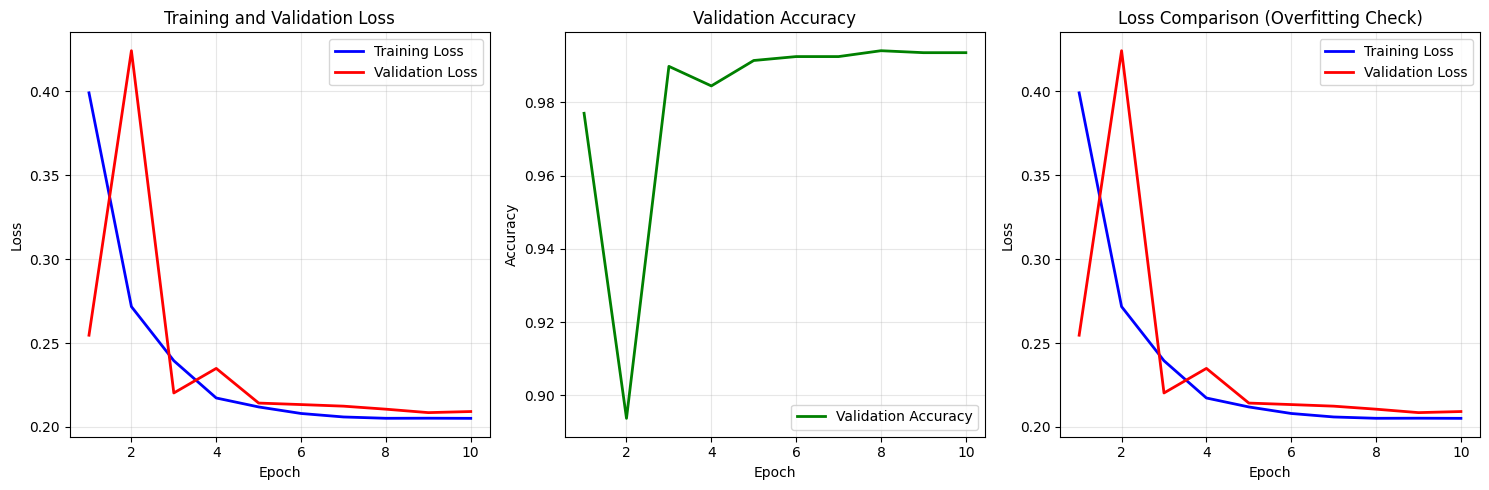

Training curves saved to: results\fold_0\training_curves_fold_0.png

Training Summary for Fold 0:
Total epochs: 10
Final training loss: 0.2051
Final validation loss: 0.2092
Final validation accuracy: 0.9936
Best validation accuracy: 0.9941
Best model saved to: results\best_model_fold_0.pth

Evaluating on test set.
Best model saved to: results\best_model_fold_0.pth

Evaluating on test set.
Test subfolder distribution:
subfolder
real_Kinetics                          24006
OpenSora_train_OpenSora                10871
Latte_train_Latte                       9256
Pika_train_pika                         5994
DynamicCrafter_train_DynamicCrafter     2795
SEINE_train_SEINE                       1651
Youku_1M_10s_0100000_0109999            1042
Youku_1M_10s_0000000_0009999            1017
GenVideo_real                            999
Youku_1M_10s_0710000_0719999             987
Youku_1M_10s_0800000_0809999             984
Youku_1M_10s_0410000_0419999             949
Youku_1M_10s_0260000_0269999 

Test Evaluation:  13%|█▎        | 60/469 [01:39<10:34,  1.55s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151184.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151184.mp4...


Test Evaluation:  20%|█▉        | 92/469 [02:28<09:26,  1.50s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39337.mp4: [11:27:03] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39337.mp4] Failed to measure duration/frame-count due to broken metadata.


Test Evaluation:  32%|███▏      | 152/469 [04:02<08:06,  1.53s/it]

Error loading video D:/GenVideo/real/Kinetics/ukJbDWx_0ZY_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/ukJbDWx_0ZY_000008_000018.mp4...


Test Evaluation:  33%|███▎      | 153/469 [04:03<08:21,  1.59s/it]

Error loading video D:/GenVideo/real/Kinetics/EhGgMx0lK4c_000108_000118.mp4: Error reading D:/GenVideo/real/Kinetics/EhGgMx0lK4c_000108_000118.mp4...


Test Evaluation:  34%|███▍      | 161/469 [04:16<08:19,  1.62s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_13864.mp4: [11:28:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_13864.mp4] Failed to measure duration/frame-count due to broken metadata.


Test Evaluation:  53%|█████▎    | 250/469 [06:35<05:32,  1.52s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_21327.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_21327.mp4...


Test Evaluation:  72%|███████▏  | 336/469 [08:48<03:20,  1.51s/it]

Error loading video D:/GenVideo/real/Kinetics/8rkbNzbJ2EU_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/8rkbNzbJ2EU_000009_000019.mp4...


Test Evaluation:  77%|███████▋  | 363/469 [09:29<02:41,  1.52s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_143558.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_143558.mp4...


Test Evaluation:  82%|████████▏ | 386/469 [10:06<02:08,  1.55s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15740.mp4: [11:34:41] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15740.mp4] Failed to measure duration/frame-count due to broken metadata.


Test Evaluation:  88%|████████▊ | 412/469 [10:46<01:27,  1.54s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158698.mp4...


Test Evaluation:  91%|█████████ | 427/469 [11:10<01:06,  1.59s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41043.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41043.mp4...


Test Evaluation:  93%|█████████▎| 438/469 [11:26<00:45,  1.46s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147221.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147221.mp4...


Test Evaluation: 100%|██████████| 469/469 [12:15<00:00,  1.57s/it]

Test Results:
Accuracy: 0.9957
Precision: 0.9957
Recall: 0.9957
F1-Score: 0.9957
AUC: 0.9992

Training Complete!
Validation accuracy: 0.9941
Test set accuracy: 0.9957
All results saved to: ./results


In [ ]:
if os.name == "nt":
    mp.freeze_support()         
    mp.set_start_method("spawn", force=True)

def main():
    os.makedirs(config.save_dir, exist_ok=True)
    val_accuracy = train_simple()

main()

In [9]:
# Evaluate on test set
model_path = f"{config.save_dir}/best_model_fold_0.pth"
test_results = evaluate_on_test_set(config, model_path)

print(f"Test set accuracy: {test_results['accuracy']:.4f}")


Evaluating on test set.
Test subfolder distribution:
subfolder
real_Kinetics                          24006
OpenSora_train_OpenSora                10871
Latte_train_Latte                       9256
Pika_train_pika                         5994
DynamicCrafter_train_DynamicCrafter     2795
SEINE_train_SEINE                       1651
Youku_1M_10s_0100000_0109999            1042
Youku_1M_10s_0000000_0009999            1017
GenVideo_real                            999
Youku_1M_10s_0710000_0719999             987
Youku_1M_10s_0800000_0809999             984
Youku_1M_10s_0410000_0419999             949
Youku_1M_10s_0260000_0269999             948
Youku_1M_10s_0210000_0219999             448
fake_Lavie                                98
fake_Crafter                              84
fake_Gen2                                 83
fake_HotShot                              51
fake_Show_1                               48
fake_MoonValley                           46
fake_ModelScope                     

Test Evaluation:  13%|█▎        | 60/469 [01:18<08:53,  1.30s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151184.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_151184.mp4...


Test Evaluation:  20%|█▉        | 92/469 [01:58<07:55,  1.26s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_39337.mp4: [19:52:45] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_39337.mp4] Failed to measure duration/frame-count due to broken metadata.


Test Evaluation:  32%|███▏      | 152/469 [03:16<07:13,  1.37s/it]

Error loading video D:/GenVideo/real/Kinetics/ukJbDWx_0ZY_000008_000018.mp4: Error reading D:/GenVideo/real/Kinetics/ukJbDWx_0ZY_000008_000018.mp4...


Test Evaluation:  33%|███▎      | 153/469 [03:17<07:04,  1.34s/it]

Error loading video D:/GenVideo/real/Kinetics/EhGgMx0lK4c_000108_000118.mp4: Error reading D:/GenVideo/real/Kinetics/EhGgMx0lK4c_000108_000118.mp4...


Test Evaluation:  34%|███▍      | 161/469 [03:27<06:28,  1.26s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_13864.mp4: [19:54:15] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_13864.mp4] Failed to measure duration/frame-count due to broken metadata.


Test Evaluation:  53%|█████▎    | 250/469 [05:22<04:40,  1.28s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_21327.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_21327.mp4...


Test Evaluation:  72%|███████▏  | 336/469 [07:15<02:49,  1.27s/it]

Error loading video D:/GenVideo/real/Kinetics/8rkbNzbJ2EU_000009_000019.mp4: Error reading D:/GenVideo/real/Kinetics/8rkbNzbJ2EU_000009_000019.mp4...


Test Evaluation:  77%|███████▋  | 363/469 [07:52<02:16,  1.28s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_143558.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_143558.mp4...


Test Evaluation:  82%|████████▏ | 386/469 [08:21<01:47,  1.29s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15740.mp4: [19:59:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15740.mp4] Failed to measure duration/frame-count due to broken metadata.


Test Evaluation:  88%|████████▊ | 412/469 [08:55<01:13,  1.29s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158698.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158698.mp4...


Test Evaluation:  91%|█████████ | 427/469 [09:13<00:53,  1.26s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41043.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41043.mp4...


Test Evaluation:  93%|█████████▎| 438/469 [09:27<00:37,  1.22s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147221.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_147221.mp4...


Test Evaluation: 100%|██████████| 469/469 [10:07<00:00,  1.30s/it]

Test Results:
Accuracy: 0.9957
Precision: 0.9957
Recall: 0.9957
F1-Score: 0.9957
AUC: 0.9992
Test set accuracy: 0.9957
